# Motion artefact removal

This work is based on the excellent tutorials created by the MNE and MNE-NIRS developers:

- **MNE**: [Tutorials](https://mne.tools/stable/auto_tutorials/index.html)
- **MNE-NIRS**: [Examples](https://mne.tools/mne-nirs/stable/auto_examples/index.html)


## Table of Contents
* [Pre-processing](#chapter_1)
    * [Load python modules](#section_1_1)
    * [Import data](#section_1_2)
        * [Import snirf data](#sub_section_1_2_1)
        * [Add info to raw intensity data](#sub_section_1_2_2)
        * [Signal quality metrics and channel inspection](#sub_section_1_2_3)
        * [Import IMU data](#sub_section_1_2_4)
    * [Create synthetic fNIRS data](#section_1_3)
        * [Create experimental design](#sub_section_1_3_1)
        * [Introduce serial correlations by means of AR model](#sub_section_1_3_2)
        * [Introduce physiological confound](#sub_section_1_3_3)
        * [Add synthetic HRFs](#sub_section_1_3_4)
        * [Introduce motion artifacts](#sub_section_1_3_5)
        * [Inspect signal quality](#sub_section_1_3_6)
    * [Create evaluation metrics](#section_1_4)
        * [Metrics requiring ground truth](#sub_section_1_4_1)
        * [Metrics not requiring ground truth](#sub_section_1_4_2)
    * [Auxiliary hardware algorithms](#section_1_5)
        * [Accelerometer-based motion artifact removal algorithm](#sub_section_1_5_1)
        * [Active noise cancelation](#sub_section_1_5_2)
    * [Signal processing methods](#section_1_6)
        * [Wavelet filtering](#sub_section_1_6_1)
        * [Kurtosis-based wavelet filtering](#sub_section_1_6_2)
        * [Spline interpolation](#sub_section_1_6_3)
        * [Principal component analysis](#sub_section_1_6_4)
        * [Independent component analysis](#sub_section_1_6_5) 
        * [Temporal derivative distribution repair](#sub_section_1_6_6)
        * [Correlation-based signal improvement](#sub_section_1_6_7)
     * [Compare motion artefact techniques](#section_1_7)
        * [Synthetic datasets](#sub_section_1_7_1)
        * [Motion artefact experiment data](#sub_section_1_7_2)
        * [Determine best motion artefact correction technique](#sub_section_1_7_3)

## Pre-processing <a class="anchor" id="chapter_1"></a>

---
### Load python modules <a class="anchor" id="section_1_1"></a>

In [1]:
# Import the needed modules 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os.path as op
import padasip as pa
import dataframe_image as dfi
import mne
import mne_nirs
import pywt
import scipy
import dabest
from itertools import compress
from mne.preprocessing.nirs import scalp_coupling_index, optical_density, temporal_derivative_distribution_repair, beer_lambert_law, _validate_nirs_info, source_detector_distances
from mne.preprocessing.nirs._beer_lambert_law import _load_absorption
from mne_nirs.preprocessing import peak_power, scalp_coupling_index_windowed, quantify_mayer_fooof
from mne_nirs.visualisation import plot_timechannel_quality_metric
from mne_nirs.channels import get_short_channels, get_long_channels, picks_pair_to_idx
from mne_nirs.signal_enhancement import short_channel_regression, enhance_negative_correlation
from mne_nirs.experimental_design import make_first_level_design_matrix
from mne.preprocessing import ICA, corrmap
from mne._fiff.constants import FIFF
from mne.filter import create_filter
from scipy.stats import norm, ttest_1samp, kurtosis, pearsonr, multivariate_normal
from scipy.signal import wiener, lfilter
from scipy.interpolate import CubicSpline, interp1d
from scipy.linalg import toeplitz
from fooof import FOOOF
from csaps import csaps
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler

C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,
C:\Users\fabia\AppData\Local\Temp\ipykernel_4692\2040918015.py:29: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF


In [2]:
# Write own fucntions
def reorder(raw_initial):
    """
    Input: raw object
    Function: reorders the channels to match the MNE standard
    """
    raw = raw_initial.copy()
    channel_names = raw.ch_names
    channel_names_ordered = []
    for i in range(0, int(len(channel_names)/2)):
        channel_names_ordered.append(channel_names[i])
        channel_names_ordered.append(channel_names[(i + int(len(channel_names)/2))])
    raw_ordered = raw.reorder_channels(channel_names_ordered)
    return raw_ordered

def add_info(raw_intensity, first_name, last_name, age, sex, EHI, annotations, duration_annotation, duration_rest, N_control):
    """
    Input: raw object, first name, last name, age, sex, EHI, annotations, duration of annotation, duration of baseline period, # of control trials
    Function: Returns raw object with added subject info and random allocated control trials within the baseline period
    """
    raw = raw_intensity.copy()
    
    # Add subject info
    raw.info["subject_info"] = {'first_name' : first_name, 'last_name' : last_name, 'age' : age, 'sex' : sex, 'EHI' : EHI}
    
    # attribute meaningful names to trigger codes. Include information about the duration of each stimulus (10 seconds). 
    raw.annotations.set_durations(duration_annotation)
    raw.annotations.rename(annotations)
    
    events, event_dict = mne.events_from_annotations(raw)
    
    # Define begin and end of rest period
    begin_rest = np.ceil(events[np.where(events[:,2] == event_dict['Baseline'])[0][0],0]/raw.info['sfreq'])
    end_rest = begin_rest + duration_rest - duration_annotation 
    
    # Remove start indicator of rest period
    raw.annotations.delete(np.nonzero(raw.annotations.description == "Baseline"))
    
    # Define indices of random selected control trials
    indices = np.random.choice(np.arange(begin_rest, end_rest), N_control, replace = False).astype(int)
    raw.annotations.append(indices, [duration_annotation]*N_control, ["Baseline"]*N_control)
    
    return raw

def crop(raw_input, t_before = 10, t_after = 60):
    """
    Input: raw object, time interval length before first event and time interval length after last event that should be included in the recording
    Function: crops raw object to a recording starting 't_before' s (default 10 s) before the first annotated event and ending 't_after' s (default 60 s) after the last event 
    """
    raw = raw_input.copy()
    end_rec = raw.get_data().shape[1]/raw.info['sfreq']
    t_start = events[0,0]/raw.info['sfreq'] - t_before
    t_end = events[-1,0]/raw.info['sfreq'] + t_after
    if t_start < 10:
        t_start = 0
    if t_end > end_rec:
        t_end = end_rec
    raw.crop(t_start, t_end)
    return raw

def get_indices(array, target_array):
    """
    Input: complete array of channel names, array of channels names to be removed
    Function: gives back indices of desired channels
    """
    lst = list(array)
    indices = list(np.arange(0, len(array)))
    for target in target_array:
        if target in lst:
            indices.remove(lst.index(target))
    return indices

def ch_names_L_R(raw):
    """
    Input: raw object
    Function: Separate list of channel names in 2 lists for the left and right hemisphere respectively
    """
    left, right = [], []
    for ch in raw.ch_names:
        if (int(ch[1]) % 2) == 0:
            right.append(ch)
        else:
            left.append(ch)
    return left, right

def scale_up_spectra(spectra, freqs):
    """
    Input: spectra, freqs
    Function: FOOOF requires the frequency values to be higher than the fNIRS data permits, 
    so we scale the values up by 10 here, and then will scale
    the frequency values down by 10 later.
    """
    freqs = freqs * 10
    return spectra, freqs

def get_IMU_data(filename, plot = False, sfreq = None, export = False, logy = True):
    """
    Extract IMU data from text file.
    Input: filename with .txt, plot (bool)
    Output: Three dataframes containing the complete IMU data, the accelerometer data and the gyroscope data respectively
    """
    
    # Read .txt file and convert to dataframe
    df = pd.read_csv(filename, sep=';', header=None, names=["time", "battery", "channels", "gyroX", "gyroY", "gyroZ", "accX", "accY", "accZ", "marker", "_"])

    # Select IMU data
    data = df.drop(0)
    markers = data["marker"].astype(float)
    IMU_data = data.drop(columns =['time', 'battery', 'channels', 'marker', '_']).astype(float)

    gyro_data = IMU_data.drop(columns = ['accX', 'accY', 'accZ'])
    acc_data = IMU_data.drop(columns = ["gyroX", "gyroY", "gyroZ"])
    
    if plot: 
        t = np.arange(gyro_data.to_numpy().shape[0])/sfreq
        gyro_data['time'] = t
        acc_data['time'] = t
        plot1 = gyro_data.plot(x = 'time', title='Gyroscope data', grid = True, xlabel = 'time (s)', ylabel = 'dps', logy = logy, figsize=(11,5))
        plot2 = acc_data.plot(x = 'time', title='Accelerometer data', grid = True, xlabel = 'time (s)', ylabel = 'm/s^2', logy = logy, figsize=(11,5))

        if export:
            fig1 = plot1.get_figure()
            fig2 = plot2.get_figure()
            fig1.savefig('Gyroscope_data.png')
            fig2.savefig('Accelerometer_data.png')
        
    return IMU_data, acc_data, gyro_data

def set_stimuli(raw_intensity, stimDur, restDur, t_begin, baseDur, t_rest, N_stimuli, N_control):
    raw = raw_intensity.copy()
    
    # Include information about the duration of each stimulus (seconds). 
    raw.annotations.set_durations(stimDur)
    
    # Define indices of random selected control trials
    end_rest = t_begin + baseDur - stimDur
    indices = np.random.choice(np.arange(t_begin, end_rest), N_control, replace = False).astype(int)
    raw.annotations.append(indices, [stimDur]*N_control, ["Baseline"]*N_control)

    # Define indices of hand grasping movement
    t_start = t_begin + baseDur + t_rest
    indices = t_start + np.arange(N_stimuli)*(stimDur + restDur)
    raw.annotations.append(indices, [stimDur]*N_stimuli, ["Task"]*N_stimuli)

    # Add info
    raw.info["subject_info"] = {'first_name' : 'Synthetic', 'last_name' : 'Data'}
    
    return raw

def find_duplicates_with_set(arr):
    seen = set()
    duplicates = set()
    for item in arr:
        if item in seen:
            duplicates.add(item)
        else:
            seen.add(item)
    return list(duplicates)

def MSD(x, k):
    w = 2*k+1
    N = len(x)
    msd = np.zeros_like(x)
    msd[:k] = np.NAN
    msd[-k:] = np.NAN
    for t in range(k,N-k):
        x_window = x[t-k:t+k+1]
        msd[t] = np.sqrt(np.sum(x_window**2)-np.sum(x_window)**2/w)/w
    return msd

In [3]:
# Set plot characteristics
%matplotlib inline
sns.set_theme() # nicer plots
# Load external plots?
plot = False
# export figures?
export = False

### Import data <a class="anchor" id="section_1_2"></a>

#### Import snirf data <a class="anchor" id="sub_section_1_2_1"></a>

In [4]:
filename = 'MA_experiment_data.snirf'

In [5]:
# Read snirf data with motion artefacts
raw = mne.io.read_raw_snirf(filename, optode_frame='unknown', preload=False, verbose=None)

Loading C:\Users\fabia\fNIRS data analysis\Motion artefact removal selection\MA_experiment_data.snirf


In [6]:
# Reorder channels (Due to non-uniformity between mne_nirs and .snirf data)
raw_intensity = reorder(raw)

#### Add info to raw intensity data  <a class="anchor" id="sub_section_1_2_2"></a>

In [7]:
# Use self-written function to add info about the subject and the recording
annotations = {"1": "practice/Vertical", "2": "practice/Horizontal", "3": "practice/Random", "4": "test/Vertical", "5": "test/Horizontal", "6": "test/Random", "7": "Baseline"}
raw_intensity = add_info(raw_intensity, 'Subject', '1', 22, 'female', 'left', annotations, 3, 60, 10)

Used Annotations descriptions: ['Baseline', 'practice/Horizontal', 'practice/Random', 'practice/Vertical', 'test/Horizontal', 'test/Random', 'test/Vertical']


In [8]:
# Look at characteristics
raw_intensity

<RawSNIRF | MA_experiment_data.snirf, 52 x 5163 (877.5 s), ~52 kB, data not loaded>

Used Annotations descriptions: ['Baseline', 'practice/Horizontal', 'practice/Random', 'practice/Vertical', 'test/Horizontal', 'test/Random', 'test/Vertical']


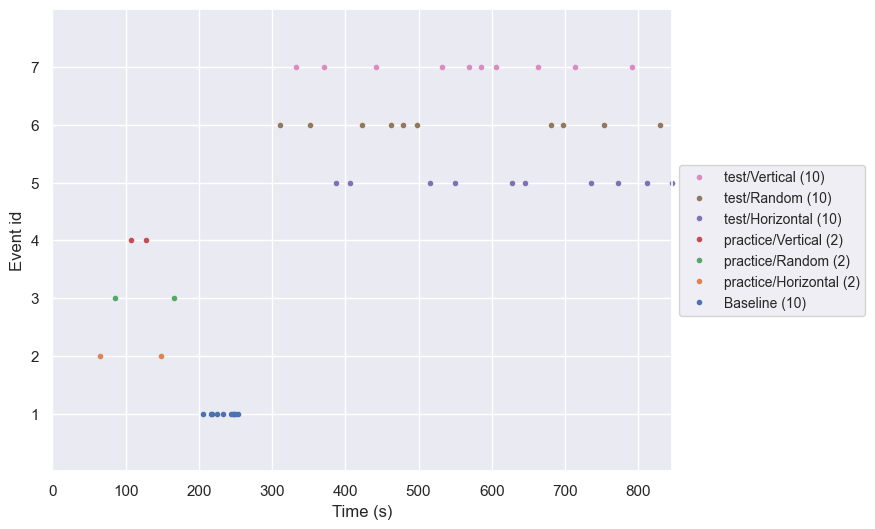

In [9]:
# Look at segments
events, event_dict = mne.events_from_annotations(raw_intensity)
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)
fig = mne.viz.plot_events(events, event_id=event_dict, sfreq=raw_intensity.info['sfreq'])
if export:
    fig.savefig('events_MA.png')

##### Adress problem with timing of fNIRS recordings

The stimulus presentation software PsychoPy was used to set-up this experiment. In the MA experiment, each stimulus in the sequence was  displayed for 12 seconds, followed by a blank screen for a duration between 17-23 seconds, before presenting the next stimuli. However, in the *.snirf* file the stimuli are not as expected. This problem is related to the problem with the overall timing of the fNIRS recordings as explained in more detail in the **Timing problem** Notebook.

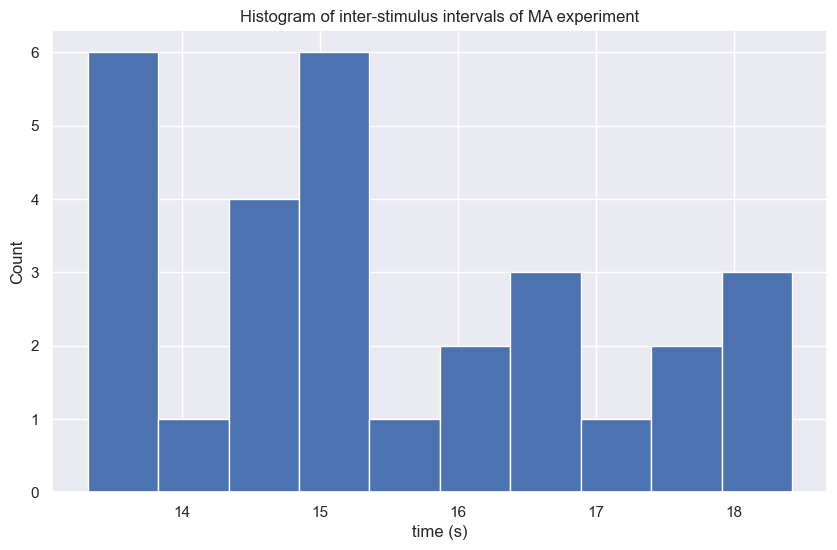

In [13]:
# Get IDs of events
ids = [event_dict['test/Horizontal'], event_dict['test/Random'], event_dict['test/Vertical']]
# Determine inter-stimuli intervals
inter_stim = np.diff(events[np.isin(events[:,2], ids)][:,0])/raw_intensity.info['sfreq'] - 3
if plot:
    # plot
    plt.hist(inter_stim)
    plt.xlabel('time (s)')
    plt.ylabel('Count')
    plt.title('Histogram of inter-stimulus intervals of MA experiment')
    if export:
        plt.savefig('Histogram_inter_stimuli_MA.png')

In [11]:
# As a table
raw_intensity.annotations.to_data_frame()

onset  duration          description
0  2024-05-08 13:36:04.600       3.0  practice/Horizontal
1  2024-05-08 13:36:25.170       3.0      practice/Random
2  2024-05-08 13:36:46.760       3.0    practice/Vertical
3  2024-05-08 13:37:08.180       3.0    practice/Vertical
4  2024-05-08 13:37:28.240       3.0  practice/Horizontal
5  2024-05-08 13:37:46.430       3.0      practice/Random
6  2024-05-08 13:38:20.000       3.0             Baseline
7  2024-05-08 13:38:21.000       3.0             Baseline
8  2024-05-08 13:38:24.000       3.0             Baseline
9  2024-05-08 13:38:27.000       3.0             Baseline
10 2024-05-08 13:38:30.000       3.0             Baseline
11 2024-05-08 13:38:36.000       3.0             Baseline
12 2024-05-08 13:38:37.000       3.0             Baseline
13 2024-05-08 13:38:41.000       3.0             Baseline
14 2024-05-08 13:38:48.000       3.0             Baseline
15 2024-05-08 13:38:51.000       3.0             Baseline
16 2024-05-08 13:40:11.100       3.0          test/Random
17 2024-05-08 13:40:32.520       3.0        test/Vertical
18 2024-05-08 13:40:51.560       3.0          test/Random
19 2024-05-08 13:41:11.280       3.0        test/Vertical
20 2024-05-08 13:41:27.770       3.0      test/Horizontal
21 2024-05-08 13:41:45.960       3.0      test/Horizontal
22 2024-05-08 13:42:02.280       3.0          test/Random
23 2024-05-08 13:42:22.170       3.0        test/Vertical
24 2024-05-08 13:42:41.890       3.0          test/Random
25 2024-05-08 13:42:59.400       3.0          test/Random
26 2024-05-08 13:43:18.270       3.0          test/Random
27 2024-05-08 13:43:35.610       3.0      test/Horizontal
28 2024-05-08 13:43:52.100       3.0        test/Vertical
29 2024-05-08 13:44:10.290       3.0      test/Horizontal
30 2024-05-08 13:44:28.480       3.0        test/Vertical
31 2024-05-08 13:44:45.650       3.0        test/Vertical
32 2024-05-08 13:45:06.390       3.0        test/Vertical
33 2024-05-08 13:45:27.810       3.0      test/Horizontal
34 2024-05-08 13:45:46.000       3.0      test/Horizontal
35 2024-05-08 13:46:02.490       3.0        test/Vertical
36 2024-05-08 13:46:20.510       3.0          test/Random
37 2024-05-08 13:46:37.170       3.0          test/Random
38 2024-05-08 13:46:53.660       3.0        test/Vertical
39 2024-05-08 13:47:15.080       3.0      test/Horizontal
40 2024-05-08 13:47:33.270       3.0          test/Random
41 2024-05-08 13:47:52.990       3.0      test/Horizontal
42 2024-05-08 13:48:11.350       3.0        test/Vertical
43 2024-05-08 13:48:31.920       3.0      test/Horizontal
44 2024-05-08 13:48:49.260       3.0          test/Random
45 2024-05-08 13:49:06.600       3.0      test/Horizontal

#### Signal quality metrics and channel inspection <a class="anchor" id="sub_section_1_2_3"></a>

The quality of a fNIRS recording can be assessed by a visual inspection of the signals. On the one hand there can be features present in the signals which indicate a good signal quality, such as certain physiological components, and on the other hand there can be features present which indicate bad signal quality in one or more channels, such as MAs.

##### Validate that the location of sources-detector pairs and channels are in the expected locations

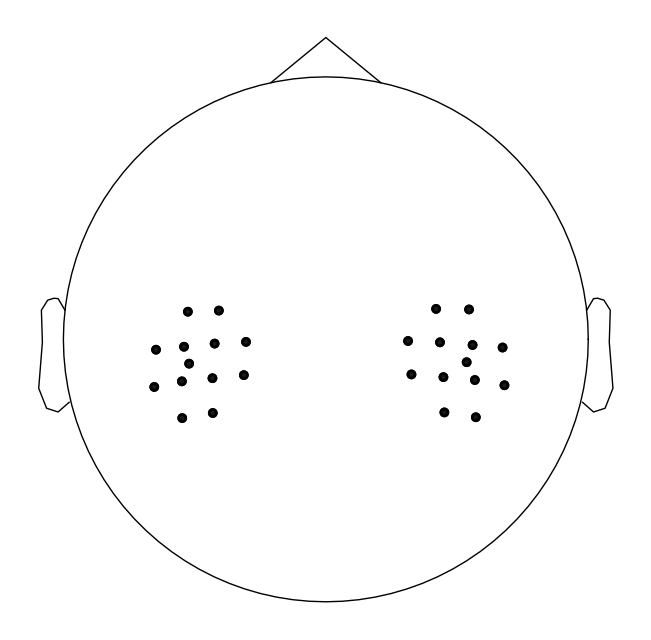

In [12]:
# Plot channels in 2D using build-in function of mne_nirs
sns.reset_defaults() # Turn of sns to be able to also plot contour of head
# dots = Center of channels
%matplotlib inline
raw_intensity.plot_sensors();

In [13]:
sns.set_theme()

In [14]:
if plot:
    # Plot channels in 3D
    subjects_dir = mne.datasets.sample.data_path() / "subjects"
    mne.datasets.fetch_fsaverage(subjects_dir=subjects_dir)

    brain = mne.viz.Brain("fsaverage", subjects_dir=subjects_dir, alpha=0.5, cortex="low_contrast")
    brain.add_head()
    
    identity_trans = mne.transforms.Transform("head", "mri") #transformed coord
    brain.add_sensors(raw_intensity.info, trans=identity_trans, fnirs=["channels", "pairs", "sources", "detectors"])

    # Add ROI: BA 1, 2, 3 - Primary somatosensory cortex (postcentral gyrus)
            # BA 4 - Primary motor cortex (precentral gyrus)
            # BA 5 - Somatosensory association cortex (NOT PRESENT IN LABELS)
            # BA 6	Premotor and supplementary motor cortex
    brain.add_label("BA1", hemi = "lh", borders=False, color='red')
    brain.add_label("BA1", hemi = "rh", borders=False, color='red')
    brain.add_label("BA2", hemi = "rh", borders=False, color='orange')
    brain.add_label("BA2", hemi = "lh", borders=False, color='orange')
    brain.add_label("BA3a", hemi = "rh", borders=False, color='yellow')
    brain.add_label("BA3b", hemi = "rh", borders=False, color='yellow')
    brain.add_label("BA3a", hemi = "lh", borders=False, color='yellow')
    brain.add_label("BA3b", hemi = "lh", borders=False, color='yellow')
    brain.add_label("BA4a", hemi = "lh", borders=False, color='green')
    brain.add_label("BA4a", hemi = "rh", borders=False, color='green')
    brain.add_label("BA4p", hemi = "lh", borders=False, color='green')
    brain.add_label("BA4p", hemi = "rh", borders=False, color='green')
    brain.add_label("BA6", hemi = "lh", borders=False, color='blue')
    brain.add_label("BA6", hemi = "rh", borders=False, color='blue')
    brain.show_view(azimuth=90, elevation=90, distance=500)

---
> *Remark:*
- 24 long channels and 2 short channels
- 8 sources, 10 detectors and 2 short channel sources
- montage located above sensorimotor cortex
---

##### Visual inspection of the raw light intensity data

In [15]:
# Plot raw data with build-in plot function of mne_nirs
if plot:
    %matplotlib qt
    raw_intensity.plot(duration=60, show_scrollbars = True, clipping = None);

The three types of head movements are observable in the fNIRS recordings between 750 and 810 seconds. Zooming in on channels S6-D4, S7-D3, S8-D4, and S3-D5 reveals that motion artifacts, such as spikes and baseline shifts, appear in the light intensity recordings with an approximate 5-second delay. This example also demonstrates that not all channels are affected by motion artifacts, and among those that are, the spikes or baseline shifts do not exhibit the same amplitude. Additionally, it appears that horizontal movements have a lesser impact on the fNIRS recordings, which is expected since less optode displacement occurs when the head rotates around the vertical axis compared to rotation around the frontal axis.

Using matplotlib as 2D backend.


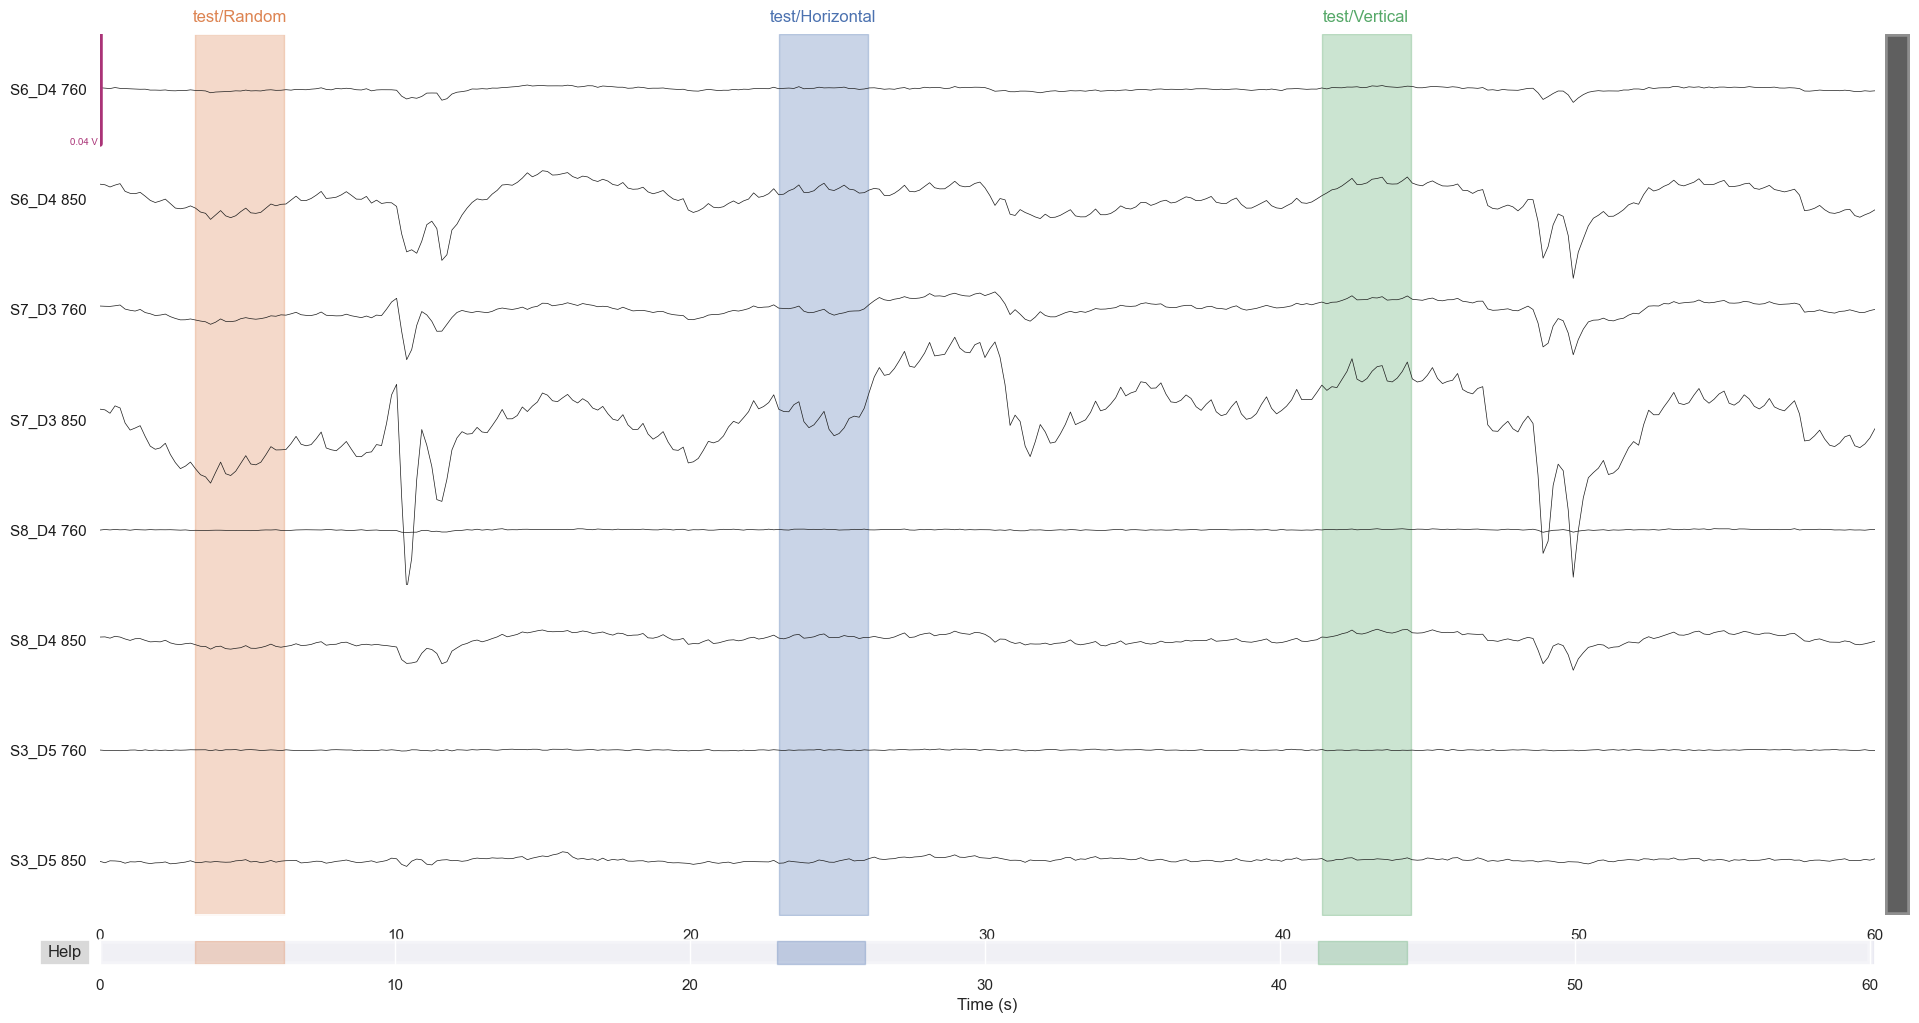

In [16]:
%matplotlib inline
fig = raw_intensity.copy().pick(np.arange(18,26)).crop(750,810).plot(duration=60)
if export:
    fig.savefig('MA_VI_1.png')

---
> *Remark:*
- Physiological components: Heartrate and Mayer waves are visible
- Extrinsic components: Spikes, baseline shifts, and combitions of the two
---

##### Visual inspection of the the optical density 

The OD or the attenuation of incident light, can be calculated as the logarithmic ratio of the input light intensity ($I_{in}$) and the detected light intensity ($I_{out}$):
$$OD_\lambda = \log \left(\frac{I_{in}}{I_{out}}\right)$$

In [17]:
# Convert raw intensity data to OD with build-in function of mne_nirs
raw_od = optical_density(raw_intensity)

Reading 0 ... 5162  =      0.000 ...   877.540 secs...


In [18]:
# Plot OD
if plot:
    %matplotlib qt
    raw_od.plot(duration=120, show_scrollbars = True, clipping = None);

Similar observation as the previous one can also be found in the OD data between 350 and 410 seconds, this time in channels S10-D2, S1-D7 and S2-D8.

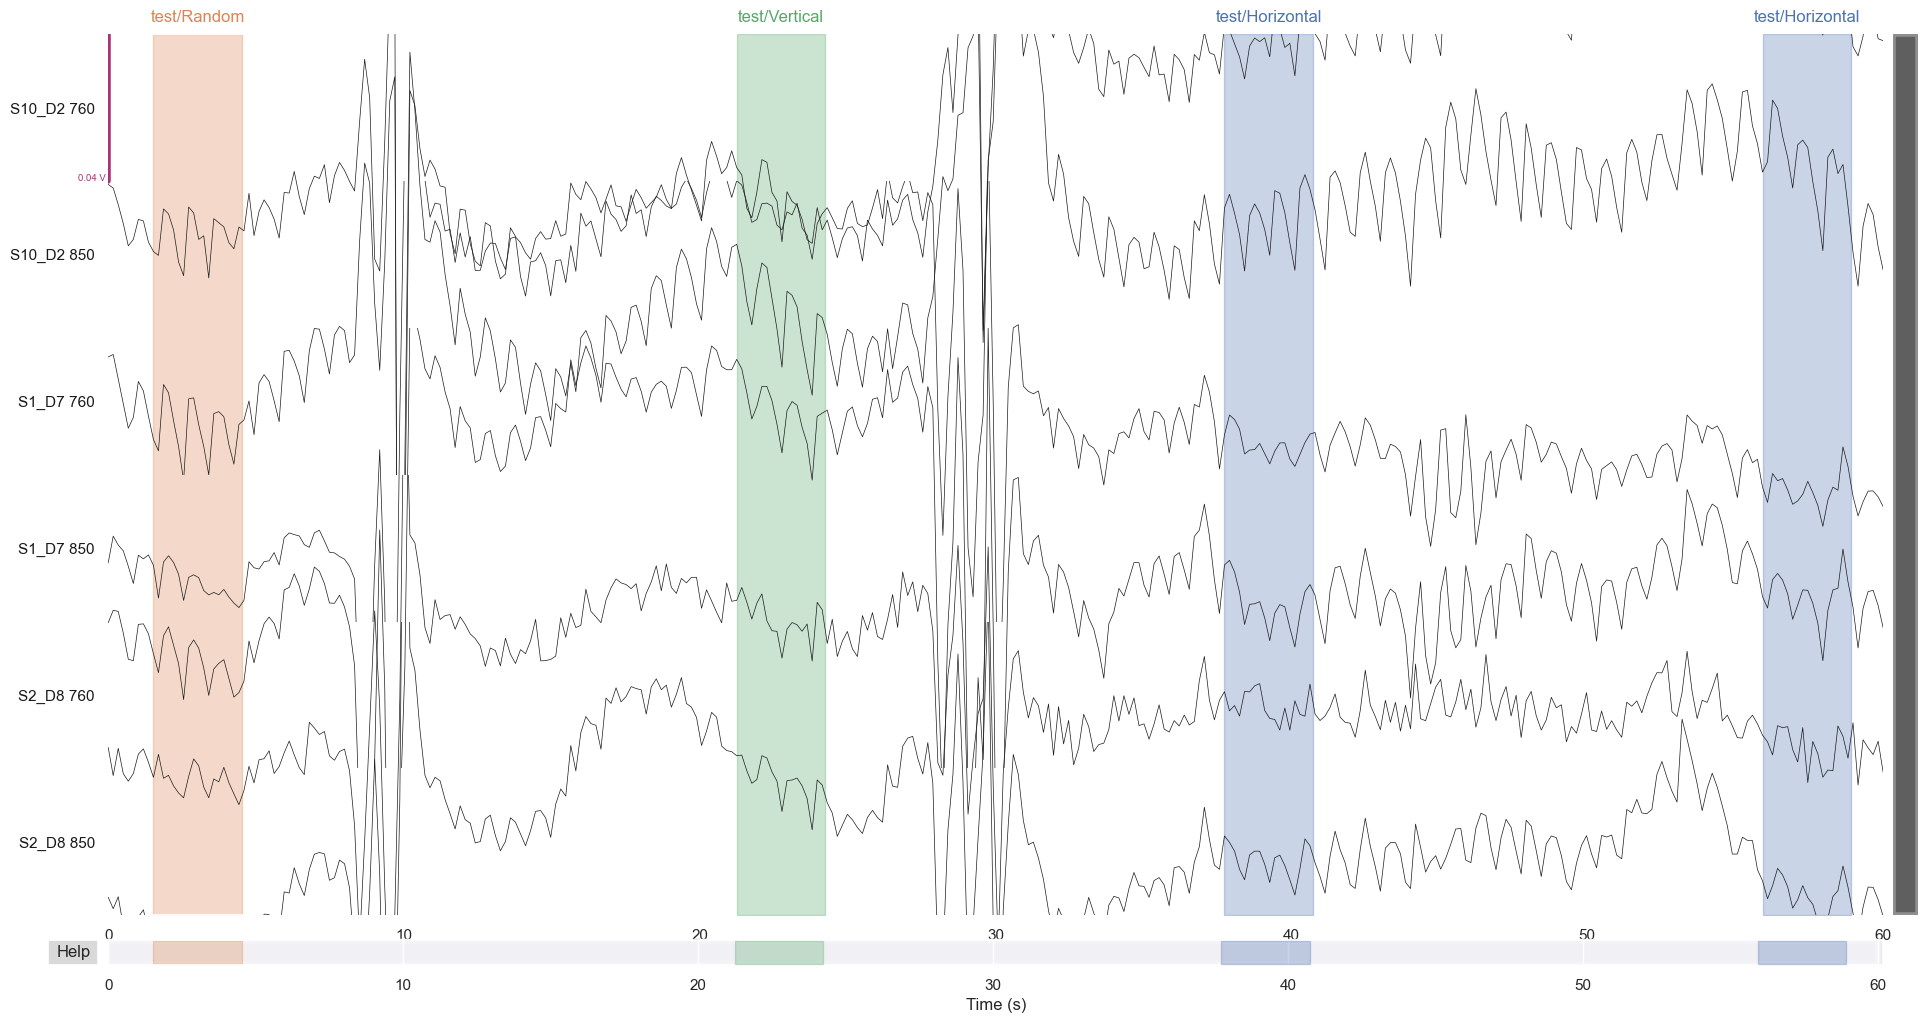

In [19]:
%matplotlib inline
fig = raw_od.copy().pick(['S10_D2 760', 'S10_D2 850', 'S1_D7 760', 'S1_D7 850', 'S2_D8 760', 'S2_D8 850']).crop(350,410).plot(duration=60)
if export:
    fig.savefig('MA_VI_2.png')

---
> *Remark:*
- Physiological components: Heartrate and Mayer waves are visible
- Extrinsic components: Spikes, baseline shifts, and combitions of the two
---

##### Visual inspection of the haemoglobin concentration

By solving the Beer-Lambert law for two measurement wavelengths on either side of the isosbestic point - the point where the HbR and HbO spectra cross, the unknows can be eliminated from the equation. Small changes of attenuation for both wavelengths, due to changes in  HbR and HbO concentrations, can be detected with the following formula:
$$ \Delta OD_\lambda = \log \left(\frac{I_{rest}}{I_{test}}\right) \ \approx \epsilon_\lambda^{HbR} \cdot \Delta c^{HbR} \cdot L + \epsilon_\lambda^{HbO} \cdot \Delta c^{HbO} \cdot L $$
From the two resulting equations, one for each wavelength, the chromophore concentrations can be found:
$$ [HbO] = \frac{a_{HbO}^{\lambda_2} \cdot \Delta A_{\lambda_1} - a_{HbR}^{\lambda_1} \cdot \Delta A_{\lambda_2}}{L \cdot (a_{HbO}^{\lambda_1} \cdot a_{HbR}^{\lambda_2} - a_{HbO}^{\lambda_2} \cdot a_{HbR}^{\lambda_1})} $$
$$ [HbR] = \frac{a_{HbO}^{\lambda_1} \cdot \Delta A_{\lambda_2} - a_{HbR}^{\lambda_2} \cdot \Delta A_{\lambda_1}}{L \cdot (a_{HbO}^{\lambda_1} \cdot a_{HbR}^{\lambda_2} - a_{HbO}^{\lambda_2} \cdot a_{HbR}^{\lambda_1})}$$

In [20]:
# Convert OD to haemoglobin concentration with build-in function of mne_nirs
# Constant ppf value: PPF = DPF/PVC
raw_haemo = beer_lambert_law(raw_od, ppf=6) # ppf=6 is more inline with the community expectations and makes our results easier compared to the majority of the existing literature.

In [21]:
# Plot concentrations
if plot:
    %matplotlib qt
    raw_haemo.plot(duration=60, show_scrollbars = True, clipping = None);

Remark: scale of MNE plots can not be changed when plotted inline. Please see plot above to be able to zoom in on graph.

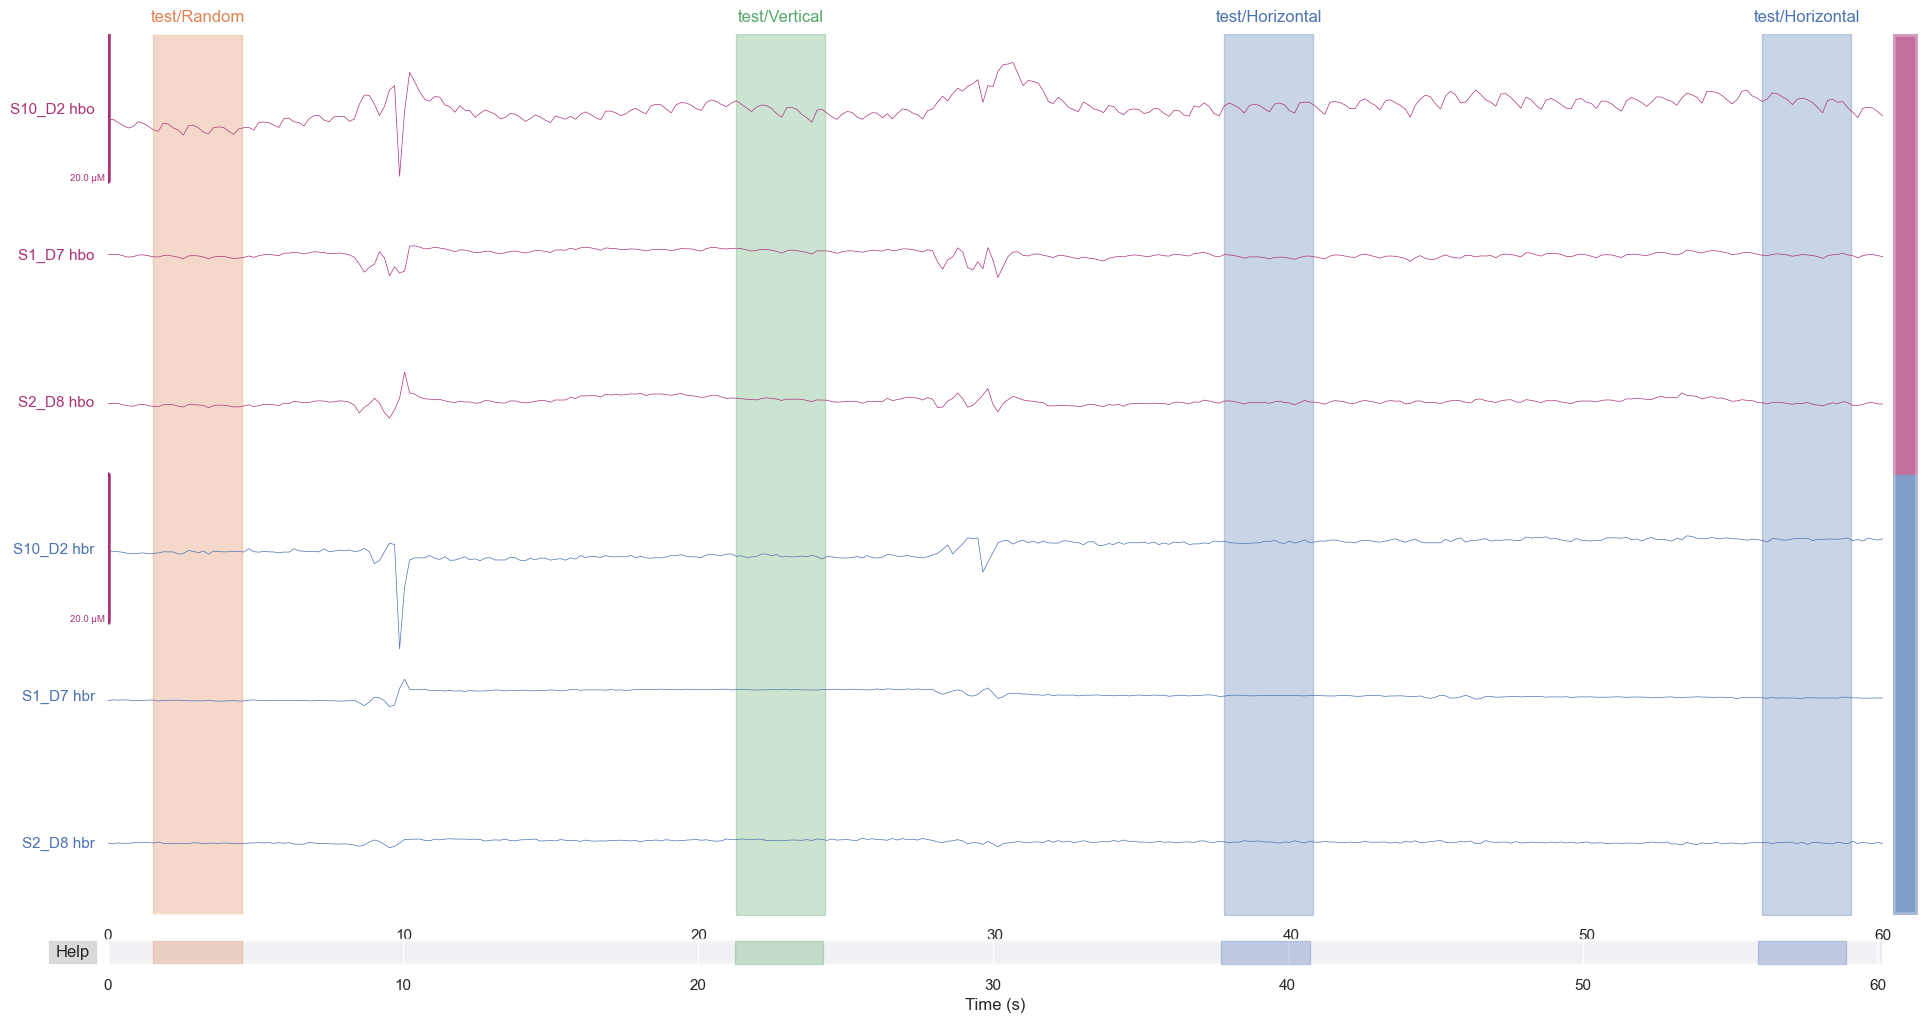

In [22]:
%matplotlib inline
fig = raw_haemo.copy().pick(['S10_D2 hbo', 'S10_D2 hbr', 'S1_D7 hbo', 'S1_D7 hbr', 'S2_D8 hbo', 'S2_D8 hbr']).crop(350,410).plot(duration=60)
if export:
    fig.savefig('MA_VI_3.png')

---
> *Remark:*
- Physiological components: Heartrate and Mayer waves are visible
- Extrinsic components: Spikes, baseline shifts, and combitions of the two
---

##### Scalp-coupling index

The SCI will be calculated to illustrate that indeed the quality of the signals is bad due to the present motion artefacts in the fNIRS recording. However, no channels will be marked as bad.

###### SCI over whole signal

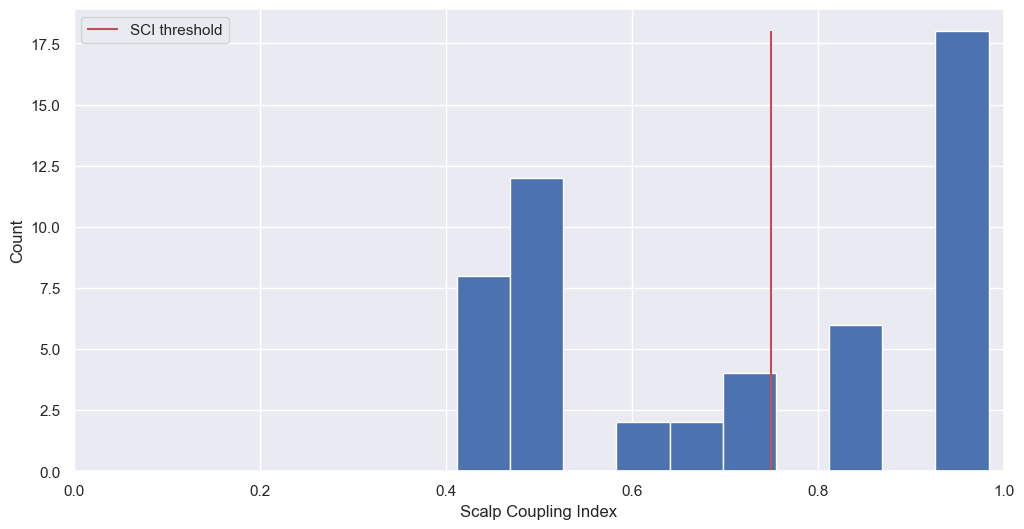

In [23]:
# Calculate SCI with build-in function of mne_nirs
sci = scalp_coupling_index(raw_od, l_freq=0.7, h_freq=1.5, l_trans_bandwidth=0.3, h_trans_bandwidth=0.3, verbose=False)
# SCI bandpasses the signal with a FIR filter: l_freq=0.7, h_freq=1.5, l_trans_bandwidth=0.3, h_trans_bandwidth=0.3

# Plot histogram of SCI values
%matplotlib inline
fig, ax = plt.subplots(figsize=(12,6))
ax.hist(sci)
ax.set(xlabel='Scalp Coupling Index', ylabel='Count', xlim=[0, 1])
plt.vlines(0.75, ymin = 0, ymax = 18, color = 'r', label = 'SCI threshold')
plt.legend()
if export:
    plt.savefig('MA_SCI.png')
plt.show()

In [24]:
# Copy raw object to apply SCI 
raw_od_SCI = raw_od.copy()
# Mark channels with SCI < 0.75 as BAD
raw_od_SCI.info['bads'] = list(compress(raw_od.ch_names, sci < 0.75)) # 0.75 RECOMMENDED BY Pollonini et al. (2013)
print('The ' + str(len(raw_od_SCI.info['bads'])) + ' bad channels are: ' + str(raw_od_SCI.info['bads']))

The 28 bad channels are: ['S1_D1 760', 'S1_D1 850', 'S3_D1 760', 'S3_D1 850', 'S4_D2 760', 'S4_D2 850', 'S5_D1 760', 'S5_D1 850', 'S6_D2 760', 'S6_D2 850', 'S7_D1 760', 'S7_D1 850', 'S5_D3 760', 'S5_D3 850', 'S3_D5 760', 'S3_D5 850', 'S4_D6 760', 'S4_D6 850', 'S6_D6 760', 'S6_D6 850', 'S1_D9 760', 'S1_D9 850', 'S2_D10 760', 'S2_D10 850', 'S7_D9 760', 'S7_D9 850', 'S8_D10 760', 'S8_D10 850']


###### SCI evaluated over moving window

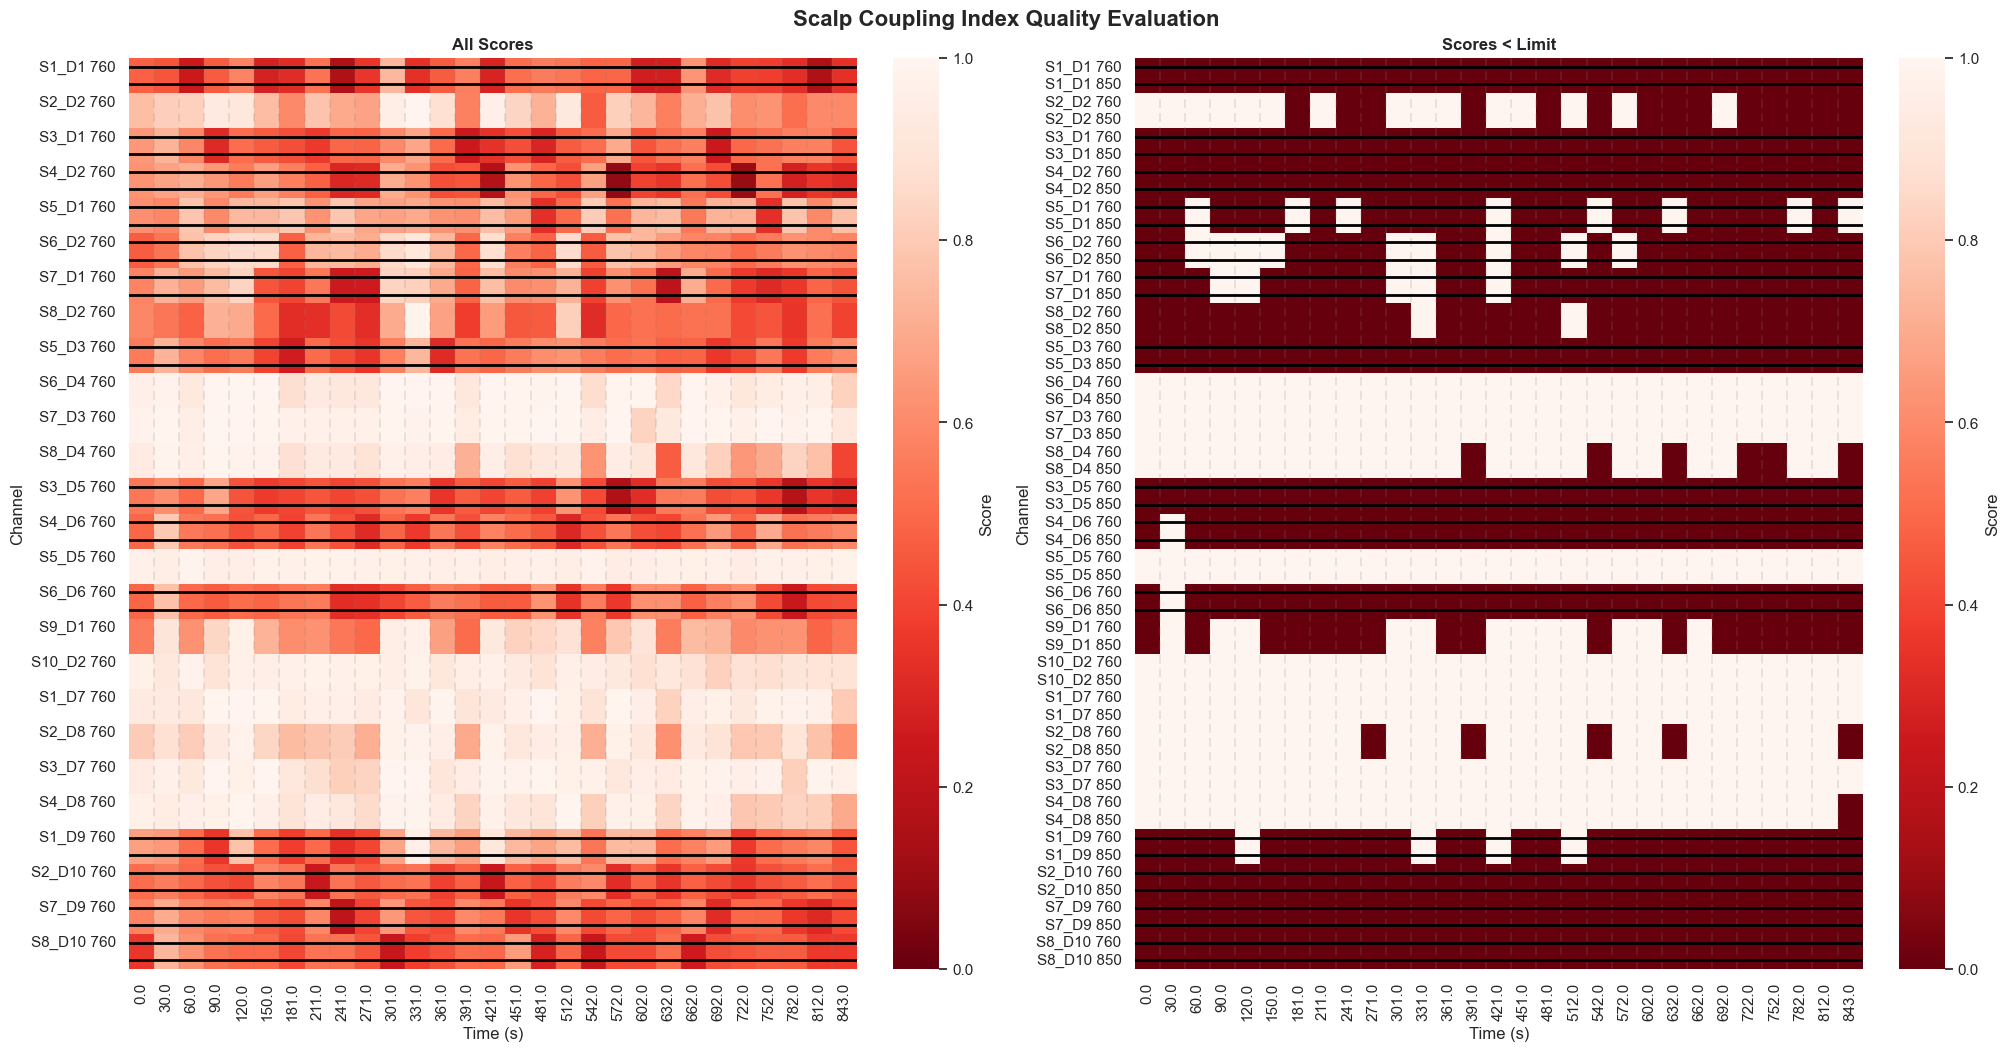

In [25]:
# Calculate windowed SCI with windows of 30 s
_, scores, times = scalp_coupling_index_windowed(raw_od_SCI, time_window=30)

%matplotlib inline
# Plot
plot_timechannel_quality_metric(raw_od_SCI, scores, times, threshold=0.75, title="Scalp Coupling Index Quality Evaluation");

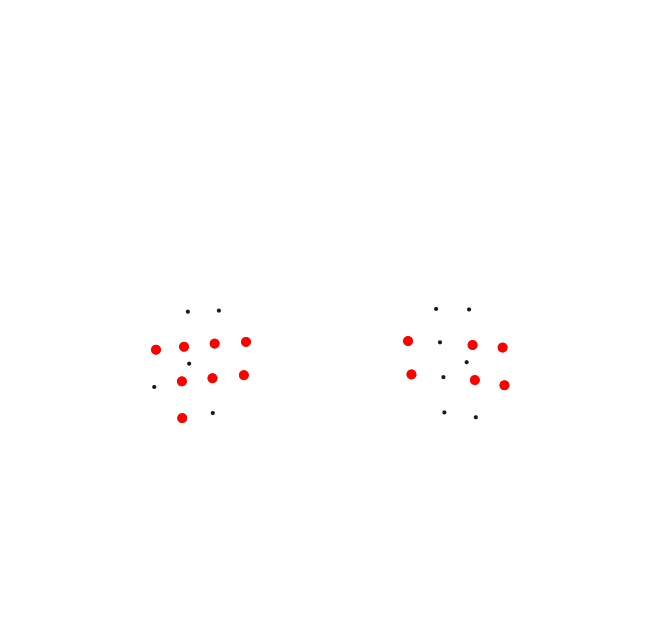

In [26]:
# Bad channels are now displayed in red
%matplotlib inline
fig = raw_od_SCI.plot_sensors()
if export:
    fig.savefig('MA_SCI_topomap.png')

---
> *Remark:*
- 28 channels would have been rejected for the full recording based on the SCI
- Channels of S2-D2, S8-D4 and S2-D8 have a bad SCI during certain intervals
---

##### Peak spectral power

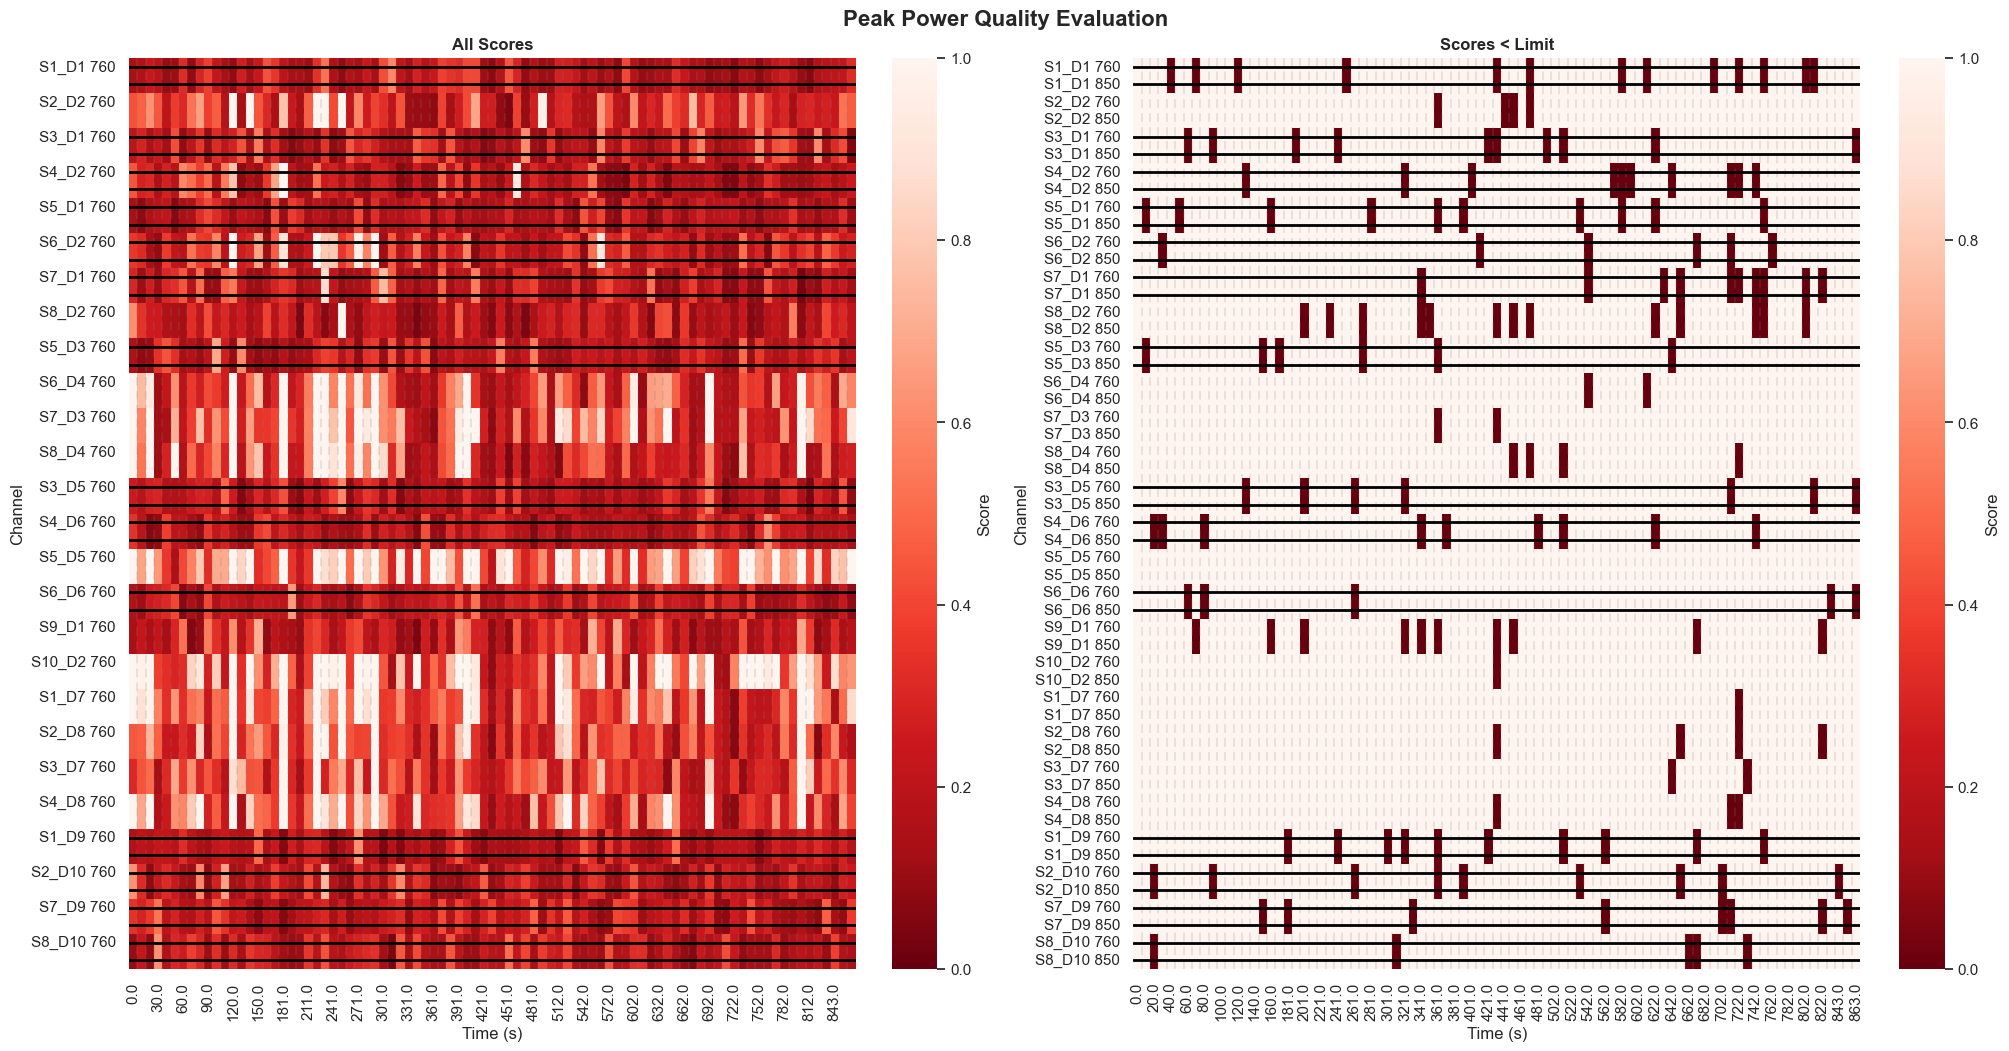

In [27]:
# View instances where a subset of channels may be contaminated by artifacts for a short duration of the recording
raw_od_SCI_PSP, scores, times = peak_power(raw_od_SCI, time_window=10)

# Plot
%matplotlib inline
fig = plot_timechannel_quality_metric(raw_od_SCI_PSP, scores, times, threshold=0.1, title="Peak Power Quality Evaluation") #see PHOEBE
if export:
    fig.savefig('MA_PSP.png')

---
> *Remark:*
- Not all segments with a PSP value under 0.1 were located in channels that were already indicated by the SCI method as bad channels
- Extra segments wold have been removed from the analysis
---

#### Import IMU data <a class="anchor" id="sub_section_1_2_4"></a>

In [28]:
sfreq = raw_od.info['sfreq']
IMU_data, acc_df, gyro_df = get_IMU_data(filename[:-5] + 'txt', plot = plot, sfreq = sfreq, export = export, logy =False)

---
> *Remark:*
- The periodic peaks in these plots clearly indicate the points in time when stimuli were presented to the subject and the subsequent head movements were performed. 
---

### Create synthetic fNIRS data <a class="anchor" id="section_1_3"></a>

This method of synthetic fNIRS data generation is based on the work of Gemignani et al. (2021).

#### Create experimental design <a class="anchor" id="sub_section_1_3_1"></a>

In [29]:
# Create experimental design (recreate simple event-related experiment)
t_begin = 30 # 30 s resting state
baseDur = 60 # 1 minute baseline recording
t_rest = 30 # 30 s resting state
t_end = 30 # 30 s resting state
stimDur = 12
restDur = 23
N_stimuli =  10 # Create 10 hand grasping movements
N_control = 10 # Create 10 control segments
sfreq = 5.88 # Hz
totLength = t_begin + baseDur + t_rest + N_stimuli*(stimDur + restDur) + t_end # duration recording
t = np.arange(0, totLength, 1/sfreq)
tot_n_samples = len(t)
nchan = 4
nsignal = 2*nchan # HbO and HbR signal
ppf = 6
# Make 10 different synthetic datasets
n_set = 10

In [30]:
print('The total length of the recording is ' + str(totLength) + ' seconds')

The total length of the recording is 500 seconds


In [31]:
# Create empty raw object
data = pd.DataFrame(np.zeros((nsignal, tot_n_samples))) # 4 channel (4 hbo and 4 hbr signal)

ch_names = ['S1_D1 hbo', 'S1_D1 hbr', 'S3_D1 hbo', 'S3_D1 hbr', 'S5_D1 hbo', 'S5_D1 hbr', 'S7_D1 hbo', 'S7_D1 hbr']
ch_types = ['hbo', 'hbr', 'hbo', 'hbr', 'hbo', 'hbr', 'hbo', 'hbr']

info = mne.create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq)
raw_synths = dict()
for i in range(n_set):
    raw_synths[i] = mne.io.RawArray(data, info, verbose=True)

Creating RawArray with float64 data, n_channels=8, n_times=2940
    Range : 0 ... 2939 =      0.000 ...   499.830 secs
Ready.
Creating RawArray with float64 data, n_channels=8, n_times=2940
    Range : 0 ... 2939 =      0.000 ...   499.830 secs
Ready.
Creating RawArray with float64 data, n_channels=8, n_times=2940
    Range : 0 ... 2939 =      0.000 ...   499.830 secs
Ready.
Creating RawArray with float64 data, n_channels=8, n_times=2940
    Range : 0 ... 2939 =      0.000 ...   499.830 secs
Ready.
Creating RawArray with float64 data, n_channels=8, n_times=2940
    Range : 0 ... 2939 =      0.000 ...   499.830 secs
Ready.
Creating RawArray with float64 data, n_channels=8, n_times=2940
    Range : 0 ... 2939 =      0.000 ...   499.830 secs
Ready.
Creating RawArray with float64 data, n_channels=8, n_times=2940
    Range : 0 ... 2939 =      0.000 ...   499.830 secs
Ready.
Creating RawArray with float64 data, n_channels=8, n_times=2940
    Range : 0 ... 2939 =      0.000 ...   499.830 secs

In [32]:
# Set stimuli and optode locations
for i in range(n_set):
    raw_synth = set_stimuli(raw_synths[i], stimDur, restDur, t_begin, baseDur, t_rest, N_stimuli, N_control)
    raw_synth.info['chs'][0]['loc'] = np.array([-5.8205e-02, -2.2250e-03,  6.9370e-02, -5.1050e-02,  7.1800e-03, 7.4380e-02, -6.5360e-02, -1.1630e-02,  6.4360e-02,  7.6000e+02, np.nan, np.nan])
    raw_synth.info['chs'][1]['loc'] = np.array([-5.8205e-02, -2.2250e-03,  6.9370e-02, -5.1050e-02,  7.1800e-03, 7.4380e-02, -6.5360e-02, -1.1630e-02,  6.4360e-02,  8.5000e+02, np.nan, np.nan])
    raw_synth.info['chs'][2]['loc'] = np.array([-7.0025e-02, -3.6650e-03,  5.4835e-02, -7.4690e-02,  4.3000e-03, 4.5310e-02, -6.5360e-02, -1.1630e-02,  6.4360e-02,  7.6000e+02, np.nan, np.nan])
    raw_synth.info['chs'][3]['loc'] = np.array([-7.0025e-02, -3.6650e-03,  5.4835e-02, -7.4690e-02,  4.3000e-03, 4.5310e-02, -6.5360e-02, -1.1630e-02,  6.4360e-02,  7.6000e+02, np.nan, np.nan])
    raw_synth.info['chs'][4]['loc'] = np.array([-7.0885e-02, -2.0680e-02,  5.6790e-02, -7.6410e-02, -2.9730e-02, 4.9220e-02, -6.5360e-02, -1.1630e-02,  6.4360e-02,  7.6000e+02, np.nan, np.nan])
    raw_synth.info['chs'][5]['loc'] = np.array([-7.0885e-02, -2.0680e-02,  5.6790e-02, -7.6410e-02, -2.9730e-02, 4.9220e-02, -6.5360e-02, -1.1630e-02,  6.4360e-02,  7.6000e+02, np.nan, np.nan])
    raw_synth.info['chs'][6]['loc'] = np.array([-5.9145e-02, -2.0270e-02,  7.2330e-02, -5.2930e-02, -2.8910e-02, 8.0300e-02, -6.5360e-02, -1.1630e-02,  6.4360e-02,  7.6000e+02, np.nan, np.nan])
    raw_synth.info['chs'][7]['loc'] = np.array([-5.9145e-02, -2.0270e-02,  7.2330e-02, -5.2930e-02, -2.8910e-02, 8.0300e-02, -6.5360e-02, -1.1630e-02,  6.4360e-02,  7.6000e+02, np.nan, np.nan])
    raw_synths[i] = raw_synth
# Show first raw object as example
raw_synths[0]

<RawArray | 8 x 2940 (499.8 s), ~195 kB, data loaded>

Used Annotations descriptions: ['Baseline', 'Task']
Used Annotations descriptions: ['Baseline', 'Task']
Used Annotations descriptions: ['Baseline', 'Task']
Used Annotations descriptions: ['Baseline', 'Task']
Used Annotations descriptions: ['Baseline', 'Task']
Used Annotations descriptions: ['Baseline', 'Task']
Used Annotations descriptions: ['Baseline', 'Task']
Used Annotations descriptions: ['Baseline', 'Task']
Used Annotations descriptions: ['Baseline', 'Task']
Used Annotations descriptions: ['Baseline', 'Task']


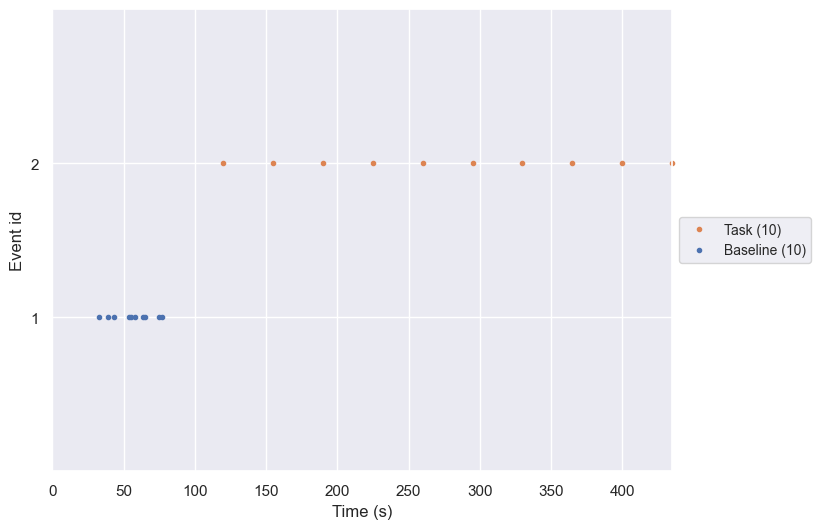

In [33]:
# Look at segments
events_synths, event_dict_synths = dict(), dict()
for i in range(n_set):
    events_synth, event_dict_synth = mne.events_from_annotations(raw_synths[i])
    events_synths[i] = events_synth
    event_dict_synths[i] = event_dict_synth
# Show events first raw object as example
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)
fig = mne.viz.plot_events(events_synths[0], event_id=event_dict_synths[0], sfreq=raw_synths[0].info['sfreq'])
if export:
    fig.savefig('events_synth.png')

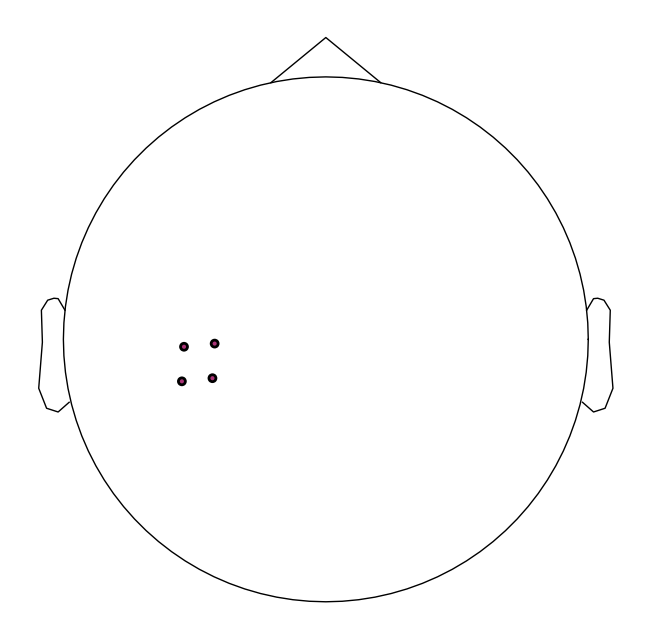

In [34]:
# Plot channels in 2D using build-in function of mne_nirs
sns.reset_defaults() # Turn of sns to be able to also plot contour of head
# dots = Center of channels
%matplotlib inline
fig = raw_synths[0].plot_sensors();
if export:
    fig.savefig('montage_synth.png')

In [35]:
sns.set_theme()

#### Introduce serial correlations by means of AR model <a class="anchor" id="sub_section_1_3_2"></a>

In [36]:
# Set constants 
sigma = 0.33 # Spatial correlation between channels
ar_order= 30 # Temporal correlation

In [37]:
# Define functions
def randAR(P):
    # random Pth order AR coef    
    a = np.flipud(np.cumsum(np.random.rand(P)))
    a = a / np.sum(a) * 0.99
    return a

def simARNoise(nchan, t, P=30, sigma=0.33):

    nsignal = nchan*2
    
    # noise mean and spatial covariance
    mu = np.zeros(nsignal)
    S = toeplitz([1] + [sigma] * (nsignal - 1))
    
    e = multivariate_normal.rvs(mean=mu, cov=S, size=len(t))

    # add temporal covariance
    for i in range(e.shape[1]):
        a = randAR(P)
        e[:, i] = lfilter([1], np.hstack([1, -a]), e[:, i])
    
    # output
    data = e * 5e-7 # How strong is the noise?
    data[:,1::2] = data[:,1::2]/2 # HbR values lower than HbO
    
    return data.T

In [38]:
# Set colored noise as data of raw object
for i in range(n_set):
    raw_synths[i]._data = simARNoise(nchan, t, ar_order, sigma)

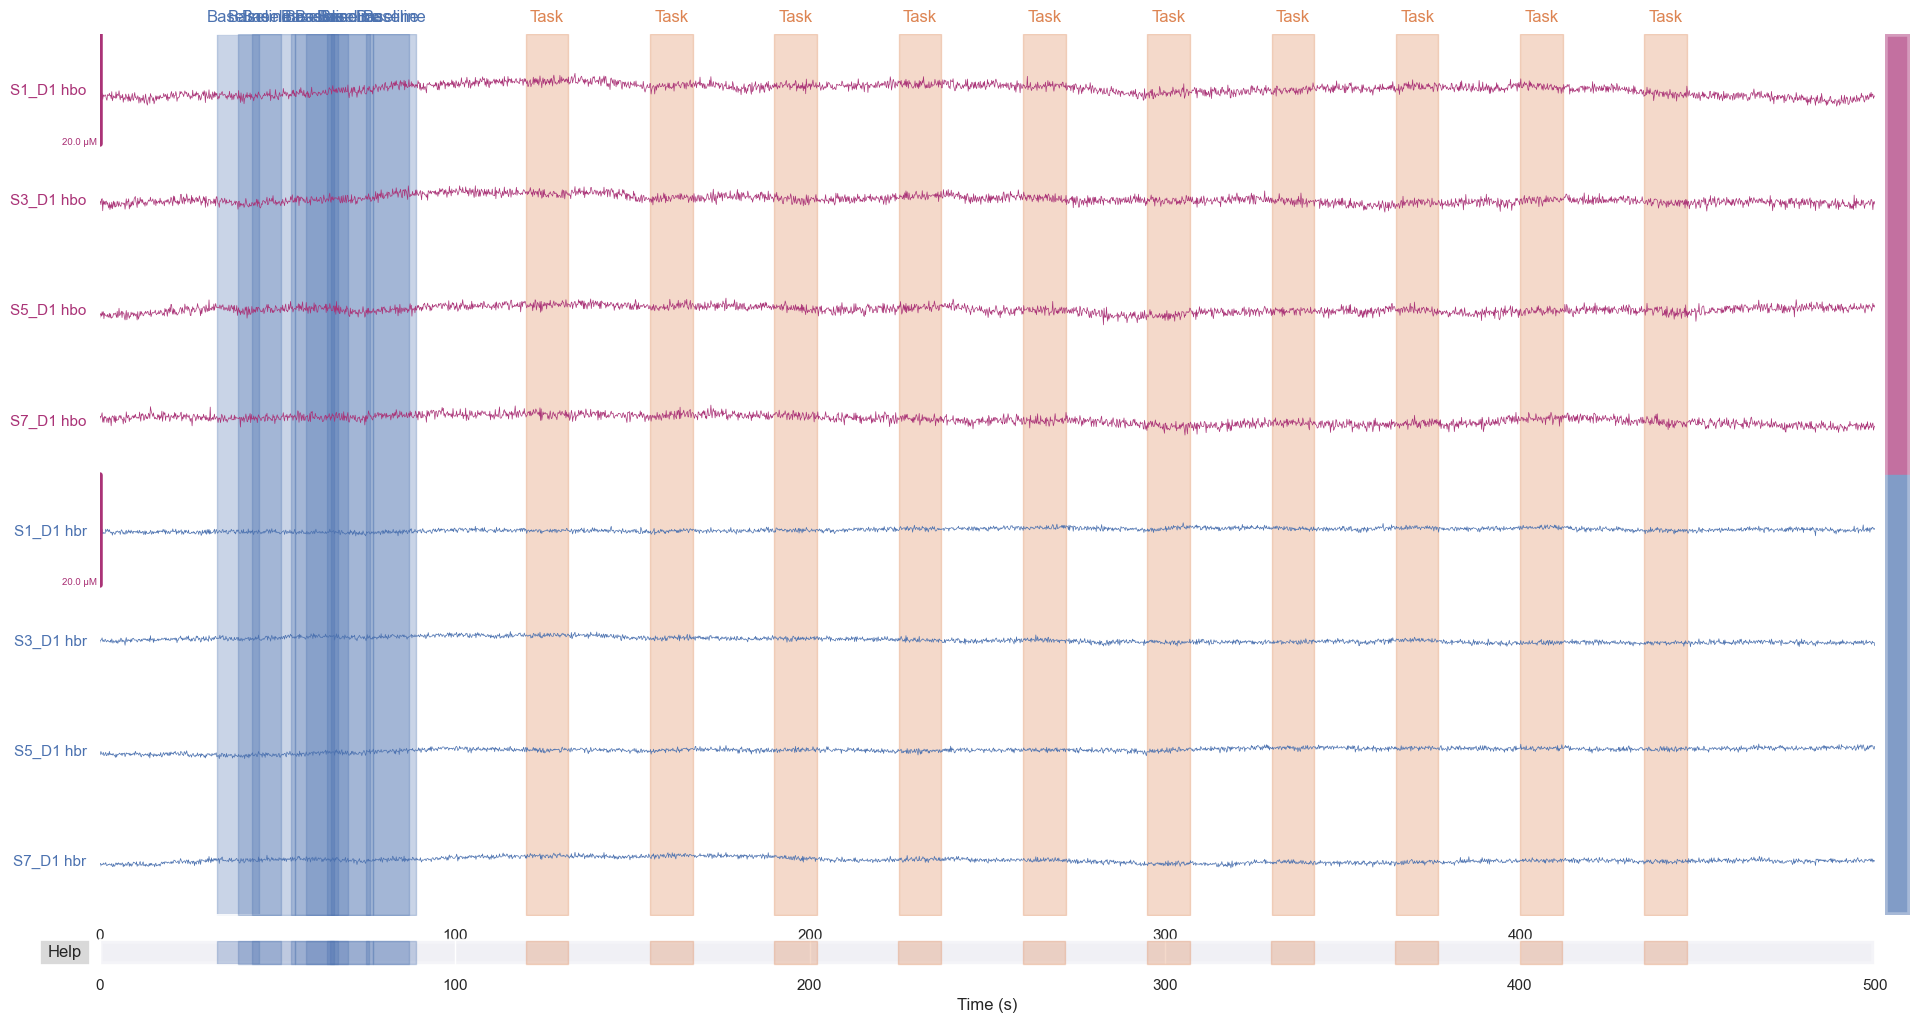

In [39]:
# Plot data
fig = raw_synths[0].plot(duration=totLength)
if export:
    fig.savefig('synth_colored_noise.png')

#### Introduce physiological confound <a class="anchor" id="sub_section_1_3_3"></a>

In [40]:
# Set constants
# Assume: heart rate ~1.3 Hz, respiration ~0.3 Hz, Meyer waves ~0.1 Hz
cardiacHz = 1.318
respHz = 0.3
mayerHz = 0.1

cardiacHz_sigma = 0.242
respHz_sigma = 0.1
mayerHz_sigma = 0.02

# Specify amplitudes
cardiac_amp = 0.4
resp_amp = 0.25
mayer_amp = 0.75

In [41]:
def simPhysioNoise_variableHz(raw_input, time, cardiac_amp=0.25, resp_amp=0.25, mayer_amp=0.25, cardiacHz=1.318, cardiacHz_sigma = 0.242, respHz=0.3, respHz_sigma = 0.1, mayerHz=0.1, mayerHz_sigma=0.2, plot = False, tmin = 0, tmax = 10, ppf = 6):
    raw = raw_input.copy()
    
    if (raw_synth.ch_names[0][-3:] != 'hbo') or (raw_synth.ch_names[1][-3:] != 'hbr'):
        raw = beer_lambert_law(raw, ppf)
    
    nsignal, nsamp = raw.get_data().shape
    nchan = int(nsignal/2)
    
    # Generate cardiac oscillations
    cardiac_freq = np.random.normal(loc=cardiacHz, scale=cardiacHz_sigma)
    cardiac_phase = np.cumsum(0.1 * np.random.randn(nsamp) * 2 * np.pi / raw.info['sfreq'])
    cardiac_data = np.sin(2 * np.pi * cardiac_freq * time + cardiac_phase)

    # Generate respiratory oscillations
    resp_freq = np.random.normal(loc=respHz, scale=respHz_sigma)
    resp_phase = np.cumsum(0.1 * np.random.randn(nsamp) * 2 * np.pi / raw.info['sfreq'])
    resp_data = np.sin(2 * np.pi * resp_freq * time + resp_phase)

    # Generate Mayer waves
    mayer_freq = np.random.normal(loc=mayerHz, scale=mayerHz_sigma)
    mayer_phase = np.cumsum(0.1 * np.random.randn(nsamp) * 2 * np.pi / raw.info['sfreq'])
    mayer_data = np.sin(2 * np.pi * mayer_freq * time + mayer_phase)

    # Extract data from raw object
    Y = raw.get_data()

    
    # Add physiological noise
    if plot:
        fig, axes = plt.subplots(nchan, 2, figsize=(14, 5*nchan), constrained_layout=True)
        fig.suptitle('Physiological noise introduction to synthetic data', fontweight = 'bold')
        
        for k, (chan, ax) in enumerate(zip(raw.ch_names, axes.flat)):
            color1 = 'm' if k%2 == 1 else 'orange'
            color2 = 'blue' if k%2 == 1 else 'red'
            ax.plot(t, 1e6*Y[k], '--', color = color1, label = 'original')
            sigma = np.std(Y[k], axis=0)
            Y[k]  += cardiac_amp * sigma * cardiac_data + resp_amp * sigma * resp_data + mayer_amp * sigma * mayer_data
            ax.plot(t, 1e6*Y[k], '-', color = color2, label = 'with physiological noise')
            ax.set_xlabel('time (s)')
            ax.set_ylabel('Concentration (microM)')
            ax.set_xlim(tmin, tmax)
            ax.set_title('Channel ' + chan)
            ax.legend()
    else:
        for k in range(nsignal):
            sigma = np.std(Y[k], axis=0)
            Y[k]  += cardiac_amp * sigma * cardiac_data + resp_amp * sigma * resp_data + mayer_amp * sigma * mayer_data
    
    # Load data back in raw object
    raw._data = Y

    return raw

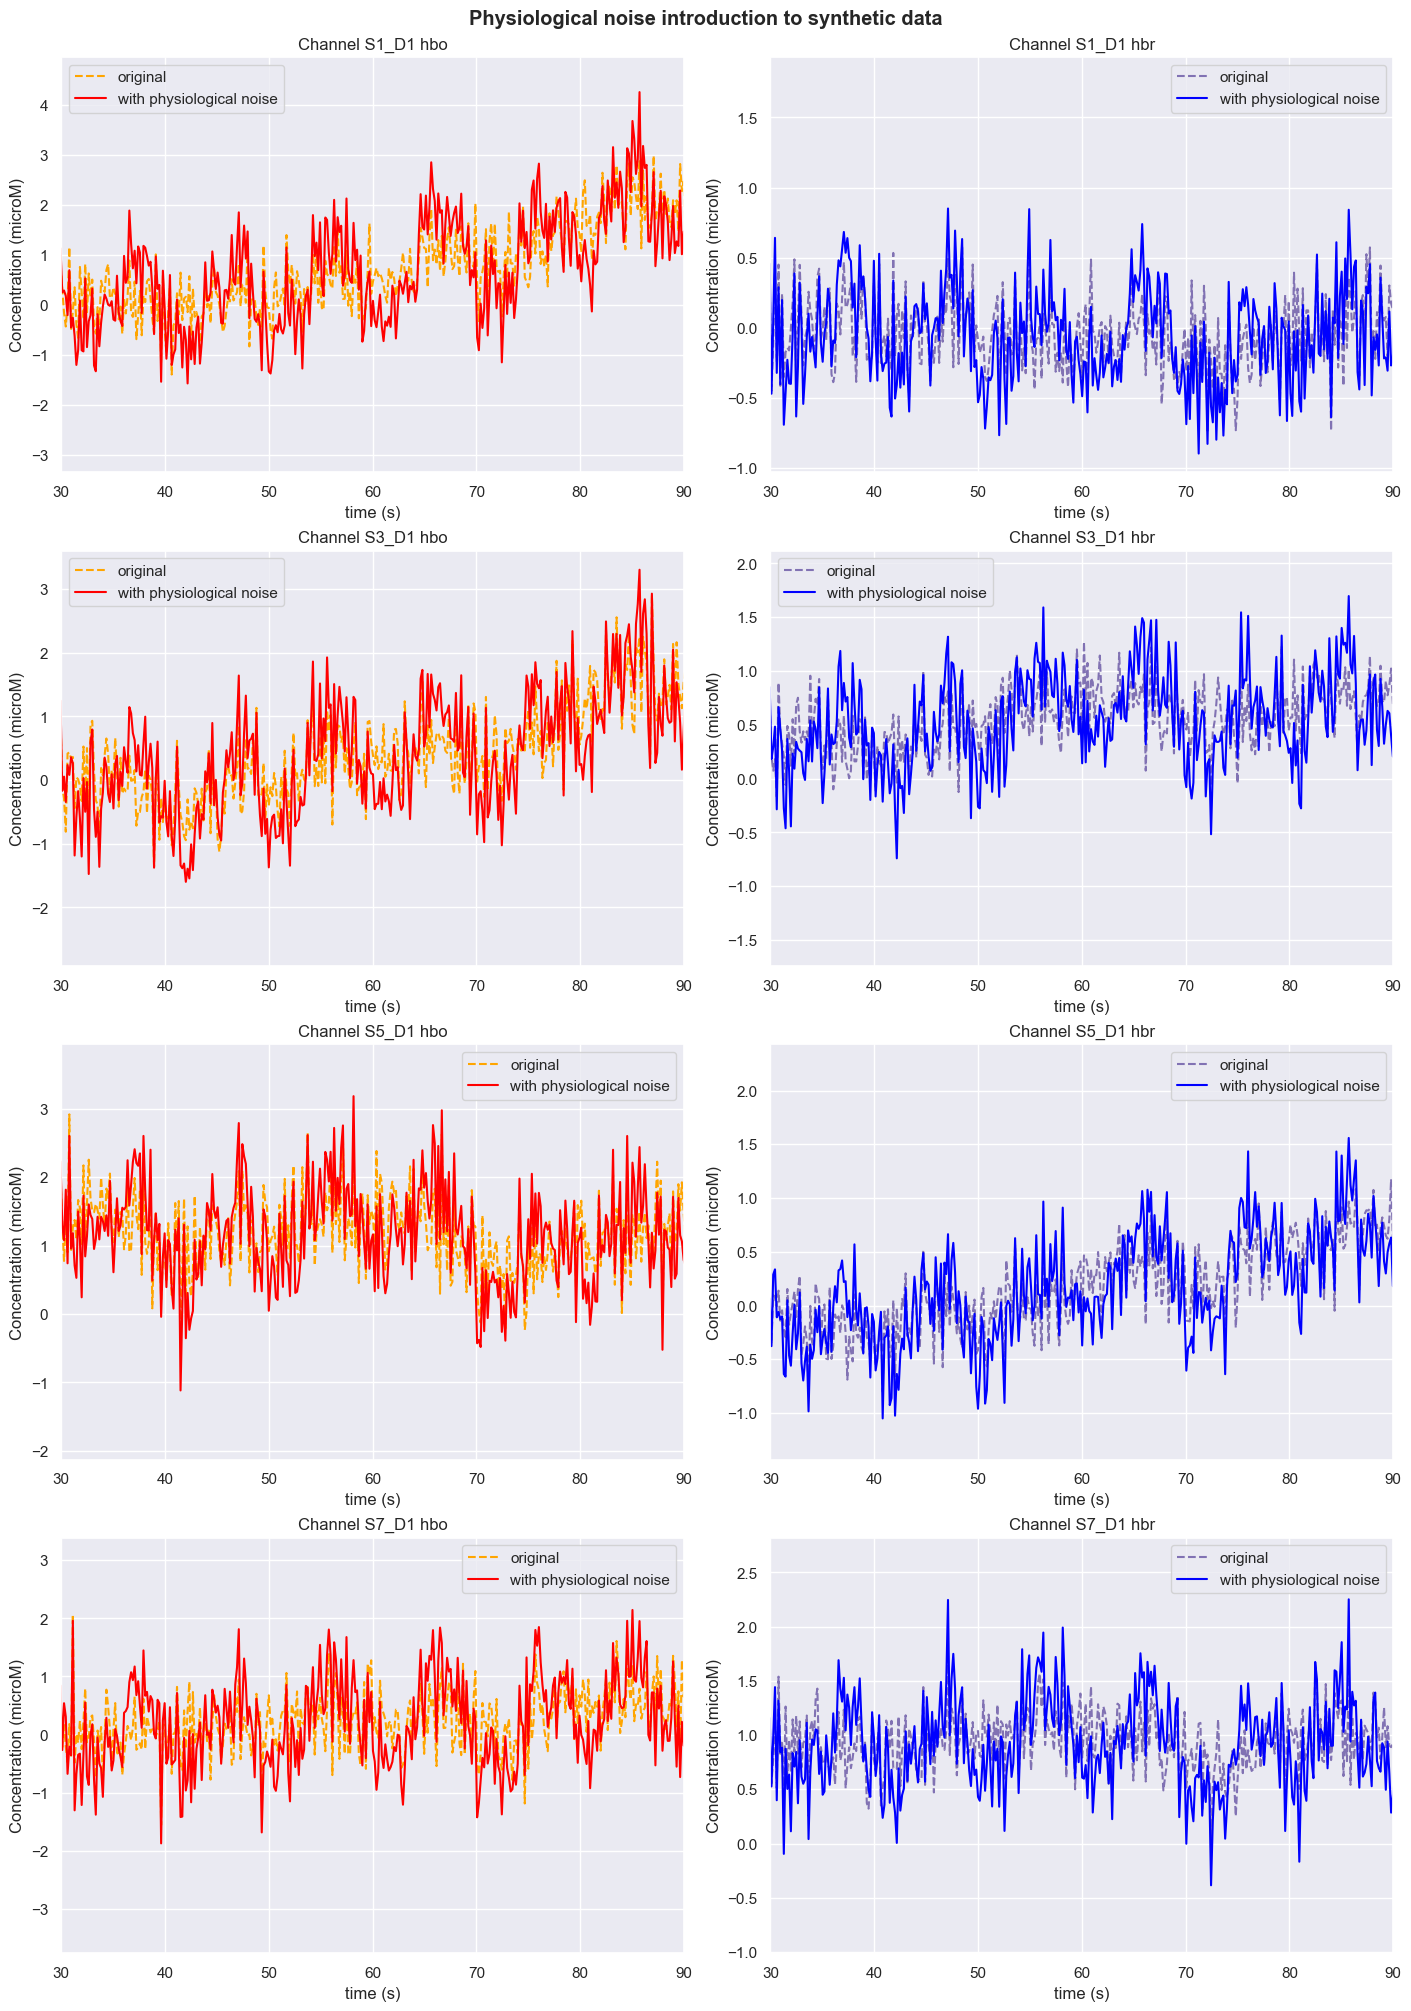

In [42]:
# Add physiological noise
raw_synth_physios = dict()
raw_synth_physios[0] = simPhysioNoise_variableHz(raw_synths[0], t, cardiac_amp, resp_amp, mayer_amp, cardiacHz, cardiacHz_sigma, respHz, respHz_sigma, mayerHz, mayerHz_sigma, plot = True, tmin = 30, tmax = 90, ppf = 6)
# Do not plot for all sets
for i in range(1, n_set):
    raw_synth_physios[i] = simPhysioNoise_variableHz(raw_synths[i], t, cardiac_amp, resp_amp, mayer_amp, cardiacHz, cardiacHz_sigma, respHz, respHz_sigma, mayerHz, mayerHz_sigma, plot = False, tmin = 30, tmax = 90, ppf = 6)

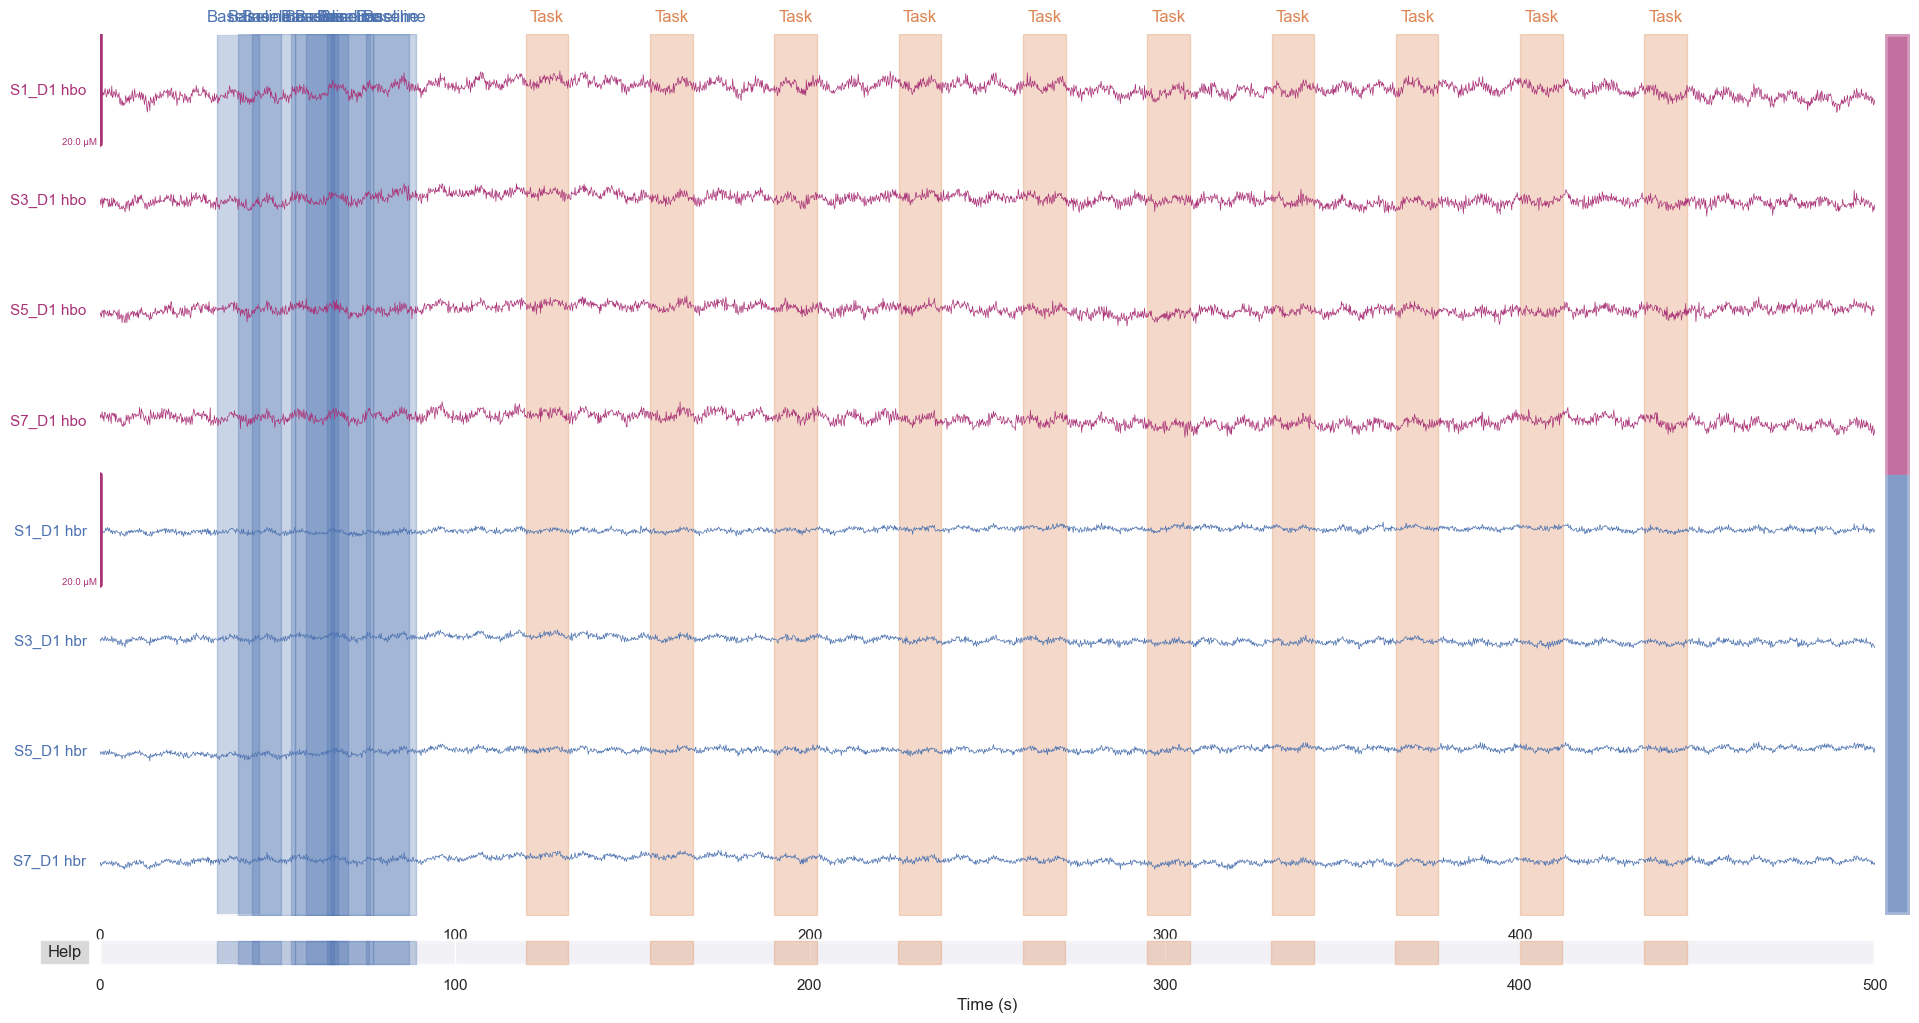

In [43]:
# Plot data
%matplotlib inline
fig = raw_synth_physios[0].copy().plot(duration=totLength)
if export:
    fig.savefig('synth_physio_noise.png')

#### Add synthetic HRFs <a class="anchor" id="sub_section_1_3_4"></a>

Use method of MNE-NIRS tutorial

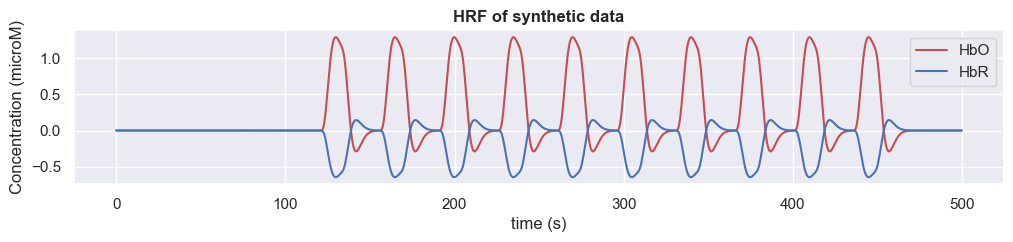

In [44]:
# Generate HRFs
design_matrix = make_first_level_design_matrix(raw_synth_physios[0], hrf_model='glover', drift_order=0, stim_dur=stimDur)

# Overwrite the first NIRS channel with the expected response.
# Rescale to be in expected units of uM.
hrf = raw_synth_physios[0].copy().pick(picks=[0])
hrf._data[0] = 1e-6 * (design_matrix['Task']).T

hrf_hbo = hrf.get_data()[0]
hrf_hbr = -hrf.get_data()[0]/2

# Plot HRFs
fig = plt.figure(figsize=(12,2))
plt.plot(t, 1e6*hrf_hbo, color = 'r', label = 'HbO')
plt.plot(t, 1e6*hrf_hbr, color = 'b', label = 'HbR')
plt.xlabel('time (s)')
plt.ylabel('Concentration (microM)')
plt.legend()
plt.title('HRF of synthetic data', fontweight = 'bold')
plt.plot()
if export:
    fig.savefig('synth_HRF.png')

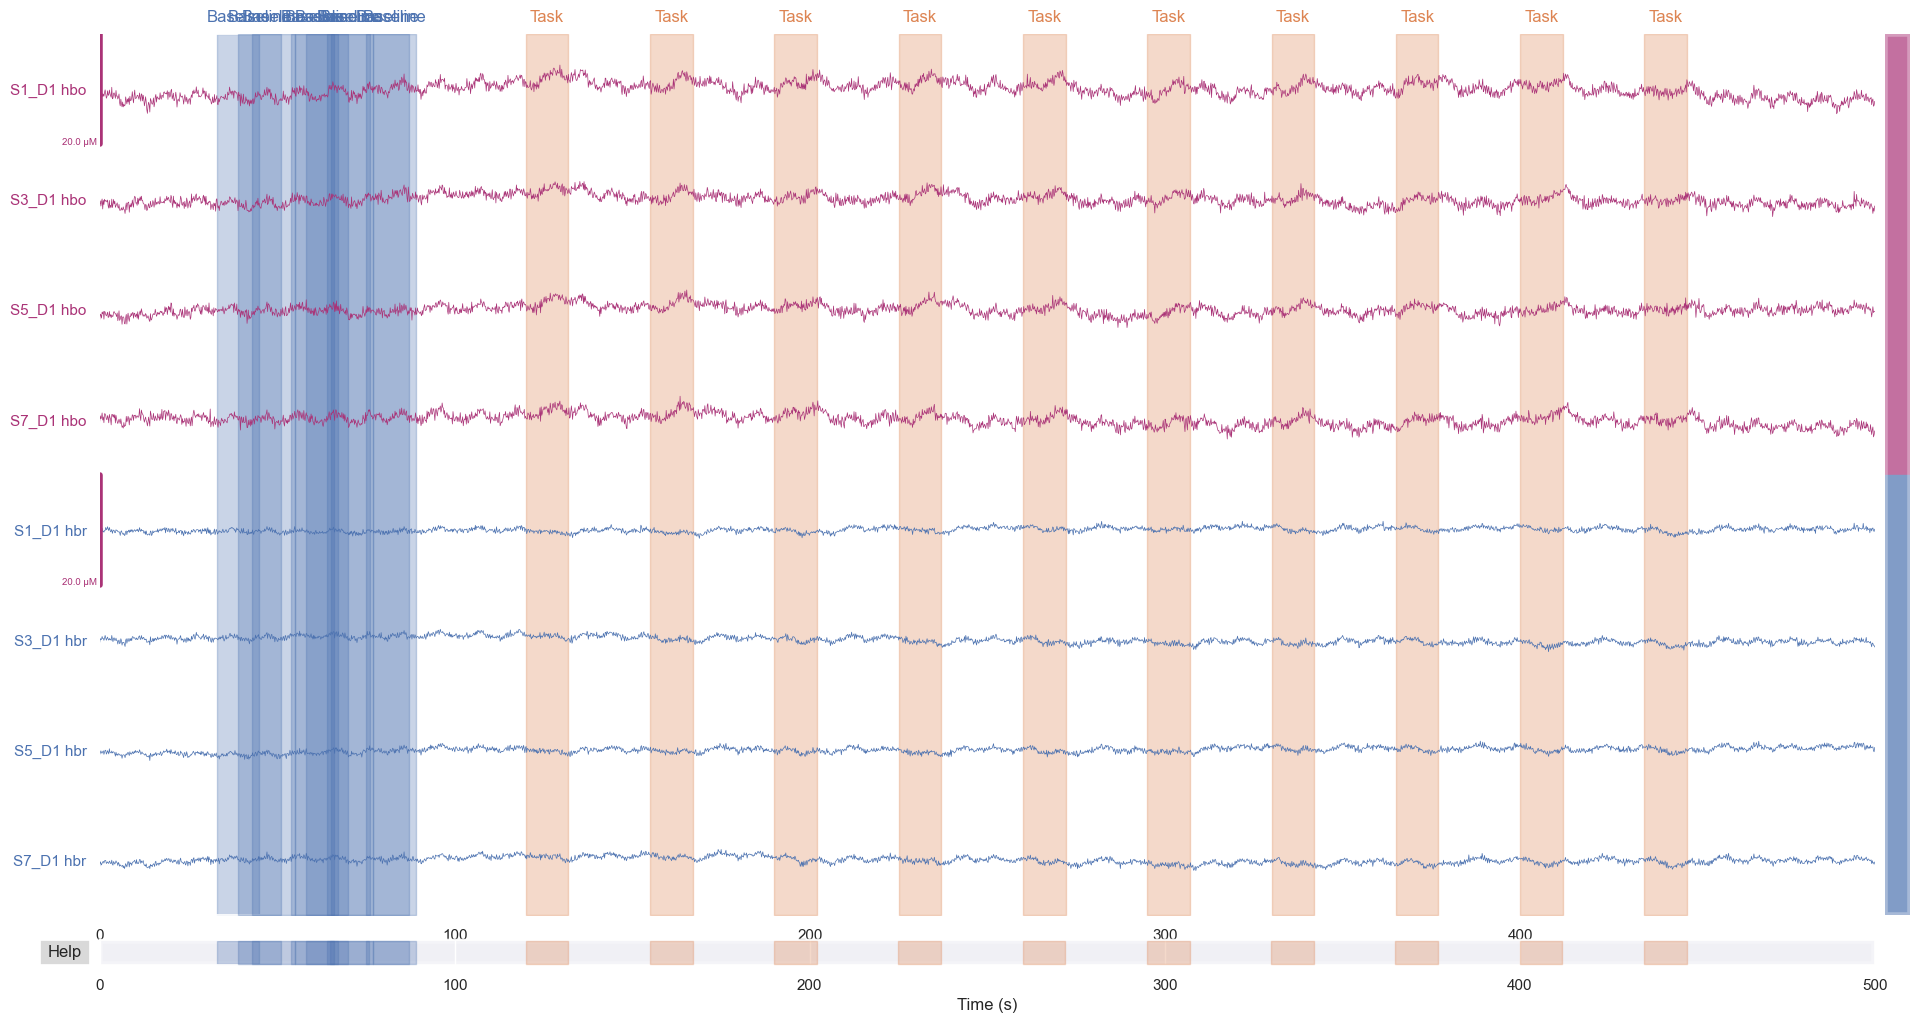

In [45]:
# Add HRF
hrf = np.zeros_like(raw_synth_physios[0].get_data())
hrf[::2,:] = hrf_hbo
hrf[1::2,:] = hrf_hbr
for i in range(n_set):
    raw_synth_physios[i]._data += hrf

fig = raw_synth_physios[0].plot(duration=totLength)
if export:
    fig.savefig('synth_HRF_added.png')

#### Introduce motion artefacts <a class="anchor" id="sub_section_1_3_5"></a>

###### Convert back to OD (took me a while to figure out)

In [46]:
def inverse_beer_lambert(raw_input, ppf = 6):
    """
    Converts HbO and HbR data to optical density data using the inverse Beer-Lambert Law.

    Parameters:
    raw
    ppf (float or ndarray): Partial pathlength factor(s).

    Returns:
    opt_density (ndarray): Optical density data.
    """
    raw = raw_input.copy()
    data = raw.get_data()
    
    picks = np.arange(len(raw.ch_names))
    distances = source_detector_distances(raw.info, picks="all")
    
    freqs = np.array([raw.info["chs"][pick]["loc"][9] for pick in picks], float)
    abs_coef = _load_absorption(freqs)
    
    ppf = np.array([ppf, ppf])

    rename = dict()
    # Calculate optical density  
    for ii, jj in zip(picks[::2], picks[1::2]):
        EL = abs_coef * distances[ii] * ppf
        iEL = np.linalg.pinv(EL)

        raw._data[[ii, jj]] = np.linalg.pinv(iEL) @ (raw._data[[ii, jj]] * 1e3)

        # Update channel information
        coil_dict = dict(hbo=FIFF.FIFFV_COIL_FNIRS_HBO, hbr=FIFF.FIFFV_COIL_FNIRS_HBR)
        for ki, kind in zip((ii, jj), ("760", "850")):
            ch = raw.info["chs"][ki]
            ch.update(coil_type=FIFF.FIFFV_COIL_FNIRS_OD, unit=FIFF.FIFF_UNIT_V)
            new_name = f'{ch["ch_name"].split(" ")[0]} {kind}'
            rename[ch["ch_name"]] = new_name
    raw.rename_channels(rename)


    return raw

In [47]:
raw_synth_physio_ods = dict()
for i in range(n_set):
    raw_synth_physio_ods[i] = inverse_beer_lambert(raw_synth_physios[i], ppf = ppf)

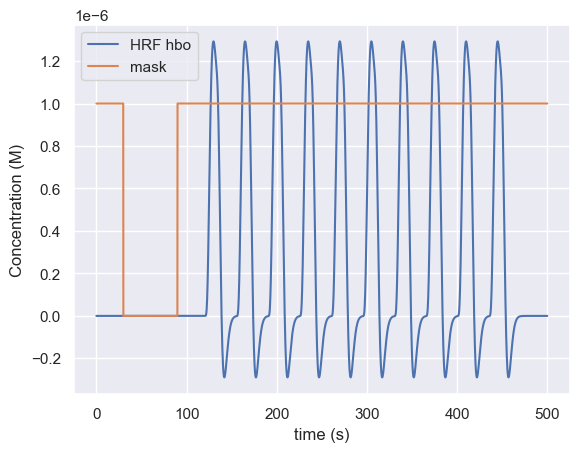

In [48]:
%matplotlib inline
# Where do you want the MAs to be? No artefacts during baseline (Participant is asked to sit still)
motion_mask = np.ones(tot_n_samples)
s_start = int(t_begin*sfreq)
s_end = int((t_begin + baseDur)*sfreq)
indices = np.arange(s_start, s_end)
motion_mask[indices] = 0
plt.plot(t, hrf_hbo, label =  'HRF hbo')
plt.plot(t, 1e-6*motion_mask, label = 'mask')
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('Concentration (M)')
plt.show()

In [49]:
# Set constants

# Frequency artefacts
spikes_per_minute = 3
shifts_per_minute = 1

# Amplitude artefacts (V)
amp_low_spike = 0.1
amp_high_spike = 0.5
amp_low_shift = 0.1
amp_high_shift = 0.5

# Define where the MAs are present
motion_mask = motion_mask

In [50]:
def sim_motion_artifact(raw_input, time, spikes_per_minute=3, shifts_per_minute=0.5, amp_low_spike = 0.1, amp_high_spike = 2, amp_low_shift = 0.1, amp_high_shift = 2, motion_mask=None):
    
    raw = raw_input.copy()
    data = raw.get_data()

    events_, event_dict_ = mne.events_from_annotations(raw)
    
    if motion_mask is None:
        motion_mask = np.ones_like(t, dtype=bool)

    num_spikes = int(round(spikes_per_minute * (time[-1] - time[0]) / 60))
    num_shifts = int(round(shifts_per_minute * (time[-1] - time[0]) / 60))

    valid_indices = np.where(motion_mask)[0]
    nsamp = len(valid_indices)
    inds = np.arange(0, nsamp)

    # MNE-NIRS can not handle two events at the same time
    # Convert event times to indices
    event_indices = np.intersect1d(valid_indices, events_[:, 0], assume_unique=True)
    
    # Exclude event indices from valid indices
    available_indices = np.setdiff1d(valid_indices, event_indices, assume_unique=True)
    
    # Select spike indices
    spike_inds = np.random.choice(available_indices, size=num_spikes, replace=False)
    
    # Remove spike indices from available indices for shift selection
    available_indices = np.setdiff1d(available_indices, spike_inds, assume_unique=True)
    
    # Select shift indices
    shift_inds = np.random.choice(available_indices, size=num_shifts, replace=False)

    spike_amp_Z = np.random.uniform(low=amp_low_spike, high=amp_high_spike, size=(len(data), num_spikes)) # Different amplitude for each channel
    shift_amp_Z = np.random.uniform(low=amp_low_shift, high=amp_high_shift, size=(len(data), num_spikes)) # Different amplitude for each channel

    mu = np.mean(data, axis = 1).reshape(-1, 1)
    # std = np.std(data, axis = 1).reshape(-1, 1)
    
    for i in range(num_spikes):
        width = 0.9 * np.random.rand() + 0.1  # Spike duration of 0.1-1 seconds

        t_peak = t[spike_inds[i]]
        t_start = t_peak - width / 2
        t_end = t_peak + width / 2
        t_inds = np.where((time > t_start) & (time < t_end))[0]
        amp = spike_amp_Z[:,i] * np.random.choice(np.array([-1,1])) # Positive or negative shift
        # amp = amp + (2 * np.random.rand(len(t_inds)) - 1) * 0.5 * amp  # Add temporal jitter

        spike_data = np.ones((len(data),len(t_inds))) * amp.reshape(-1, 1)
        t_inds = np.arange(t_inds[0], min(t_inds[0] + spike_data.shape[1], data.shape[1]))
        data[:,t_inds] = data[:,t_inds] + spike_data[:,:len(t_inds)]

        raw.annotations.append(t_start, width, 'Spike') # annotation during spike

    for i in range(num_shifts):
        shift_amt = shift_amp_Z[:,i] * np.random.choice(np.array([-1,1])) # Positive or negative shift
        data[:,shift_inds[i]:] = data[:,shift_inds[i]:] + shift_amt.reshape(-1, 1)

        raw.annotations.append(time[shift_inds[i]], 2, 'Shift') # 1 s annotation at baseline shift

    # Restore original mean intensity
    data = (data - np.mean(data, axis = 1).reshape(-1, 1)) + mu
    
    # Load data back in raw object
    raw._data = data
    return raw

In [51]:
raw_synth_physio_MAs = dict()
for i in range(n_set):
    raw_synth_physio_MAs[i] = sim_motion_artifact(raw_synth_physio_ods[i], t, spikes_per_minute, shifts_per_minute, amp_low_spike, amp_high_spike, amp_low_shift, amp_high_shift, motion_mask)

Used Annotations descriptions: ['Baseline', 'Task']
Used Annotations descriptions: ['Baseline', 'Task']
Used Annotations descriptions: ['Baseline', 'Task']
Used Annotations descriptions: ['Baseline', 'Task']
Used Annotations descriptions: ['Baseline', 'Task']
Used Annotations descriptions: ['Baseline', 'Task']
Used Annotations descriptions: ['Baseline', 'Task']
Used Annotations descriptions: ['Baseline', 'Task']
Used Annotations descriptions: ['Baseline', 'Task']
Used Annotations descriptions: ['Baseline', 'Task']


In [52]:
# Test if there are no duplicates in event data

for i in range(n_set):   
    events_, event_dict_ = mne.events_from_annotations(raw_synth_physio_MAs[i])
    while len(find_duplicates_with_set(events_[:,0])) > 0:
        print('Set: ' + str(i))
        print('Duplicates are at timepoint: ' + str(np.array(find_duplicates_with_set(events_[:,0]))/sfreq))
        raw_synth_physio_MAs[i] = sim_motion_artifact(raw_synth_physio_ods[i], t, spikes_per_minute, shifts_per_minute, amp_low_spike, amp_high_spike, amp_low_shift, amp_high_shift, motion_mask)
        events_, event_dict_ = mne.events_from_annotations(raw_synth_physio_MAs[i])

Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Set: 3
Duplicates are at timepoint: [189.96598639]
Used Annotations descriptions: ['Baseline', 'Task']
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Set: 3
Duplicates are at timepoint: [295.06802721]
Used Annotations descriptions: ['Baseline', 'Task']
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Set: 6
Duplicates are at timepoint: [329.93197279]
Used Annotations descriptions: ['Baseline', 'Task']
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike',

In [53]:
# Test if there are no duplicates in event data
for i in range(n_set):   
    events_, event_dict_ = mne.events_from_annotations(raw_synth_physio_MAs[i])
    if len(find_duplicates_with_set(events_[:,0])) > 0:
        raise Exception('Set ' + str(i) + ' still contains uplicates at timepoint(s): ' + str(np.array(find_duplicates_with_set(events_[:,0]))/sfreq))

Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']


In [54]:
# Use to rerun a set if there are duplicates
raw_synth_physio_MAs[3] = sim_motion_artifact(raw_synth_physio_ods[5], t, spikes_per_minute, shifts_per_minute, amp_low_spike, amp_high_spike, amp_low_shift, amp_high_shift, motion_mask)

Used Annotations descriptions: ['Baseline', 'Task']


#### Inspect signal quality <a class="anchor" id="sub_section_1_3_6"></a>

In [55]:
raw_synth_od_unfiltereds = dict()
raw_synth_od_cleans = dict()
for i in range(n_set):
    raw_synth_od_unfiltereds[i] = raw_synth_physio_MAs[i].copy()
    raw_synth_od_cleans[i] = raw_synth_physio_ods[i].copy()

Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']


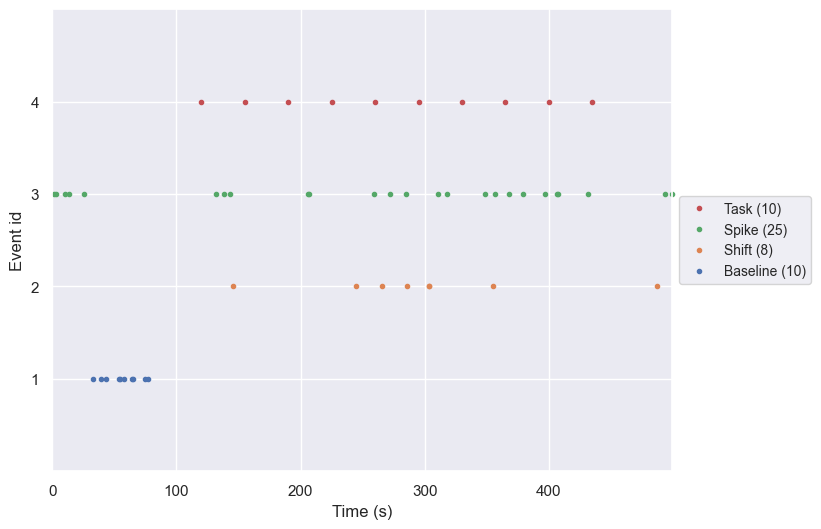

In [56]:
%matplotlib inline
sns.set()
# Look at segments
for i in range(n_set):
    events_synths[i], event_dict_synths[i] = mne.events_from_annotations(raw_synth_od_unfiltereds[i])
# Plot for first element
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)
fig = mne.viz.plot_events(events_synths[0], event_id=event_dict_synths[0], sfreq=raw_synth_od_unfiltereds[0].info['sfreq'])
if export:
    fig.savefig('events_synth_MA.png')

##### Visual inspection (example on first set)

In [57]:
if plot:
    %matplotlib qt
    raw_synth_od_unfiltereds[0].plot(duration=120, show_scrollbars = True, clipping = None);

---
> *Remark:*
- Clear spikes and baseline shifts at the expected locations
- Different amplitudes per channel
- Positive and negatibe amplitudes
- Relatively large amplitude of signal and artefacts
---

##### SCI

In [58]:
# Calculate SCI with build-in function of mne_nirs
sci_synth_unfiltered = scalp_coupling_index(raw_synth_od_unfiltereds[0], l_freq=0.7, h_freq=1.5, l_trans_bandwidth=0.3, h_trans_bandwidth=0.3, verbose=False)
# SCI bandpasses the signal with a FIR filter: l_freq=0.7, h_freq=1.5, l_trans_bandwidth=0.3, h_trans_bandwidth=0.3

# Copy raw object to apply SCI 
raw_synth_od_unfiltered_SCI = raw_synth_od_unfiltereds[0].copy()
# Mark channels with SCI < 0.75 as BAD
raw_synth_od_unfiltered_SCI.info['bads'] = list(compress(raw_synth_od_unfiltereds[0].ch_names, sci_synth_unfiltered < 0.75)) # 0.75 RECOMMENDED BY Pollonini et al. (2013)
print('The ' + str(len(raw_synth_od_unfiltered_SCI.info['bads'])) + ' bad channels are: ' + str(raw_synth_od_unfiltered_SCI.info['bads']))

The 0 bad channels are: []


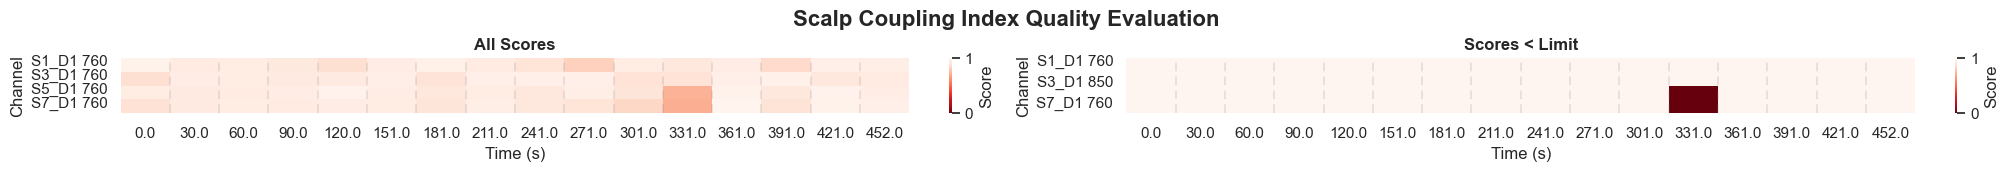

In [59]:
# Calculate windowed SCI with windows of 30 s
_, scores, times = scalp_coupling_index_windowed(raw_synth_od_unfiltered_SCI, time_window=30)

%matplotlib inline
# Plot
plot_timechannel_quality_metric(raw_synth_od_unfiltered_SCI, scores, times, threshold=0.75, title="Scalp Coupling Index Quality Evaluation");

---
> *Remark:*
- SCI score is good for all channels over the whole recording
---

##### PSP

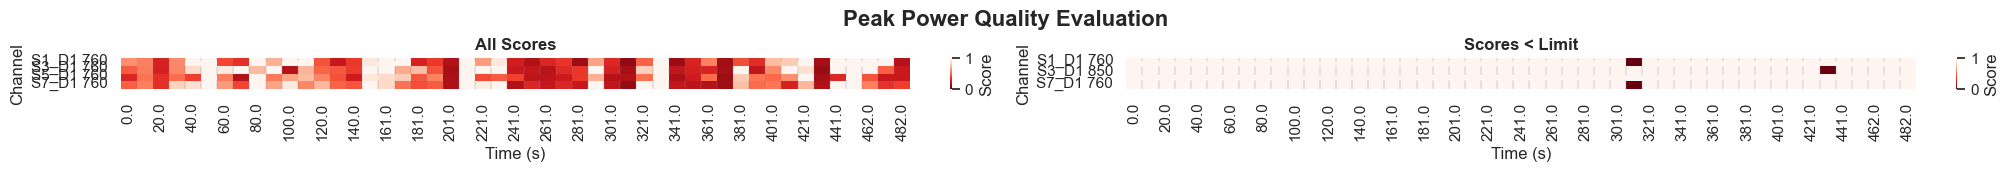

In [60]:
# View instances where a subset of channels may be contaminated by artifacts for a short duration of the recording
raw_synth_od_unfiltered_SCI_PSP, scores, times = peak_power(raw_synth_od_unfiltered_SCI, time_window=10)

# Plot
%matplotlib inline
fig = plot_timechannel_quality_metric(raw_synth_od_unfiltered_SCI_PSP, scores, times, threshold=0.1, title="Peak Power Quality Evaluation") #see PHOEBE
if export:
    fig.savefig('synth_PSP.png')

---
> *Remark:*
- PSP score is good for all channels over the whole recording
- Strange?
---

##### Convert to haemodynamic concentration

To be able to test motion artefact correction methods that can only be applied to the haemoglobin concentration data, the unfiltered synthetic optical density data is transformed to haemodynamic concentration data with the help of the Beer-Lambert law.

In [61]:
raw_synth_haemo_unfiltereds = dict()
raw_synth_haemo_cleans = dict()
for i in range(n_set):
    raw_synth_haemo_unfiltereds[i] = beer_lambert_law(raw_synth_od_unfiltereds[i], ppf=ppf)
    raw_synth_haemo_cleans[i] = beer_lambert_law(raw_synth_od_cleans[i], ppf=ppf)

In [62]:
# Plot concentrations
if plot:
    %matplotlib qt
    raw_synth_haemo_cleans[0].plot(duration=60, show_scrollbars = True, clipping = None);

In [63]:
# Plot concentrations
if plot:
    %matplotlib qt
    raw_synth_haemo_unfiltereds[0].plot(duration=60, show_scrollbars = True, clipping = None);

### Create evaluation metrics <a class="anchor" id="section_1_4"></a>

Evaluating the performance of artifact correction techniques in fNIRS is critical for ensuring the accuracy and reliability of the data analysis. These evaluation metrics can be broadly categorized into those that require a ground truth and those that do not.

#### Metrics requiring ground truth <a class="anchor" id="sub_section_1_4_1"></a>
Metrics requiring a ground truth rely on synthetic fNIRS data, where artifacts are introduced into a clean signal. This approach allows for a direct comparison between the corrected and the original clean signal to measure the effectiveness of the artifact removal.

##### Signal-to-noise ratio

The method pioneered by Izzetoglu et al. (2005) uses the difference between the estimation SNR ($SNR_e$) and the input SNR ($SNR_i$):
$$  \Delta SNR = SNR_e - SNR_i = 10 \log_{10} (\frac{var(x)}{var(\hat{x}-x)}) - 10 \log_{10} (\frac{var(x)}{var(z-x)}) $$
Where, the operator $var(\cdot)$ denotes the variance of the variable in the parentheses, $z$ denotes the measured fNIRS signal, $x$ the motionless fNIRS signal and $\hat{x}$ the estimated motionless fNIRS signal.

If the filter effectively eliminates MAs in $z$, then $\Delta SNR \rightarrow +\infty$. When $\Delta SNR < 0$, the filter amplifies the artifacts in the measured signal. Otherwise, the filter is able to partially mitigate the MAs. The greater the $\Delta SNR$, the better the filter’s performance in reducing MAs.

In [64]:
def get_DeltaSNR(raw_clean, raw_filtered, raw_unfiltered, plot = False, export = False, filename = None):
    """
    Input:
    - clean raw OD object
    - filtered raw OD object
    - unfiltered raw OD object 
    Output:
    - DeltaSNR value per channel
    """
    
    x = raw_clean.copy().get_data()
    x_hat =  raw_filtered.copy().get_data()
    z = raw_unfiltered.copy().get_data()
    
    SNR_e = 10 * np.log10(np.var(x, axis = 1)/np.var(x_hat-x, axis = 1))
    SNR_i = 10 * np.log10(np.var(x, axis = 1)/np.var(z-x, axis = 1))
    DeltaSNR = SNR_e - SNR_i

    if plot:
        %matplotlib inline
        y_pos = range(len(raw_clean.ch_names))
        fig = plt.figure(figsize=(12,6))
        plt.bar(y_pos, DeltaSNR)
        # Rotation of the bars names
        plt.xticks(y_pos, raw_clean.ch_names, rotation=90)
        plt.xlabel('Channel name')
        plt.ylabel('SNR value (dB)')
        plt.title('SNR per channel')
        plt.show()
        if export:
            if filename == None:
                raise ValeError('Add filename')
            fig.savefig('DeltaSNR/' + filename + '.png')

    return DeltaSNR

##### Percent root difference

The percentage root-mean-square difference (PRD) quantifies the degree of similarity between two signals (as described by Scholkmann et al., 2010). When $x$ is again used as the motionless signal and $\hat{x}$ represents the signal after applying the correction method, the PRD is defined as follows:

$$ PRD = 100\% \times \sqrt{\frac{\sum_{i=1}^{N} (\hat{x}_i - x_i)^2}{\sum_{i=1}^{N} x_i^2}} $$

The lower the PRD value, the more closely the filtered signals correspond to the artifact-free signals, indicating that fewer artifacts remain in the filtered data.

In [65]:
def get_PRD(raw_clean, raw_filtered, raw_unfiltered, plot = False, export = False, filename = None):
    """
    Input:
    - clean raw OD object
    - filtered raw OD object
    - unfiltered raw OD object 
    Output:
    - PRD value per channel
    """
    
    x = raw_clean.copy().get_data()
    x_hat =  raw_filtered.copy().get_data()
    z = raw_unfiltered.copy().get_data()

    PRD = 100*np.sqrt(np.sum((x_hat - x)**2, axis = 1)/np.sum(x**2, axis = 1))

    if plot:
        %matplotlib inline
        y_pos = range(len(raw_clean.ch_names))
        fig = plt.figure(figsize=(12,6))
        plt.bar(y_pos, PRD)
        # Rotation of the bars names
        plt.xticks(y_pos, raw_clean.ch_names, rotation=90)
        plt.xlabel('Channel name')
        plt.ylabel('PRD value (%)')
        plt.title('PRD per channel')
        plt.show()
        if export:
            if filename == None:
                raise ValeError('Add filename')
            fig.savefig('PRD/' + filename + '.png')
            
    return PRD

##### Correlation coefficient

This approach determines the difference in the correlation coefficient ($\Delta CC$) (as described by Izzetoglu et al., 2005) by comparing the estimated correlation coefficient with the original input correlation coefficient, defined as:

$$  \Delta CC= corr(\hat{x}, x) - \text{corr}(z, x) $$

Where, $corr(\cdot, \cdot)$ denotes the correlation between the two variables in the parentheses. Typically, the second term approaches zero. $\Delta CC < 0$ indicates that the filter has significantly distorted the motionless signal. Conversely, as $\Delta CC$ approaches one, the distortion in the filtered signal decreases.

In [66]:
def get_DeltaCC(raw_clean, raw_filtered, raw_unfiltered, plot = False, export = False, filename = None):
    """
    Input:
    - clean raw OD object
    - filtered raw OD object
    - unfiltered raw OD object 
    Output:
    - DeltaCC value per channel
    """

    x = raw_clean.copy().get_data()
    x_hat =  raw_filtered.copy().get_data()
    z = raw_unfiltered.copy().get_data()

    DeltaCC = np.zeros(len(x))
    for chan in range(len(x)):
        DeltaCC[chan] = pearsonr(x_hat[chan], x[chan])[0] - pearsonr(z[chan], x[chan])[0] # Use pearson r correlation

    if plot:
        %matplotlib inline
        y_pos = range(len(raw_clean.ch_names))
        fig = plt.figure(figsize=(12,6))
        plt.bar(y_pos, DeltaCC)
        # Rotation of the bars names
        plt.xticks(y_pos, raw_clean.ch_names, rotation=90)
        plt.xlabel('Channel name')
        plt.ylabel('DeltaCC value')
        plt.title('DeltaCC per channel')
        plt.show()
        if export:
            if filename == None:
                raise ValeError('Add filename')
            fig.savefig('DeltaCC/' + filename + '.png')
            
    return DeltaCC

#### Metrics not requiring ground truth <a class="anchor" id="sub_section_1_4_2"></a>

Metrics not requiring a ground truth can be applied directly to real fNIRS data, assessing the performance of correction techniques without needing an ideal reference signal. These metrics often focus on the statistical properties and consistency of the corrected data.

##### Contrast-to-noise ratio

Cooper et al. (2012) calculated the CNR of the recovered HRF (after block-averaging) of the filtered signal to assess the performance  of MA correction methods. The CNR was calculated by taking the mean of the 2 s of recovered HRF data centered at the true HRF peak
time and dividing by the standard deviation of the 5 s of data prior to onset. 

As the experiment design of the motion artefact experiment does induce activation of the SM1, no HRF is expected to be found in the recording, and therefore the method proposed by Cooper et al. (2012) can only be performed on the synthetic data.

In [67]:
def get_CNR_Cooper(raw_haemo_filtered, raw_haemo_unfiltered, reject_criteria = dict(hbo=80e-6), tmin = -5, tmax = 15, t_peak = 7, real_HRF= None, plot = False, export = False, filename = None):
    """
    Based on HRF!
    Input:
    - filtered raw haemo object
    - unfiltered raw haemo object 
    Output:
    - CNR value per channel 
    """

    raw_haemo_filtered_, raw_haemo_unfiltered_ = raw_haemo_filtered.copy(), raw_haemo_unfiltered.copy()
    events_, event_dict_ = mne.events_from_annotations(raw_haemo_filtered_)
    
    # Create epochs
    epochs_filtered = mne.Epochs(raw_haemo_filtered_, events_, event_dict_, tmin, tmax, preload=True, reject=reject_criteria, reject_by_annotation=True, baseline=(None, 0))
    epochs_unfiltered = mne.Epochs(raw_haemo_unfiltered_, events_, event_dict_, tmin, tmax, preload=True, reject=reject_criteria, reject_by_annotation=True, baseline=(None, 0))
    
    HRF_hbo_filtered = epochs_filtered["Task"].average(picks="hbo").get_data()
    HRF_hbo_unfiltered = epochs_unfiltered["Task"].average(picks="hbo").get_data()

    HRF_hbr_filtered = epochs_filtered["Task"].average(picks="hbr").get_data()
    HRF_hbr_unfiltered = epochs_unfiltered["Task"].average(picks="hbr").get_data()
    
    if plot:   
        t = np.arange(HRF_hbo_filtered.shape[1])/raw_haemo_filtered_.info['sfreq'] + tmin
        for chan in range(len(HRF_hbo_filtered)):
            plt.vlines([t_peak-1, t_peak+1], linestyle = '-.', ymin = np.min(1e6*HRF_hbr_unfiltered[chan])-1, ymax = np.max(1e6*HRF_hbo_unfiltered[chan])+1, label = '2 seconds interval around peak HRF', color = 'k')
            plt.vlines([-5, 0], linestyle = '-.', ymin = np.min(1e6*HRF_hbr_unfiltered[chan])-1, ymax = np.max(1e6*HRF_hbo_unfiltered[chan])+1, label = '5 seconds interval before onset stimulus', color = 'orange')
            plt.plot(t, 1e6*HRF_hbo_filtered[chan], label = 'HRF hbo filtered', color = 'r')
            plt.plot(t, 1e6*HRF_hbr_filtered[chan], label = 'HRF hbr filtered', color = 'b')
            plt.plot(t, 1e6*HRF_hbo_unfiltered[chan], '--', label = 'HRF hbo unfiltered', color = 'r')
            plt.plot(t, 1e6*HRF_hbr_unfiltered[chan], '--', label = 'HRF hbr unfiltered', color = 'b')
            if not real_HRF.all() == None:
                plt.plot(t, 1e6*real_HRF, '-.', label = 'real HRF hbo', color = 'r')
                plt.plot(t, -5e5*real_HRF, '-.', label = 'real HRF hbr', color = 'b')
            plt.xlabel('time (s)')
            plt.ylabel('Concentration (µM)')
            plt.title('Channel ' + str(chan+1))
            plt.legend()
            plt.show()
            if export:
                if filename == None:
                    raise ValeError('Add filename')
                plt.savefig('CNR_Cooper_functioning_' + filename + '.png')

    mean_HRF_peak_filtered = np.mean(epochs_filtered["Task"].crop(t_peak-1,t_peak+1).average(picks="hbo").get_data(), axis = 1)
    std_baseline_filtered = np.std(epochs_filtered["Task"].crop(-5,0).average(picks="hbo").get_data(), axis = 1)

    CNR_filtered = mean_HRF_peak_filtered/std_baseline_filtered

    mean_HRF_peak_unfiltered = np.mean(epochs_unfiltered["Task"].crop(t_peak-1,t_peak+1).average(picks="hbo").get_data(), axis = 1)
    std_baseline_unfiltered = np.std(epochs_unfiltered["Task"].crop(-5,0).average(picks="hbo").get_data(), axis = 1)

    CNR_unfiltered = mean_HRF_peak_unfiltered/std_baseline_unfiltered    

    if plot:
        %matplotlib inline
        x_pos = np.arange(len(CNR_filtered))
        width = 0.2
        fig = plt.figure(figsize=(12,6))
        plt.bar(x_pos - width/2, CNR_filtered, width=width, label='Filtered')
        plt.bar(x_pos + width/2, CNR_unfiltered, width=width, label='Unfiltered')
        # Rotation of the bars names
        plt.xticks(x_pos, raw_haemo_filtered_.ch_names[::2], rotation=90)
        plt.xlabel('Channel name')
        plt.ylabel('CNR (Cooper) value')
        plt.title('CNR (Cooper) per channel')
        plt.legend()
        plt.show()
        if export:
            if filename == None:
                raise ValeError('Add filename')
            fig.savefig('CNR_C/' + filename + '.png')
            
    return CNR_filtered

---
Alternatively, the method of Zhang et al. (2005) can be used. In this case, the CNR is calculated using the following formula:
$$   CNR = \frac{\bar{\hat{x}}_{dur} - \bar{\hat{x}}_{pre}}{\sqrt{\sigma^2_{dur} + \sigma^2_{pre} + \epsilon}} $$
Where $\sigma_{dur}$ and $\sigma_{pre}$ represent the standard deviations of the filtered fNIRS signals during and before the stimulus, respectively, and $\epsilon$ is a small non-negative constant to account for channels with minimal stimulus response but low baseline activity. Empirically, $\epsilon$ is often set to $0.1 \mu M$.  

Zhang et al. (2005) defined the pre-stimulus interval, denoted as $pre$, from -10 to 0 seconds relative to the stimulus onset. The during-stimulus interval, denoted as $dur$, was defined as the 10-second period from 5 to 15 seconds after the stimulus onset. These intervals were determined based on block-averaged time courses.

When MAs are present, the CNR map may display as all active or negative channels, with active and inactive regions spread throughout. Proper removal of MAs yields CNR maps with more distinct active zones.

In [68]:
def get_CNR_Zhang(raw_haemo_filtered, raw_haemo_unfiltered, reject_criteria = dict(hbo=80e-6), epsilon = 1e-7, plot = False, export = False, filename = None):
    """
    Input:
    - filtered raw haemo object
    - unfiltered raw haemo object
    Output:
    - CNR value per channel
    """

    raw_haemo_filtered_, raw_haemo_unfiltered_ = raw_haemo_filtered.copy(), raw_haemo_unfiltered.copy() 
    events_, event_dict_ = mne.events_from_annotations(raw_haemo_filtered_)
    
    tmin = -15
    tmax = 20

    # Create epochs
    epochs_filtered = mne.Epochs(raw_haemo_filtered_, events_, event_dict_, tmin, tmax, preload=True, reject=reject_criteria, reject_by_annotation=True, baseline=(None, 0))
    epochs_unfiltered = mne.Epochs(raw_haemo_unfiltered_, events_, event_dict_, tmin, tmax, preload=True, reject=reject_criteria, reject_by_annotation=True, baseline=(None, 0))

    # Take pre and dur segment
    HRF_hbo_pre_filtered = epochs_filtered["Task"].average(picks="hbo").copy().crop(-10,0).get_data()
    HRF_hbo_dur_filtered = epochs_filtered["Task"].average(picks="hbr").copy().crop(5,15).get_data()

    HRF_hbo_pre_unfiltered = epochs_unfiltered["Task"].average(picks="hbo").copy().crop(-10,0).get_data()
    HRF_hbo_dur_unfiltered = epochs_unfiltered["Task"].average(picks="hbr").copy().crop(5,15).get_data()

    CNR_filtered = (np.mean(HRF_hbo_dur_filtered, axis = 1) - np.mean(HRF_hbo_pre_filtered, axis = 1))/np.sqrt(np.var(HRF_hbo_dur_filtered, axis = 1) + np.var(HRF_hbo_pre_filtered, axis = 1) + epsilon)
    CNR_unfiltered = (np.mean(HRF_hbo_dur_unfiltered, axis = 1) - np.mean(HRF_hbo_pre_unfiltered, axis = 1))/np.sqrt(np.var(HRF_hbo_dur_unfiltered, axis = 1) + np.var(HRF_hbo_pre_unfiltered, axis = 1) + epsilon)
    
    if plot:
        %matplotlib inline
        x_pos = np.arange(len(CNR_filtered))
        width = 0.2
        fig = plt.figure(figsize=(12,6))
        plt.bar(x_pos - width/2, CNR_filtered, width=width, label='Filtered')
        plt.bar(x_pos + width/2, CNR_unfiltered, width=width, label='Unfiltered')
        # Rotation of the bars names
        plt.xticks(x_pos, raw_haemo_filtered_.ch_names[::2], rotation=90)
        plt.xlabel('Channel name')
        plt.ylabel('CNR (Zhang) value')
        plt.title('CNR (Zhang) per channel')
        plt.legend()
        plt.show()
        if export:
            if filename == None:
                raise ValeError('Add filename')
            fig.savefig('CNR_Z/' + filename + '.png')
            
    return CNR_filtered

##### Artifact power attenuation 

Artifact power attenuation (APA) measures the extent to which artifacts in the measured signal are suppressed in the signal of interest within the affected segments (Molavi et al., 2012). This metric is typically expressed in decibels (dB) as follows:

$$APA_m =  10 \log_{10} ( \frac{\sum_{n \in A_m} (z^{HP}(n))^2}{\sum_{n \in A_m} (\hat{x}^{HP}(n))^2})$$

Where, $A_m$ denotes the set of time segments where MAs occur. This set limits the evaluation to corrupted segments. The superscript $HP$ indicates a high-pass filtered signal, used to remove low-frequency physiological variations. The greater the APA value, the more effectively the filter suppresses MAs.

When using APA, careful selection of the high-pass filter is crucial to ensure effective filtering of physiological noise. It is important that the filters used for both the numerator and denominator are identical to enable a fair comparison (Huang et al., 2022).

In [69]:
def get_APA(raw_filtered_, raw_unfiltered_, Am, l_freq, filter_length='auto', l_trans_bandwidth=0.3, method='fir', iir_params=None, phase='zero', fir_window='hamming', fir_design='firwin', plot = False, export = False, filename = None):
    """
    Input:
    - filtered raw OD object
    - filtered raw OD object
    - set of indices for time segments where MAs occur. For n segments: Am = [(start_1, stop_1), ..., (start_n, stop_n)]
    - l_freq: For FIR filters, the lower pass-band edge; for IIR filters, the lower cutoff frequency.
    - l_trans_bandwidth: transition band at the low cut-off frequency in Hz 
    - ... Other optonal parameters to specify filter, see mne.io.raw.filter
    Output:
    - APA value per channel
    """

    raw_filtered, raw_unfiltered = raw_filtered_.copy(), raw_unfiltered_.copy()
    
    if plot:
        filter_params = create_filter(raw_filtered.get_data(), raw_filtered.info['sfreq'], l_freq=l_freq, h_freq = None, l_trans_bandwidth=l_trans_bandwidth)
        mne.viz.plot_filter(filter_params, raw_filtered.info['sfreq'], fscale='log', gain=False, plot='magnitude')
    
    x_hat_HP = raw_filtered.filter(l_freq, None, filter_length=filter_length, l_trans_bandwidth=l_trans_bandwidth, method=method, iir_params=iir_params, phase=phase, fir_window=fir_window, fir_design=fir_design)
    z_HP = raw_unfiltered.filter(l_freq, None, filter_length=filter_length, l_trans_bandwidth=l_trans_bandwidth, method=method, iir_params=iir_params, phase=phase, fir_window=fir_window, fir_design=fir_design)

    z_HP_sq = z_HP.get_data()**2
    x_hat_HP_sq = x_hat_HP.get_data()**2

    APA = np.zeros(len(raw_filtered.ch_names))
    for segm in Am:
        top = np.mean(z_HP_sq[:,segm[0]:segm[1]], axis = 1)
        bottom = np.mean(x_hat_HP_sq[:,segm[0]:segm[1]], axis = 1)
        apa = 10 * np.log10(top/bottom)
        APA += apa # Sum score of each artefact to get 1 APA score per channel

    if plot:
        %matplotlib inline
        x_pos = range(len(raw_filtered.ch_names))
        fig = plt.figure(figsize=(12,6))
        plt.bar(x_pos, APA)
        # Rotation of the bars names
        plt.xticks(x_pos, raw_filtered.ch_names, rotation=90)
        plt.xlabel('Channel name')
        plt.ylabel('APA value of artefacts summed per channel (dB)')
        plt.title('APA per channel')
        plt.show()
        if export:
            if filename == None:
                raise ValeError('Add filename')
            fig.savefig('APA/' + filename + '.png')
    
    return APA

### Auxiliary hardware algorithms <a class="anchor" id="section_1_5"></a>

Two distinct approaches to MA correction algorithms are observed (Brigadoi et al., 2014). Some methods necessitate an additional measure of the MA (auxiliary hardware algorithms), such as a short-separation fNIRS channel or an accelerometer, to facilitate its removal. Conversely, others rely on inherent changes in the data's amplitude and frequency caused by the artifact, serving as post-processing techniques. The absence of a need for an additional measure allows this group to be adaptable across a wide range of experimental paradigms, rendering it the most versatile solution. Among these approaches are principal component analysis (PCA), Kalman filtering, correlation-based signal improvement (CBSI), wavelet filtering (WF) and spline interpolation.

#### Accelerometer-based motion artifact removal algorithm (NOT WORKING) <a class="anchor" id="sub_section_1_5_1"></a>

Virtanen and colleagues (2011) introduced the accelerometer-based motion artifact removal algorithm (ABAMAR), which corrects baseline changes offline using accelerometer data from the x- and y-axes.

Motion events are detected when there is a significant change in one of the accelerometer signals between consecutive samples, exceeding a predetermined threshold. Virtanen et al. established a minimum threshold for accelerometer signal change at 1.3 g/s based on visual inspection. They also defined that motion detected within 20 s of a preceding event is part of that event, with a minimum event duration of 1 second. 

For each channel, the mean NIRS amplitude ($\overline{A}$) over 15 s is evaluated as a baseline before and after each motion event. A baseline shift is identified when the absolute difference between $\overline{A_{before}}$ and $\overline{A_{after}}$ exceeds 2.6 times the standard deviation of amplitude before the motion event, corresponding to the 99th percentile around the mean. 

Baseline shifts are removed if detected during a motion event on at least two NIRS detector channels, or at both light wavelengths on any single channel. This is achieved by multiplying the amplitude values after the motion event by $\frac{\overline{A_{before}}}{\overline{A_{after}}}$ and setting the amplitude values during the motion event to $\overline{A_{before}}$. 

In [70]:
# Define help functions
def f1(x):
    if x >= 0:
        result = 1
    else: 
        result = 0
    return result

def f2(x):
    if x > 0:
        result = 1
    else: 
        result = 0
    return result

def flag_ME(a_x, a_y, n, fs):
    DeltaT = 1/fs
    cond_1 = f1(np.abs(a_x[n]-a_x[n-1]) - 1.3*DeltaT)
    cond_2 = f1(np.abs(a_y[n]-a_y[n-1]) - 1.3*DeltaT)
    result = cond_1 or cond_2
    return result

def find_ME(a_x, a_y, fs, plot = False):
    ME_times = []
    for n in range(1, len(a_x)):
        score = flag_ME(a_x, a_y, n, fs)
        if score:
            ME_times.append(n/fs)
    ME_intervals = []
    for i in range(len(ME_times)):
        if i  == 0:
            ME_intervals.append(ME_times[i])
        elif (ME_times[i] - ME_times[i-1]) > 5: # Put shorter as MA are clode to each other, orgininal 20 s
            if ME_times[i-1] != ME_intervals[-1]:
                ME_intervals.append(ME_times[i-1])
            ME_intervals.append(ME_times[i])
    ME_intervals.append(ME_times[-1])

    ME_start = []
    for T_start in ME_intervals[::2]:
        ME_start.append(T_start)
    
    ME_duration = []
    for i in range(len(ME_intervals[::2])):
        T_m = ME_intervals[1::2][i] - ME_intervals[::2][i]
        if T_m >= 1: # (*)
            ME_duration.append(T_m)
        else:
            ME_start.pop(i)
            

    flagged = np.ones_like(a_x)*(-1)
    k = -1
    for i in range(len(ME_start)):
        s_start = round(ME_start[i]*fs)
        s_end = round((ME_start[i]+ME_duration[i])*fs) + 1
        k += 1
        flagged[s_start:s_end] = k
        
    if plot:
        t = np.arange(len(a_x))/fs
        ymin = np.min(np.concatenate([a_x, a_y]))
        ymax = np.max(np.concatenate([a_x, a_y]))
        plt.figure(figsize=(12,6))
        plt.plot(t, a_x, label = 'acc X')
        plt.plot(t, a_y, label = 'acc Y')
        plt.plot(ME_times, len(ME_times)*[ymax/4], 'x', color = 'y', label = 'ME')
        plt.vlines(ME_intervals, ymin, ymax, 'g', label = 'ME interval')
        plt.plot(t, flagged)
        #plt.vlines(ME_times, ymin, ymax)
        plt.legend()
        plt.xlabel('time (s)')
        plt.ylabel('g')
        plt.show()
    
    return flagged, ME_start

def avg_before(Z, T_start, fs):
    T_before = T_start - 1 # lower value than original code
    smin = round((T_before-3)*fs)
    if smin < 0:
        smin = 0
    smax = round(T_before*fs)
    if smax > len(Z[0]):
        smax = len(Z[0])
    return np.mean(Z[:,smin:smax], axis = -1)

def avg_after(Z, T_start, fs):
    T_after = T_start + 1
    smin = round(T_after*fs)
    if smin < 0:
        smin = 0
    smax = round((T_after+3)*fs)
    if smax > len(Z[0]):
        smax = len(Z[0])
    return np.mean(Z[:,smin:smax], axis = -1)

def std_before(Z, T_start, fs):
    T_before = T_start - 1 
    smin = round((T_before-3)*fs)
    if smin < 0:
        smin = 0
    smax = round(T_before*fs)
    if smax > len(Z[0]):
        smax = len(Z[0])
    return np.std(Z[:,smin:smax], axis = -1)
    

def flag_BS(Z, T_start, fs):
    return np.where((np.abs(avg_before(Z, T_start, fs) - avg_after(Z, T_start, fs)) - 2.6*std_before(Z, T_start, fs)) >= 0, 1, 0)

def N_ch(Z, T_start, fs):
    result = np.sum(flag_BS(Z, T_start, fs))
    return result

def N_wv(Z, T_start, fs):
    cond1 = flag_BS(Z[1::2], T_start, fs) > 0
    cond2 = flag_BS(Z[::2], T_start, fs) > 0
    result = np.sum(np.where(np.logical_and(cond1, cond2), 1, 0))
    return result
    
def flag_corr(Z, a_x, a_y, n, fs):
    result = 0
    flagged, ME_start = find_ME(a_x, a_y, fs, plot = False)
    if flagged[n] >= 0:
        T_start = ME_start[int(flagged[n])]
        cond1 = f1(N_ch(Z, T_start, fs) - 2)
        cond2 = f1(N_wv(Z, T_start, fs))
        if cond1 or cond2:
            result = 1           
    return result

In [71]:
# Define ABAMAR
def ABAMAR(Z, a_x, a_y, fs, plot = True):
    Z_new = Z.copy()
    flagged, ME_start = find_ME(a_x, a_y, fs)
    n_MA = -1
    for n in range(len(a_x)):   
        if flag_corr(Z, a_x, a_y, n, fs):
            T_start = ME_start[int(flagged[n])]
            Z_new[:,n] = avg_before(Z, T_start, fs)
            n_MA = int(flagged[n])
        elif n_MA >= 0:  
            Z_new[:,n] = avg_before(Z, T_start, fs)/avg_after(Z, T_start, fs)*Z[:,n]
        # the amplitude baseline preceding the event is imposed on all channels and wavelengths by multiplying 
        # amplitude values after Tm by A_before/A_after. Amplitude values between Tbefore and Tafter are set to 
        # A_before to remove any transient motion artifact
    # -->  A_before/A_after still to complete
    if plot:
        for i in range(len(Z)):
            t = np.arange(len(Z[i]))/fs
            plt.plot(t, Z[i], label = 'old')
            plt.plot(t, Z_new[i], '--', label = 'new')
            plt.legend()
            plt.xlabel('time (s)')
            plt.title('Channel ' + str(i))
            plt.show()
    return Z_new

In [72]:
#tmin, tmax = 105, 195
# s_start = round(tmin*raw_MA_od.info['sfreq'])
# s_end = round(tmax*raw_MA_od.info['sfreq']) + 1
# a_x, a_y = acc_df.to_numpy().T[:2, s_start:s_end]/9.81 # Convert to g instead of m/s^2
# a_x, a_y = acc_df.to_numpy().T[:2]/9.81
# raw_MA_od_ABAMAR = raw_od.copy()
# Z = raw_MA_od_ABAMAR.get_data()
# # Z = raw_MA_od.copy().crop(tmin, tmax).get_data()
# _, __ = find_ME(a_x, a_y, sfreq, plot = True)
# Z_new = ABAMAR(Z, a_x, a_y, sfreq, plot = True)
# raw_MA_od_ABAMAR._data = Z_new

---
> *Remark:*
- Segments with motion are found correctly
- correction of segments with motion artefacts not working
---

#### Active noise cancelation <a class="anchor" id="sub_section_1_5_2"></a>

Active noise cancellation (ANC), as introduced by Kim et al. (2011), operates on the ssumption that the observed noisy signal comprises both the true signal and MAs. The approach aims to estimate these MAs so they can be removed from the noisy signal. This estimation process uses data from an accelerometer, and the ANC algorithm subsequently filters out the MAs.

The goal is to minimize the power of the estimated true signal, $\mathbf{\hat{x}}$. Given that the true signal $\mathbf{x}$ is uncorrelated with both the MAs $\mathbf{v}$ and their estimate $\mathbf{\hat{v}}$, the aim translates to minimizing the squared difference between $\mathbf{v}$ and $\mathbf{\hat{v}}$.

Since the actual MAs $\mathbf{v}$ are highly correlated with the accelerometer data $\mathbf{a}$ but not directly observable, in practice, $\mathbf{v}$ is substituted with $\mathbf{a}$. Thus, the signal processing objective becomes minimizing the squared difference between $\mathbf{a}$ and $\mathbf{\hat{v}}$:

$$  min(E(\mathbf{\hat{x}}^2)) = min(E((\mathbf{a}-\mathbf{\hat{v}})^2)) $$
Where $E(\cdot)$ denotes the expectation function.

The estimate $\mathbf{\hat{v}}$ can be derived from the difference between the observed signal $\mathbf{z}$ and $\mathbf{\hat{x}}$. Using a recursive least squares (RLS) filter, $\mathbf{\hat{v}}$ can be continuously computed in real-time.



Because the synthetic data does not have accelerometer data, this filter method can only be applied on the motion artefact experiment data.

In [73]:
# get_IMU_data

In [74]:
def ANC(raw_input, mu, n, acc_df):
    """
    - n: the amount of filter inputs (size of input vector)
    """
    raw = raw_input.copy()
    
    nirs_data = raw.get_data()
    acc_data = acc_df.to_numpy().T
    
    # # removing the mean and scaling to unit variance
    # scaler_nirs = StandardScaler().fit(nirs_data)
    # scaler_acc = StandardScaler().fit(acc_data)
    # nirs_data = scaler_nirs.transform(nirs_data)
    # acc_data = scaler_acc.transform(acc_data)

    
    

    

In [75]:
# raw_od_filtered_ANC = ANC(raw_od, mu, n, txt_filename)

In [76]:
# %matplotlib qt
# raw_od.plot(duration = 500)

In [77]:
# %matplotlib inline
# tmin, tmax = 400, 500
# noisy_signal = raw_od.copy().crop(tmin, tmax).get_data(picks = ['S3_D7 760'])[0]
# s_start = round(tmin*raw_od.info['sfreq'])
# s_end = round(tmax*raw_od.info['sfreq']) + 1
# acc_data = acc_df['accY'].to_numpy()[s_start:s_end]
# # scale:
# acc_data = (acc_data - np.min(acc_data))/(np.max(acc_data)-np.min(acc_data))
# noisy_signal = (noisy_signal - np.min(noisy_signal))/(np.max(noisy_signal)-np.min(noisy_signal))
# plt.figure(figsize=(12,6))
# plt.plot(noisy_signal, label ='fnirs')
# plt.plot(acc_data, label = 'acc')
# plt.legend()
# plt.show()

In [78]:
# len(x[0])

In [79]:

# # signals creation: u, v, d

# n = 5
# x = acc_df.to_numpy()
# d = raw_od.copy().get_data(picks = ['S3_D7 760'])[0]

# # filtering
# #x = pa.input_from_history(d, n)[:-1]
# #d = d[n:]
# f = pa.filters.FilterRLS(mu=0.99999, n=n)
# y, e, w = f.run(x, d)


# # show results
# plt.figure(figsize=(15,9))
# plt.subplot(211);plt.title("Adaptation");plt.xlabel("samples - k")
# plt.plot(d, "b", label="d - target", linestyle = 'dashed')
# plt.plot(y,"g", label="y - output")
# plt.legend()
# plt.subplot(212);plt.title("Filter error");plt.xlabel("samples - k")
# plt.plot(10*np.log10(e**2),"r", label="e - error [dB]");plt.legend()
# plt.tight_layout()
# plt.show()

In [80]:
# plt.plot(w)

In [81]:
# raw_od.plot(duration = 600)

In [82]:
# # Simulate data
# np.random.seed(0)  # For reproducibility
# n_samples = 500
# t = np.linspace(0, 10, n_samples)
# real_signal = np.sin(t)  # Example real signal (hemodynamic response)
# noise_signal = 0.5 * np.random.normal(size=n_samples)  # Example noise signal
# measured_signal = real_signal + noise_signal  # Combined measured signal
# accelerometer_signal = noise_signal + 0.1 * np.random.normal(size=n_samples)  # Simulated accelerometer signal (motion)

# # Data for RLS filter
# df = pd.DataFrame({
#     'measured_signal': measured_signal,
#     'accelerometer_signal': accelerometer_signal,
# })

# # Initialize RLS filter
# filter_order = 5  # Order of the filter
# lambda_factor = 0.99  # Forgetting factor for RLS

# # Apply the RLS adaptive filter
# rls_filter = pa.filters.FilterRLS(n=filter_order, mu=lambda_factor)
# df['v_hat'] = rls_filter.run(df['accelerometer_signal'], df['measured_signal'])
# df['recovered_signal'] = df['measured_signal'] - df['v_hat']

# # Plot the results
# plt.figure(figsize=(12, 8))

# # Measured vs Recovered signal
# plt.subplot(2, 1, 1)
# plt.plot(t, real_signal, label='Real Signal', linestyle='--')
# plt.plot(t, measured_signal, label='Measured Signal')
# plt.plot(t, df['recovered_signal'], label='Recovered Signal', linestyle='-.')
# plt.xlabel('Time')
# plt.ylabel('Signal')
# plt.title('Measured and Recovered Signal')
# plt.legend()

# # Noise estimation
# plt.subplot(2, 1, 2)
# plt.plot(t, noise_signal, label='True Noise Signal', linestyle='--')
# plt.plot(t, df['v_hat'], label='Estimated Noise (v_hat)')
# plt.xlabel('Time')
# plt.ylabel('Noise')
# plt.title('Noise Estimation')
# plt.legend()

# plt.tight_layout()
# plt.show()


---
> *Remark:*
- No good result
- Do not understand completely functioning
---

### Signal processing methods <a class="anchor" id="section_1_6"></a>

#### Wavelet filtering <a class="anchor" id="sub_section_1_6_1"></a>

Molavi and Dumont (2012) introduced the wavelet-based motion artifact removal technique, which operates on a channel-by-channel basis. According to Brigadoi et al. (2014), this method involves applying the discrete wavelet transform (DWT) to each channel's data series across various levels of decomposition, denoted by $L$, corresponding to the time series duration. At each level, a set of detail and approximation coefficients is generated.

The WF relies on the assumption that (1) coefficients associated with the evoked response will center around zero with minimal variance, while those significantly deviating from this Gaussian distribution typically represent MAs. Thus, identifying and neutralizing these outlier coefficients before reconstructing the signal using the inverse discrete wavelet transform (IDWT) should effectively remove the corresponding MAs from the temporal time-series. 

Outliers are pinpointed based on a probability threshold denoted by $\alpha$. If the probability associated with a specific wavelet detail coefficient falls below $\alpha$, it is considered to deviate from the Gaussian distribution and is therefore treated as an outlier, set to zero. Hence, the parameter $\alpha$ serves as the tuning parameter for WF and is often set to 0.1. This corresponds to categorizing coefficients with a probability of less than 10\% of being part of the haemodynamic signal as artifacts.

In [83]:
# Method relies on differences between artifacts and fNIRS signal in terms of duration and amplitude and is specifically designed for spike artifacts.
# DOI: 10.1088/0967-3334/33/2/259

# Define wavelet function for a signle channel
def wavelet(data, datatype, fs, wavelet_type = 'db5', mode = 'symmetric', level = None, alpha = 0.1, plot = False, pick = None, export = False, filename = None):
    
    # Describe properties of a discrete wavelet
    wavelet = pywt.Wavelet(wavelet_type)
    
    # Calculate approximation and detail coefficients (cA (LF), cD (HF))
    coeff = pywt.wavedec(data, wavelet, mode=mode, level=level, axis=-1) 
    # Daubechies 5 (db5) wavelet, If level is None (default) then it will be calculated using the dwt_max_level function.
    # dwt_max_level stops decomposition when the signal becomes shorter than the FIR filter length for a given wavelet.
    # Structure of coeff: [cA_n, cD_n, cD_n-1, …, cD2, cD1]
    
    # Create empty new coefficient array and fill first element (Ac)
    coeff_new = []
    coeff_new.append(coeff[0])
    
    # Remove Ac element for wavelet filtering
    coeff.pop(0)
    n = len(coeff)

    # Create empty variance array and fill with median absolute deviation (MAD) (Hoaglin et al 1983)
    sigma = np.zeros(n)
    for i, coefficient in enumerate(coeff):
        sigma[i] = np.median(abs(coefficient))/0.6745 
    
    # Artifacts are treated as large outliers added to the desired coefficients∼ N(0,σ2).
    for i in range(n):
        prob = 2*(1 - norm.cdf(abs(coeff[i]/sigma[i])))
        coeff_new.append(np.where(prob > alpha, coeff[i], np.zeros_like(coeff[i])))
        
    # Perform inverse wavelet transform
    data_new = pywt.waverec(coeff_new, wavelet, mode=mode, axis=-1)

    if plot:
        # Plot original and new values
        if pick == None:
            raise ValueError('Please add picks')
        if datatype == 'hbo':
            type = ' hbo' if pick%2 == 0 else ' hbr'
            ylabel = 'HbO/HbR (M)'
        else:
            type = ' wavelength 760' if pick%2 == 0 else ' wavelength 850'
            ylabel = 'OD (V)'
        %matplotlib inline
        time1 = np.arange(len(data))/fs
        time2 = np.arange(len(data_new))/fs
        plt.plot(time1, data, label = 'original')
        plt.plot(time2, data_new, label = 'filtered')
        plt.xlabel('time (s)')
        plt.ylabel(ylabel)
        plt.title('Channel: ' + str(pick//2+1) + type)
        plt.legend()
        if export:
            plt.savefig('WF/WF_' + filename + '_channel_' + str(pick//2+1) + type + '.png')
        plt.show()

    return data_new

In [84]:
# Iterate over all channels and create new raw object
def wavelet_filter(raw, plot = False, export = False, filename = None):
    
    raw = raw.copy()
    picks = np.sort(_validate_nirs_info(raw.info))
    n_samples = raw.get_data().shape[1]
    type = raw.ch_names[0][-3:]

    for pick in picks:
        raw._data[pick] = wavelet(raw._data[pick], type, raw.info["sfreq"], wavelet_type = 'db5', mode = 'symmetric', level = None, alpha = 0.1, plot = plot, pick = pick, export = export, filename = filename)[:n_samples]
        
    return raw

##### Perform on synthetic data

In [85]:
raw_synth_od_filtered_WFs = dict()
raw_synth_od_filtered_WFs[0] = wavelet_filter(raw_synth_od_unfiltereds[0], plot = plot, export = export, filename = 'synthetic')
for i in range(1, n_set):
    raw_synth_od_filtered_WFs[i] = wavelet_filter(raw_synth_od_unfiltereds[i])

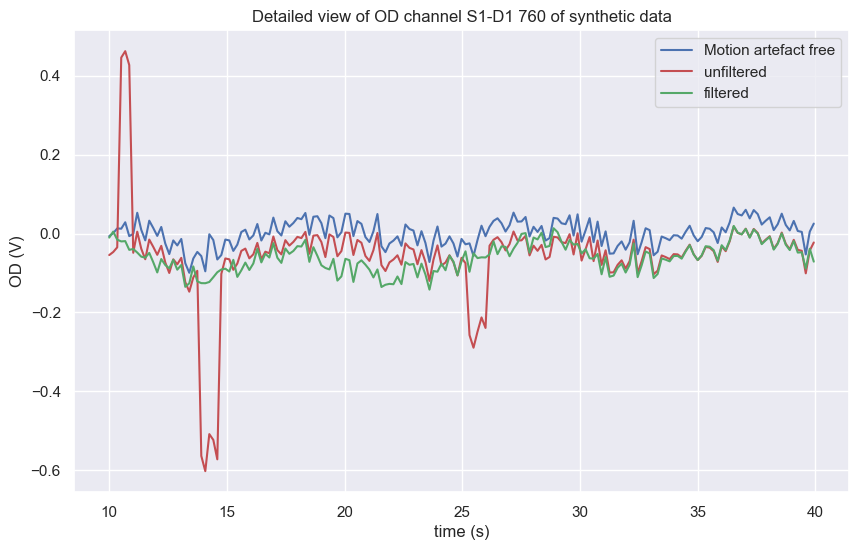

In [86]:
# Zoom in on spike of first dataset (Look for good segment in full recording first)
%matplotlib inline
tmin, tmax = 10, 40
data_clean = raw_synth_od_cleans[0].copy().pick(0).crop(tmin,tmax).get_data()[0]
data_unfiltered = raw_synth_od_unfiltereds[0].copy().pick(0).crop(tmin,tmax).get_data()[0]
data_filtered = raw_synth_od_filtered_WFs[0].copy().pick(0).crop(tmin,tmax).get_data()[0]
t = np.arange(len(data_clean))/sfreq + tmin
plt.plot(t, data_clean, label = 'Motion artefact free', color = 'b')
plt.plot(t, data_unfiltered, label = 'unfiltered', color = 'r')
plt.plot(t, data_filtered, label = 'filtered', color = 'g')
plt.xlabel('time (s)')
plt.ylabel('OD (V)')
plt.title('Detailed view of OD channel S1-D1 760 of synthetic data')
plt.legend()
if export:
    plt.savefig('WF/WF_synth_detail.png')

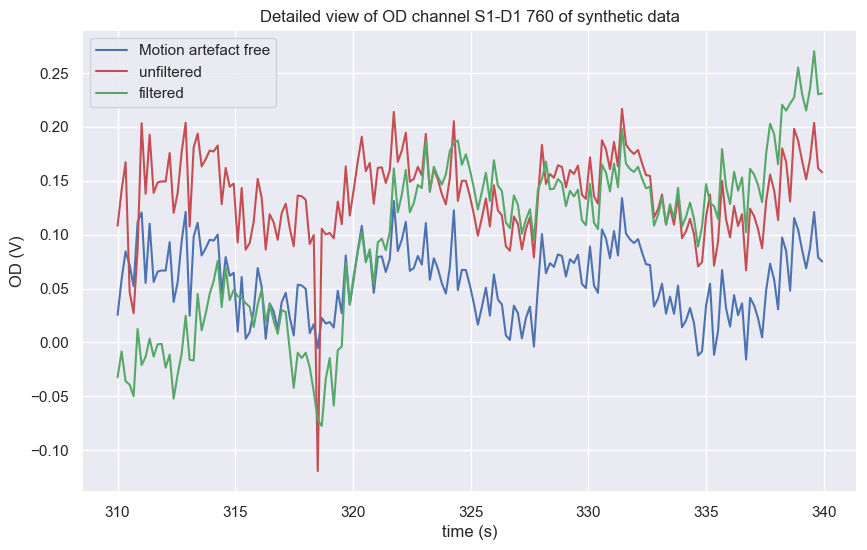

In [87]:
# Zoom in on baseline shift of first data
%matplotlib inline
tmin, tmax = 310, 340
data_clean = raw_synth_od_cleans[0].copy().pick(0).crop(tmin,tmax).get_data()[0]
data_unfiltered = raw_synth_od_unfiltereds[0].copy().pick(0).crop(tmin,tmax).get_data()[0]
data_filtered = raw_synth_od_filtered_WFs[0].copy().pick(0).crop(tmin,tmax).get_data()[0]
t = np.arange(len(data_clean))/sfreq +tmin
plt.plot(t, data_clean, label = 'Motion artefact free', color = 'b')
plt.plot(t, data_unfiltered, label = 'unfiltered', color = 'r')
plt.plot(t, data_filtered, label = 'filtered', color = 'g')
plt.xlabel('time (s)')
plt.ylabel('OD (V)')
plt.title('Detailed view of OD channel S1-D1 760 of synthetic data')
plt.legend()
if export:
    plt.savefig('WF/WF_synth_detail2.png')

###### Evaluate filter method

In [88]:
# SNR (OD data)
DeltaSNR_synth_od_WFs = dict()
DeltaSNR_synth_od_WFs[0] = get_DeltaSNR(raw_synth_od_cleans[0], raw_synth_od_filtered_WFs[0], raw_synth_od_unfiltereds[0], plot = plot, export = export, filename = 'WF')
for i in range(1, n_set):
    DeltaSNR_synth_od_WFs[i] = get_DeltaSNR(raw_synth_od_cleans[i], raw_synth_od_filtered_WFs[i], raw_synth_od_unfiltereds[i])

In [89]:
# PRD (OD data)
PRD_synth_od_WFs = dict()
PRD_synth_od_WFs[0] = get_PRD(raw_synth_od_cleans[0], raw_synth_od_filtered_WFs[0], raw_synth_od_unfiltereds[0], plot = plot, export = export, filename = 'WF')
for i in range(1,n_set):
    PRD_synth_od_WFs[i] = get_PRD(raw_synth_od_cleans[i], raw_synth_od_filtered_WFs[i], raw_synth_od_unfiltereds[i])

In [90]:
# CC (OD data)
DeltaCC_synth_od_WFs = dict()
DeltaCC_synth_od_WFs[0] = get_DeltaCC(raw_synth_od_cleans[0], raw_synth_od_filtered_WFs[0], raw_synth_od_unfiltereds[0], plot = plot, export = export, filename = 'WF')
for i in range(1,n_set):
    DeltaCC_synth_od_WFs[i] = get_DeltaCC(raw_synth_od_cleans[i], raw_synth_od_filtered_WFs[i], raw_synth_od_unfiltereds[i])

In [91]:
# CNR Cooper (Haemo data)

# Define rejection criteria
reject_criteria = dict(hbo=80e-6)
# Define start and end of epoch
tmin_CNR, tmax_CNR = -6, 30
t_peak = 10

# get real HRF for hbo (possible for synthetic data)
ind_stim = events_synths[0][np.where(events_synths[0][:,2] == 4)[0][5]][0]
ind_start = ind_stim + int(tmin_CNR*sfreq)
ind_stop = ind_stim + int(tmax_CNR*sfreq)
real_HRF = hrf_hbo[ind_start:ind_stop+1]

raw_synth_haemo_filtered_WFs = dict()
for i in range(n_set):
    raw_synth_haemo_filtered_WFs[i] = beer_lambert_law(raw_synth_od_filtered_WFs[i], ppf=ppf)
CNR_cooper_synth_haemo_WFs = dict()
CNR_cooper_synth_haemo_WFs[0] = get_CNR_Cooper(raw_synth_haemo_filtered_WFs[0], raw_synth_haemo_unfiltereds[0], reject_criteria = reject_criteria, tmin = tmin_CNR, tmax = tmax_CNR, t_peak = t_peak, real_HRF = real_HRF, plot = plot, export = export, filename = 'WF')
for i in range(1, n_set):
    CNR_cooper_synth_haemo_WFs[i] = get_CNR_Cooper(raw_synth_haemo_filtered_WFs[i], raw_synth_haemo_unfiltereds[i], reject_criteria = reject_criteria, tmin = tmin_CNR, tmax = tmax_CNR, t_peak = t_peak, real_HRF = real_HRF)

Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Not setting metadata
53 matching events found
Setting baseline interval to [-5.9523809523809526, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 53 events and 212 original time points ...
5 bad epochs dropped
Not setting metadata
53 matching events found
Setting baseline interval to [-5.9523809523809526, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 53 events and 212 original time points ...
5 bad epochs dropped
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Not setting metadata
53 matching events found
Setting baseline interval to [-5.9523809523809526, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 53 events and 212 original time points ...
5 bad epochs dropped
Not setting metadata
53 matching events f

In [92]:
# CNR Zhang (haemo data)
CNR_zhang_synth_haemo_WFs = dict()
CNR_zhang_synth_haemo_WFs[0] = get_CNR_Zhang(raw_synth_haemo_filtered_WFs[0], raw_synth_haemo_unfiltereds[0], reject_criteria = reject_criteria, plot = plot, export = export, filename = 'WF')
for i in range(1, n_set):
    CNR_zhang_synth_haemo_WFs[i] = get_CNR_Zhang(raw_synth_haemo_filtered_WFs[i], raw_synth_haemo_unfiltereds[i], reject_criteria = reject_criteria)

Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Not setting metadata
53 matching events found
Setting baseline interval to [-14.965986394557824, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 53 events and 207 original time points ...
7 bad epochs dropped
Not setting metadata
53 matching events found
Setting baseline interval to [-14.965986394557824, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 53 events and 207 original time points ...
7 bad epochs dropped
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Not setting metadata
53 matching events found
Setting baseline interval to [-14.965986394557824, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 53 events and 207 original time points ...
4 bad epochs dropped
Not setting metadata
53 matching events f

Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 1.35 Hz)
- Filter length: 65 samples (11.054 s)



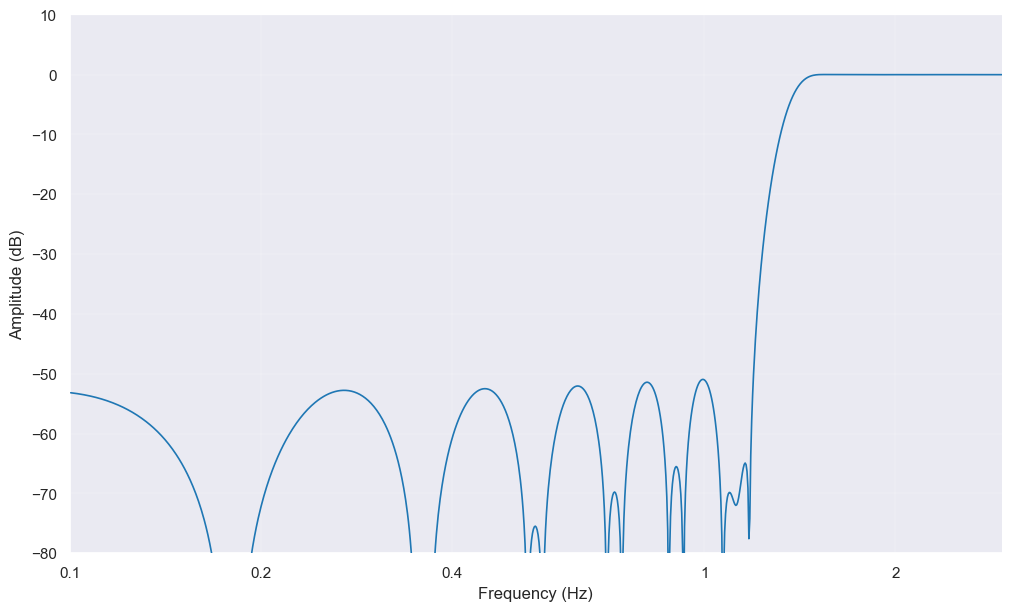

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 1.35 Hz)
- Filter length: 65 samples (11.054 s)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 1.35 Hz)
- Filter length: 65 samples (11.054 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


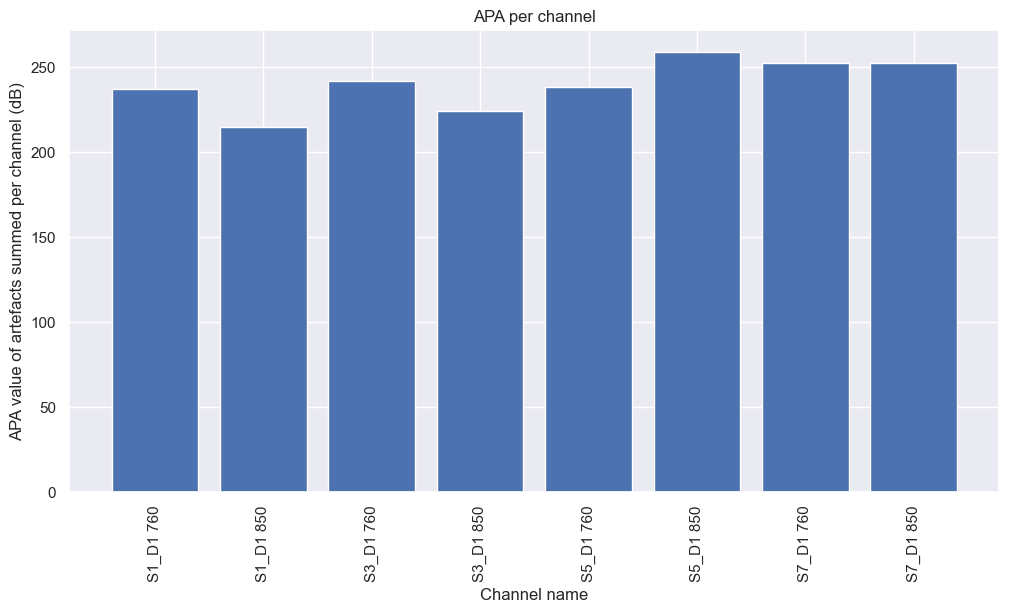

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 1.35 Hz)
- Filter length: 65 samples (11.054 s)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 1.35 Hz)
- Filter length: 65 samples (11.054 s)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter paramet

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 1.35 Hz)
- Filter length: 65 samples (11.054 s)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 1.35 Hz)
- Filter length: 65 samples (11.054 s)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass f

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

In [93]:
# APA (OD data)
l_freq = 1.5 # Hz
l_trans_bandwidth = 0.3 # Hz

ids = [event_dict_synths[0]['Spike'], event_dict_synths[0]['Shift']]

start_ind = events_synths[0][np.isin(events_synths[0][:,2], ids)][:,0] - int(5*sfreq) # 5 seconds before artefact
start_ind = np.where(start_ind < 0, 0, start_ind)
stop_ind = start_ind + int(10*sfreq) # 5 seconds after artefact
Am_synth = zip(start_ind, stop_ind)

APA_synth_od_WFs = dict()
APA_synth_od_WFs[0] = get_APA(raw_synth_od_filtered_WFs[0], raw_synth_od_unfiltereds[0], Am_synth, l_freq, l_trans_bandwidth = l_trans_bandwidth, plot = True)

for i in range(1, n_set):
    ids = [event_dict_synths[i]['Spike'], event_dict_synths[i]['Shift']]
    start_ind = events_synths[i][np.isin(events_synths[i][:,2], ids)][:,0] - int(5*sfreq) # 5 seconds before artefact
    start_ind = np.where(start_ind < 0, 0, start_ind)
    stop_ind = start_ind + int(10*sfreq) # 5 seconds after artefact
    Am_synth = zip(start_ind, stop_ind)
    APA_synth_od_WFs[i] = get_APA(raw_synth_od_filtered_WFs[i], raw_synth_od_unfiltereds[i], Am_synth, l_freq, l_trans_bandwidth = l_trans_bandwidth)

##### Perform on motion artefact experiment data

In [94]:
raw_od_filtered_WF = wavelet_filter(raw_od, plot = plot, export = export, filename = 'MA')

S2_D2 760


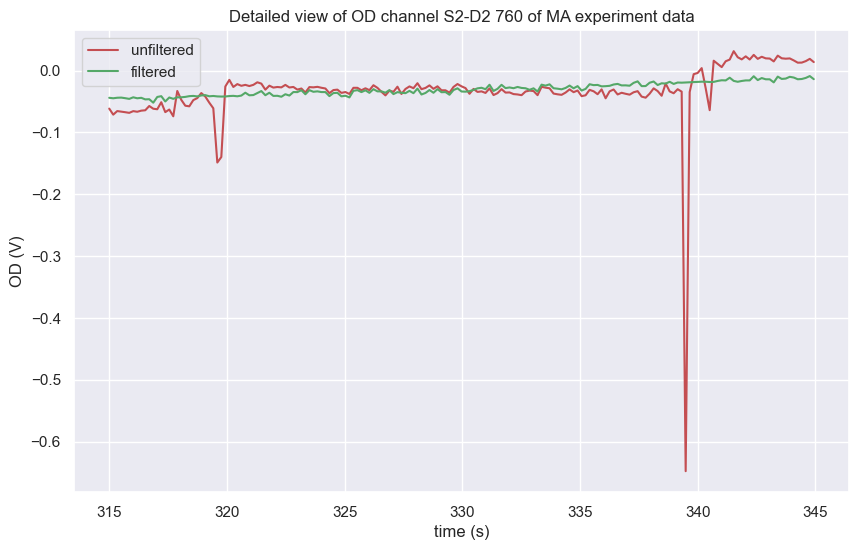

In [95]:
%matplotlib inline
chan = 2
print(raw_od.ch_names[chan])
tmin, tmax = 315, 345
data_unfiltered = raw_od.copy().pick(chan).crop(tmin,tmax).get_data()[0]
data_filtered = raw_od_filtered_WF.copy().pick(chan).crop(tmin,tmax).get_data()[0]
t = np.arange(len(data_unfiltered))/sfreq + tmin
plt.plot(t, data_unfiltered, label = 'unfiltered', color = 'r')
plt.plot(t, data_filtered, label = 'filtered', color = 'g')
plt.xlabel('time (s)')
plt.ylabel('OD (V)')
plt.title('Detailed view of OD channel S2-D2 760 of MA experiment data')
plt.legend()
if export:
    plt.savefig('WF/WF_MA_detail.png')

S2_D2 760


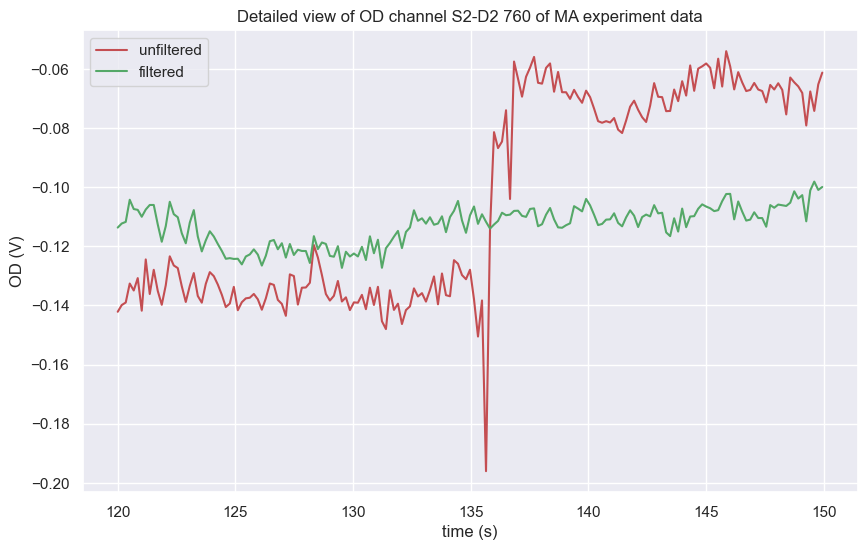

In [96]:
%matplotlib inline
chan = 2
print(raw_od.ch_names[chan])
tmin, tmax = 120, 150
data_unfiltered = raw_od.copy().pick(chan).crop(tmin,tmax).get_data()[0]
data_filtered = raw_od_filtered_WF.copy().pick(chan).crop(tmin,tmax).get_data()[0]
t = np.arange(len(data_unfiltered))/sfreq + tmin
plt.plot(t, data_unfiltered, label = 'unfiltered', color = 'r')
plt.plot(t, data_filtered, label = 'filtered', color = 'g')
plt.xlabel('time (s)')
plt.ylabel('OD (V)')
plt.title('Detailed view of OD channel S2-D2 760 of MA experiment data')
plt.legend()
if export:
    plt.savefig('WF/WF_MA_detail2.png')

###### Evaluate filter method

Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 1.35 Hz)
- Filter length: 65 samples (11.050 s)



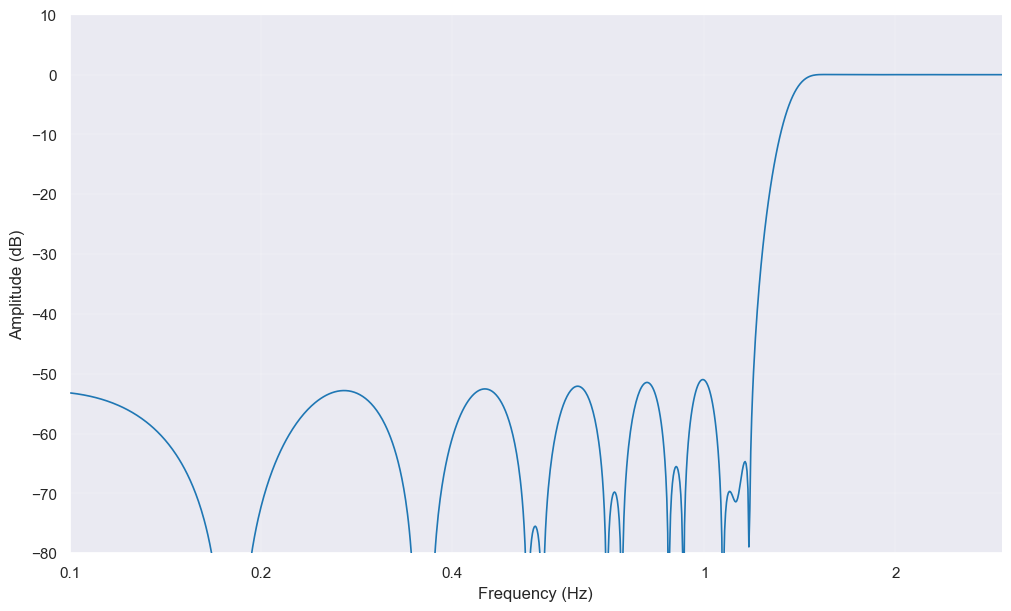

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 1.35 Hz)
- Filter length: 65 samples (11.050 s)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 1.35 Hz)
- Filter length: 65 samples (11.050 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    0.0s finished


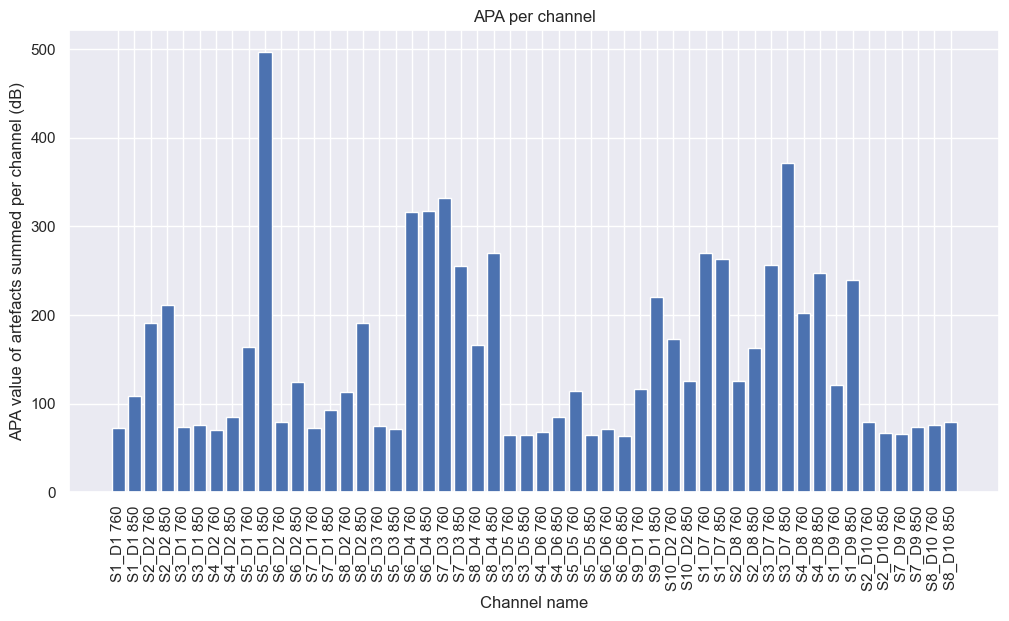

In [97]:
# APA (OD data)
ids = [event_dict['test/Horizontal'], event_dict['test/Random'], event_dict['test/Vertical']]
start_ind = events[np.isin(events[:,2], ids)][:,0] - int(5*sfreq) # 5 seconds before artefact
stop_ind = start_ind + int(15*sfreq) # 10 seconds after artefact
Am = zip(start_ind, stop_ind)

APA_od_WF = get_APA(raw_od_filtered_WF, raw_od, Am, l_freq, l_trans_bandwidth = l_trans_bandwidth, plot = True)

---
> *Remark:*
- Spikes and baselines effciently removed
- Still baseline drifts present
---

#### Kurtosis-based wavelet filtering <a class="anchor" id="sub_section_1_6_2"></a>

In WF, determining a threshold value ($\alpha$) is crucial for rejecting wavelet coefficients. It is worth noting that this parameter should adapt based on the frequency of artifacts present in the data. However, computing the frequency of artifacts necessitates setting a threshold, leading to circularity in threshold selection, resulting in the use of arbitrary fixed values. To mitigate this challenge, Chiarelli et al. (2015) proposed a novel approach for identifying artifactual wavelet coefficients. 

In the kurtosis-based Wavelet Filtering (kbWF) method, the DWT is again applied to the OD data of each channel. Next, a threshold for kurtosis is chosen for the distribution of wavelet coefficients. Chiarelli et al. (2015) suggest a kurtosis threshold value of 3.3 ($k = 3.3$). At the selected decomposition level, the kurtosis value of the coefficient distribution is computed, disregarding zero values. If the kurtosis surpasses the threshold, the highest coefficient (in absolute value) is set to 0. This process continues until the estimated kurtosis falls below the threshold. After scanning through all decomposition levels, the algorithm performs an inverse DWT to estimate the artifact-free time-course. 

In [98]:
# Define function for a single channel
def wavelet_k(data, datatype, fs, wavelet_type = 'db5', mode = 'symmetric', level = None, k = 3.3, plot = False, pick = None, export = False, filename = None):
    
    # Describe properties of a discrete wavelet
    wavelet = pywt.Wavelet(wavelet_type)
    
    # Calculate approximation and detail coefficients (cA (LF), cD (HF))
    coeff = pywt.wavedec(data, wavelet, mode=mode, level=level, axis=-1) 
    # Daubechies 5 (db5) wavelet, If level is None (default) then it will be calculated using the dwt_max_level function.
    # dwt_max_level stops decomposition when the signal becomes shorter than the FIR filter length for a given wavelet.
    # Structure of coeff: [cA_n, cD_n, cD_n-1, …, cD2, cD1]

    coeff_new = []
    
    for coefficient in coeff:
        # Ignore zero values
        zero_free = coefficient[coefficient != 0]

        while kurtosis(zero_free) > k:
            coefficient[np.argmax(np.absolute(coefficient))] = 0
            zero_free = coefficient[coefficient != 0]
        coeff_new.append(coefficient)
        
    #Perform inverse wavelet transform
    data_new = pywt.waverec(coeff_new, wavelet, mode=mode, axis=-1)
    
    if plot:
        # Plot original and new values
        if pick == None:
            raise ValueError('Please add picks')
        if datatype == 'hbo':
            type = ' hbo' if pick%2 == 0 else ' hbr'
            ylabel = 'HbO/HbR (M)'
        else:
            type = ' wavelength 760' if pick%2 == 0 else ' wavelength 850'
            ylabel = 'OD (V)'
        %matplotlib inline
        time1 = np.arange(len(data))/fs
        time2 = np.arange(len(data_new))/fs
        plt.plot(time1, data, label = 'original')
        plt.plot(time2, data_new, label = 'filtered')
        plt.xlabel('time (s)')
        plt.ylabel(ylabel)
        plt.title('Channel: ' + str(pick//2+1) + type)
        plt.legend()
        if export:
            plt.savefig('kbWF/kbWF_' + filename + '_channel_' + str(pick//2+1) + type + '.png')
        plt.show()

    return data_new

In [99]:
# Iterate over all channels and create new raw object
def wavelet_filter_k(raw, k = 3.3, plot = False, export = False, filename = None):
    
    raw = raw.copy()
    picks = np.sort(_validate_nirs_info(raw.info))
    n_samples = raw.get_data().shape[1]
    type = raw.ch_names[0][-3:]
    
    for pick in picks:
        raw._data[pick] = wavelet_k(raw._data[pick], type, raw.info['sfreq'], wavelet_type = 'db5', mode = 'symmetric', level = None, k = k, plot = plot, pick = pick, export = export, filename = filename)[:n_samples]
    
    return raw

##### Perform on synthetic data

In [100]:
raw_synth_od_filtered_kWFs = dict()
raw_synth_od_filtered_kWFs[0] = wavelet_filter_k(raw_synth_od_unfiltereds[0], k = 3.3, plot = plot, export = export, filename = 'synthetic')
for i in range(1, n_set):
    raw_synth_od_filtered_kWFs[i] = wavelet_filter_k(raw_synth_od_unfiltereds[i], k = 3.3)

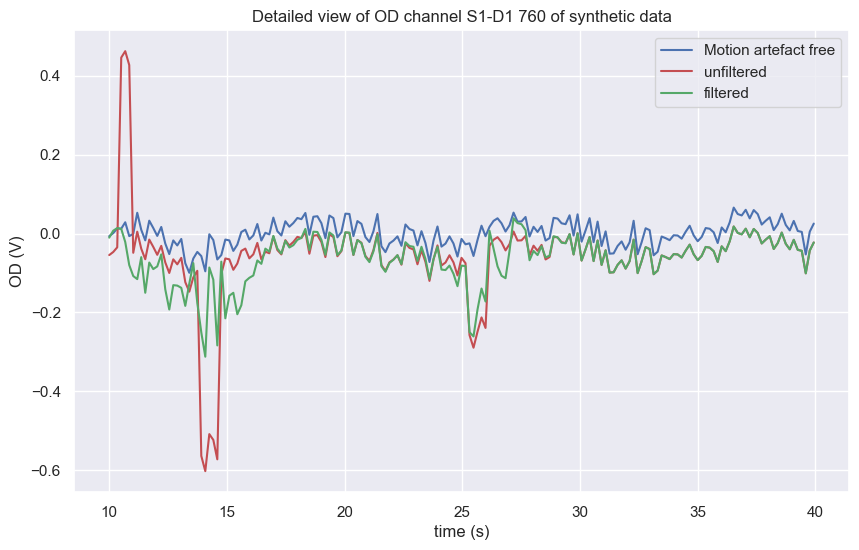

In [101]:
# Zoom in on spike of first dataset (Look for good segment in full recording first)
%matplotlib inline
tmin, tmax = 10, 40
data_clean = raw_synth_od_cleans[0].copy().pick(0).crop(tmin,tmax).get_data()[0]
data_unfiltered = raw_synth_od_unfiltereds[0].copy().pick(0).crop(tmin,tmax).get_data()[0]
data_filtered = raw_synth_od_filtered_kWFs[0].copy().pick(0).crop(tmin,tmax).get_data()[0]
t = np.arange(len(data_clean))/sfreq + tmin
plt.plot(t, data_clean, label = 'Motion artefact free', color = 'b')
plt.plot(t, data_unfiltered, label = 'unfiltered', color = 'r')
plt.plot(t, data_filtered, label = 'filtered', color = 'g')
plt.xlabel('time (s)')
plt.ylabel('OD (V)')
plt.title('Detailed view of OD channel S1-D1 760 of synthetic data')
plt.legend()
if export:
    plt.savefig('kbWF/kbWF_synth_detail.png')

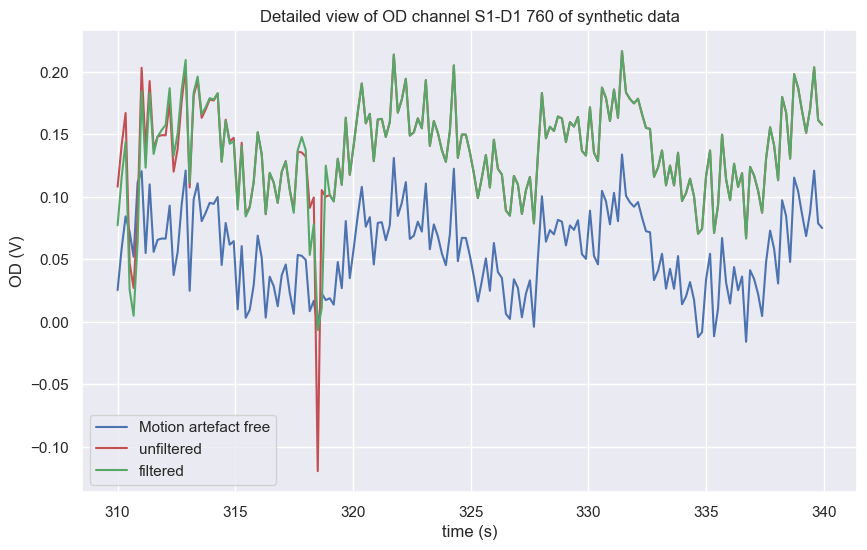

In [102]:
# Zoom in on baseline shift of first data
%matplotlib inline
tmin, tmax = 310, 340
data_clean = raw_synth_od_cleans[0].copy().pick(0).crop(tmin,tmax).get_data()[0]
data_unfiltered = raw_synth_od_unfiltereds[0].copy().pick(0).crop(tmin,tmax).get_data()[0]
data_filtered = raw_synth_od_filtered_kWFs[0].copy().pick(0).crop(tmin,tmax).get_data()[0]
t = np.arange(len(data_clean))/sfreq +tmin
plt.plot(t, data_clean, label = 'Motion artefact free', color = 'b')
plt.plot(t, data_unfiltered, label = 'unfiltered', color = 'r')
plt.plot(t, data_filtered, label = 'filtered', color = 'g')
plt.xlabel('time (s)')
plt.ylabel('OD (V)')
plt.title('Detailed view of OD channel S1-D1 760 of synthetic data')
plt.legend()
if export:
    plt.savefig('kbWF/kbWF_synth_detail2.png')

###### Evaluate filter method

In [103]:
# SNR (OD data)
DeltaSNR_synth_od_kWFs = dict()
for i in range(n_set):
    DeltaSNR_synth_od_kWFs[i] = get_DeltaSNR(raw_synth_od_cleans[i], raw_synth_od_filtered_kWFs[i], raw_synth_od_unfiltereds[i])

In [104]:
# PRD (OD data)
PRD_synth_od_kWFs = dict()
for i in range(n_set):
    PRD_synth_od_kWFs[i] = get_PRD(raw_synth_od_cleans[i], raw_synth_od_filtered_kWFs[i], raw_synth_od_unfiltereds[i])

In [105]:
# CC (OD data)
DeltaCC_synth_od_kWFs = dict()
for i in range(n_set):
    DeltaCC_synth_od_kWFs[i] = get_DeltaCC(raw_synth_od_cleans[i], raw_synth_od_filtered_kWFs[i], raw_synth_od_unfiltereds[i])

In [106]:
# CNR Cooper (haemo data)
raw_synth_haemo_filtered_kWFs = dict()
CNR_cooper_synth_haemo_kWFs = dict()
for i in range(n_set):
    raw_synth_haemo_filtered_kWFs[i] = beer_lambert_law(raw_synth_od_filtered_kWFs[i], ppf=ppf)
    CNR_cooper_synth_haemo_kWFs[i] = get_CNR_Cooper(raw_synth_haemo_filtered_kWFs[i], raw_synth_haemo_unfiltereds[i], reject_criteria = reject_criteria, tmin = tmin_CNR, tmax = tmax_CNR, t_peak = t_peak, real_HRF = real_HRF)

Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Not setting metadata
53 matching events found
Setting baseline interval to [-5.9523809523809526, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 53 events and 212 original time points ...
5 bad epochs dropped
Not setting metadata
53 matching events found
Setting baseline interval to [-5.9523809523809526, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 53 events and 212 original time points ...
5 bad epochs dropped
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Not setting metadata
53 matching events found
Setting baseline interval to [-5.9523809523809526, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 53 events and 212 original time points ...
5 bad epochs dropped
Not setting metadata
53 matching events f

In [107]:
# CNR Zhang (haemo data)
CNR_zhang_synth_haemo_kWFs = dict()
for i in range(n_set):
    CNR_zhang_synth_haemo_kWFs[i] = get_CNR_Zhang(raw_synth_haemo_filtered_kWFs[i], raw_synth_haemo_unfiltereds[i], reject_criteria = reject_criteria)

Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Not setting metadata
53 matching events found
Setting baseline interval to [-14.965986394557824, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 53 events and 207 original time points ...
7 bad epochs dropped
Not setting metadata
53 matching events found
Setting baseline interval to [-14.965986394557824, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 53 events and 207 original time points ...
7 bad epochs dropped
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Not setting metadata
53 matching events found
Setting baseline interval to [-14.965986394557824, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 53 events and 207 original time points ...
4 bad epochs dropped
Not setting metadata
53 matching events f

In [108]:
#APA (OD data)
APA_synth_od_kWFs = dict()
for i in range(n_set):
    ids = [event_dict_synths[i]['Spike'], event_dict_synths[i]['Shift']]
    
    start_ind = events_synths[i][np.isin(events_synths[i][:,2], ids)][:,0] - int(5*sfreq) # 5 seconds before artefact
    start_ind = np.where(start_ind < 0, 0, start_ind)
    stop_ind = start_ind + int(10*sfreq) # 5 seconds after artefact
    Am_synth = zip(start_ind, stop_ind)
    
    APA_synth_od_kWFs[i] = get_APA(raw_synth_od_filtered_kWFs[i], raw_synth_od_unfiltereds[i], Am_synth, l_freq, l_trans_bandwidth = l_trans_bandwidth)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 1.35 Hz)
- Filter length: 65 samples (11.054 s)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 1.35 Hz)
- Filter length: 65 samples (11.054 s)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter paramet

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

- Filter length: 65 samples (11.054 s)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 1.35 Hz)
- Filter length: 65 samples (11.054 s)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 1.35 Hz)
- Filter length: 65 samples (11.054 s)

Filtering raw data in 1 contiguous segment
Setting up high-p

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

##### Perform on motion artefact experiment data

In [109]:
raw_od_filtered_kWF = wavelet_filter_k(raw_od, plot = plot, export = export, filename = 'MA')

S2_D2 760


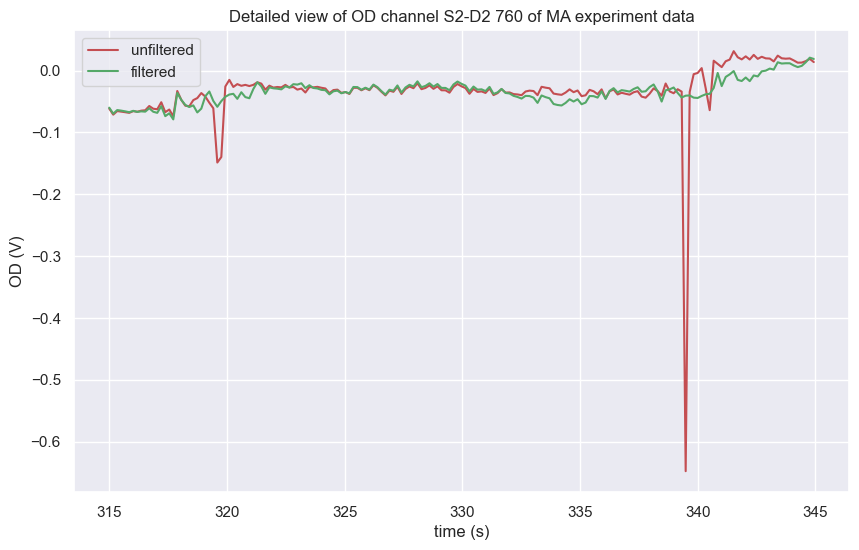

In [110]:
%matplotlib inline
chan = 2
print(raw_od.ch_names[chan])
tmin, tmax = 315, 345
data_unfiltered = raw_od.copy().pick(chan).crop(tmin,tmax).get_data()[0]
data_filtered = raw_od_filtered_kWF.copy().pick(chan).crop(tmin,tmax).get_data()[0]
t = np.arange(len(data_unfiltered))/sfreq + tmin
plt.plot(t, data_unfiltered, label = 'unfiltered', color = 'r')
plt.plot(t, data_filtered, label = 'filtered', color = 'g')
plt.xlabel('time (s)')
plt.ylabel('OD (V)')
plt.title('Detailed view of OD channel S2-D2 760 of MA experiment data')
plt.legend()
if export:
    plt.savefig('kbWF/kbWF_MA_detail.png')

S2_D2 760


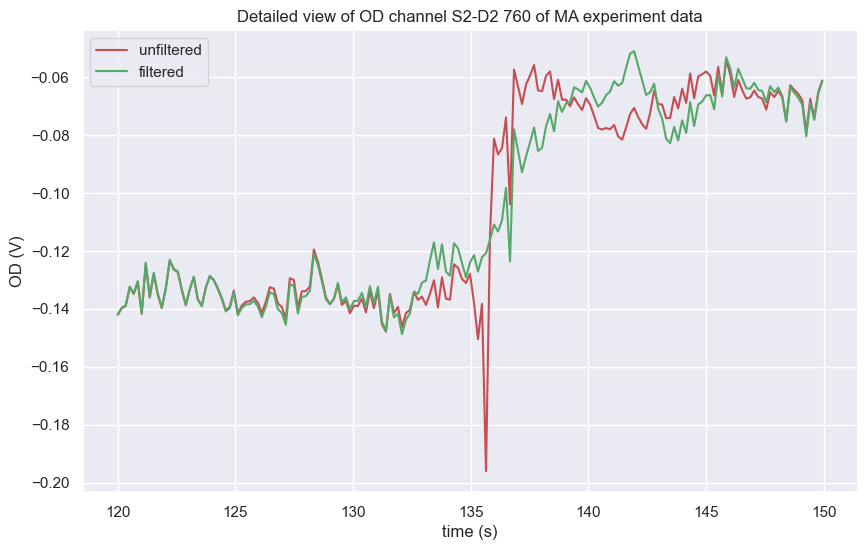

In [111]:
%matplotlib inline
chan = 2
print(raw_od.ch_names[chan])
tmin, tmax = 120, 150
data_unfiltered = raw_od.copy().pick(chan).crop(tmin,tmax).get_data()[0]
data_filtered = raw_od_filtered_kWF.copy().pick(chan).crop(tmin,tmax).get_data()[0]
t = np.arange(len(data_unfiltered))/sfreq + tmin
plt.plot(t, data_unfiltered, label = 'unfiltered', color = 'r')
plt.plot(t, data_filtered, label = 'filtered', color = 'g')
plt.xlabel('time (s)')
plt.ylabel('OD (V)')
plt.title('Detailed view of OD channel S2-D2 760 of MA experiment data')
plt.legend()
if export:
    plt.savefig('kbWF/kbWF_MA_detail2.png')

###### Evaluate filter method

In [112]:
# APA (OD data)
ids = [event_dict['test/Horizontal'], event_dict['test/Random'], event_dict['test/Vertical']]
start_ind = events[np.isin(events[:,2], ids)][:,0] - int(5*sfreq) # 5 seconds before artefact
start_ind = np.where(start_ind < 0, 0, start_ind)
stop_ind = start_ind + int(15*sfreq) # 10 seconds after artefact
Am = zip(start_ind, stop_ind)

APA_od_kWF = get_APA(raw_od_filtered_kWF, raw_od, Am, l_freq, l_trans_bandwidth = l_trans_bandwidth)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 1.35 Hz)
- Filter length: 65 samples (11.050 s)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 1.35 Hz)
- Filter length: 65 samples (11.050 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    0.0s finished


---
> *Remark:*
- Less efficient removal of spikes. Amplitude is decreased and spike seems to be smeared out
- Bad removal of baseline shifts
---

#### Spline interpolation (NOT WORKING) <a class="anchor" id="sub_section_1_6_3"></a>

Scholkmann et al. (2010) proposed to use moving standard deviation (MSD) and spline interpolation to respectively detect and reduce MAs in NIR imaging, and termed it MARA. Therefore, the algorithm consists of two individual steps. 

In the first step, the two-sided MSD ($s(t)$) of each channel ($x(t)$) is calculated and compared to a user chosen threshold value $T$. Values in \( s(t) \) below \( T \) are nullified, leaving segments of non-zero values that represent segments of \( x(t) \) affected by MAs. This information is then used to segment $x(t)$ in segments that contain MA and segments that do not. 

In the next step, spline interpolation is performed on the segments of $x(t)$ that contain MAs. Scholkman and associates use the cubic spline interpolation method (*csaps*) with a smoothing parameter value of $p=0.01$. A denoised segment is than produced by subtracting the spline interpolation function from the original MA-containing segments. However, this spline subtraction leads to different signal levels between MA- and non-MA-containing segments. Therefore, to ensure a continuous signal, a correction algorithm based on parallel-shifting with respect the mean value of the target MA-containing segments, and the mean value of the previous non-MA-containing segment, is performed. 

In [113]:
# Define the MSD function
def MSD(x, k):
    w = 2*k+1
    N = len(x)
    msd = np.zeros_like(x)
    msd[:k] = np.NAN
    msd[-k:] = np.NAN
    for t in range(k,N-k):
        x_window = x[t-k:t+k+1]
        msd[t] = np.sqrt(np.sum(x_window**2)-np.sum(x_window)**2/w)/w
    return msd

In [114]:
# Define a fucntion that detects the start and end points of the MAs
# First segment is lower than threshold!
def detection_start_end(x, k, T = None, n = 3):
    s = MSD(x, k)

    if T == None:
        T = np.nanmean(s) + n * np.nanstd(s)
        
    non_zeros_id = np.where(s > T)[0]
    split = [non_zeros_id[0]]
    for i, id in enumerate(non_zeros_id[1:]):
        if id != (non_zeros_id[i] + 1):
            split.append(int(non_zeros_id[i] + 1))
            split.append(id)
    split.append(non_zeros_id[-1]+1)
    split = list(np.array(split)+k)
    
    x_segmented = np.split(x, split)
    if x_segmented[0].size > 0:
        print('First segment lower than threshold')
        first_element = 0
    else:
        print('First segment higher than threshold')
        s_segmented = s_segmented[1:]
        first_element = 1
    if x_segmented[-1].size > 0:
        print('last segment lower than threshold')
    else:
        print('last segment higher than threshold')
        x_segmented = x_segmented[:-1]
    return x_segmented, first_element

In [115]:
# Define spline interpolation function
# --> each segment containing an MA is spline interpolated

def spline_int(raw, t_start, t_stop, channel, k, T, n = None, p = 0.01, plot = False):
    x = raw.copy().crop(t_start, t_stop).get_data(picks = channel)[0]
    x_org = x.copy()
    x_segmented, first_element = detection_start_end(x, k, T, n)
    
    for i, segment in enumerate(x_segmented):
        if (i%2 != first_element) and (len(segment) > 1):
            x = np.arange(len(segment))
            xs = np.arange(0, len(segment), 0.1)
            yi = csaps(x, segment, xs, smooth = p) # See scholkmann 2010 p = 0.01
            ps = csaps(x, segment, smooth = p)

            corrected_segment = segment - ps(x)
            x_segmented[i] = corrected_segment
        
            if plot:
                plt.plot(x/raw.info['sfreq'], segment, 'o-', label='data')
                plt.plot(xs/raw.info['sfreq'], yi, label="S")
                plt.plot(x/raw.info['sfreq'], corrected_segment, 'x-', label = 'corrected data')
                plt.legend(loc='lower left', ncol=2)
                plt.title('Interpolation of segment ' + str(i))
                plt.show()
    x_corrected = np.concatenate(x_segmented)
    
    if plot:
        t = np.arange(len(x_org))/raw.info['sfreq']
        plt.plot(t, x_org, 'o-', label='data')
        plt.plot(t, x_corrected, 'x-', label = 'corrected data')
        plt.legend(loc='lower left', ncol=2)
        plt.title('Comparison original and MA corrected signal')
        plt.show()
    return x_segmented, first_element
        

##### Perform on synthetic data

In [116]:
# # W should be similar to the period of spikes that users aimed to identify. see Zhao2021
# t_spike = 1
# samples_spike = t_spike*sfreq
# k = int(samples_spike//2)
# T = None

In [117]:
# x_segmented, first_element = spline_int(raw_synth_od_unfiltered, 0, 499, 1, k, T, n = 2, p = 0.01, plot = True)

In [118]:
# # A lot of coding!! see scholkman 2010
# # Step 4: Reconstruction of the whole time series
# if not first_element:
#     x_segmented_new = []
# else:
#     x_segmented_new = [x_segmented[0]]
# alpha = round(raw_MA_od.info['sfreq']/3)
# beta = round(raw_MA_od.info['sfreq']/2)
# for i in range(0,int(len(x_segmented)-1)):
#     if i%2 == first_element:
#         x_segmented_new.append(x_segmented[i])
#         lambda_1 = len(x_segmented[i])
#         lambda_2 = len(x_segmented[i+1])
#         theta_1 = np.ceil(lambda_1/10)
#         theta_2 = np.ceil(lambda_2/10)
#         if lambda_1 <= alpha:
#             if lambda_2 <= alpha:
#                 a = np.sum(x_segmented[i])
#                 b = np.sum(x_segmented[i+1])
#             elif lambda_2 >= beta:
#                 a = np.sum(x_segmented[i])
#                 b = np.sum(x_segmented[i+1][:int(theta_2+1)])
#             else:
#                 a = np.sum(x_segmented[i][:int(theta_1+1)])
#                 b = np.sum(x_segmented[i+1][:int(alpha+1)])
#         elif lambda_1 >= beta:
#             if lambda_2 <= alpha:
#                 a = np.sum(x_segmented[i][int(lambda_1-theta_1):int(lambda_1+1)])
#                 b = np.sum(x_segmented[i+1][:lambda_2])
#             elif lambda_2 >= beta:
#                 a = np.sum(x_segmented[i][int(lambda_1-theta_1):int(lambda_1+1)])
#                 b = np.sum(x_segmented[i+1][:int(theta_2+1)])
#             else:
#                 a = np.sum(x_segmented[i][int(lambda_1-theta_1):int(lambda_1+1)])
#                 b = np.sum(x_segmented[i+1][:int(alpha+1)])
#         else:
#             if lambda_2 <= alpha:
#                 a = np.sum(x_segmented[i][int(lambda_1-alpha):int(lambda_1+1)])
#                 b = np.sum(x_segmented[i+1][:lambda_2])
#             elif lambda_2 >= beta:
#                 a = np.sum(x_segmented[i][int(lambda_1-alpha):int(lambda_1+1)])
#                 b = np.sum(x_segmented[i+1][:int(theta_2+1)])
#             else:
#                 a = np.sum(x_segmented[i][int(lambda_1-alpha):int(lambda_1+1)])
#                 b = np.sum(x_segmented[i+1][:int(alpha+1)])
#         theta_m = a - b
#         segment_shifted = x_segmented[i+1] + theta_m
#         x_segmented_new.append(segment_shifted)
# x_new = np.concatenate(x_segmented_new)
# plt.plot(x_new, '--', label = 'filtered')
# plt.plot(x, label = 'orginal')
# plt.legend()
# plt.show()
    

---
> *Remark:*
- No done
---

#### Principal component analysis <a class="anchor" id="sub_section_1_6_4"></a>

Zhang et al. (2005) introduced a spatial filtering technique called targeted PCA (tPCA), which relies on eigenvectors. tPCA is capable of eliminating spike-like MAs as well as baseline shifts. However, its effectiveness may diminish if MAs are not detected across multiple channels.

To implement the method, four different matrices need to be created. For each type of chromophore, HbO and HbR, two matrices are filled with the datapoints of respectively the baseline and stimulation period. From both baseline matrices $\mathbf{H_{base,hbo}}$ and $\mathbf{H_{base,hbr}}$, a spatial correlation matrix $\mathbf{C_{base}}$ is created and subsequently an  eigendecomposition is performed to reveice the orthogonal matrix $\mathbf{U_{base}}$ with columns $\mathbf{u_i}$ referring to the baseline spatial eigenvectors. Additionally, the eigenvalues are calculated. 

$$\mathbf{C_{base}}= \frac{1}{N_t} \mathbf{H_{base} H_{base}}^T = \mathbf{U_{base} \Sigma_{base} U_{base}}^T $$

Where $N_t$ is the number of data points at different time instants.

In the subsequent step, it is assumed that the initial spatial eigenvectors of the baseline concentration correlation matrices primarily capture interference patterns and contain the majority of the overall energy. Consequently, projecting the stimulus data onto the orthogonal nullspace of these eigenvectors enables the extraction of a more localized response. 
Therefore, a new matrix is created from the first $r$ eigenvectors,  $\mathbf{U_{base,r} = [u_1, ... ,u_r]}$, and then the clean data matrix $\mathbf{H_{stim, clean}}$ is obtained by projecting the original stimulus data onto the orthogonal subspace of $\mathbf{U_{base,r}}$. 
$$   \mathbf{H_{stim, clean} = (I - U_{base,r}  U_{base,r}}^T) \mathbf{H_{stim}}$$
Where $\mathbf{I}$ is the identity matrix. 

This process is performed for both chromophores. 

In [119]:
# Define PCA function
def PCA_Zhang(raw_input, stim_names, DurStim, r = 3, tmin = -5, tmax = 15, plot = False, export = False, filename = None, xlim = None):
    """
    Input:
    - raw_input: raw haemo unfiltered data
    - stim_names: list containing strings which represent names of task stimuli eg: ['tapping/left', 'tapping/right']
    - DurStim: duration of stimuli in seconds
    - r: If 0 < r < 1, select the number of PCA components such that the amount of variance that needs to be explained is greater than the percentage specified by r.
    elif r > 1, number of PCA components to keep
    - tmin, tmax: define duration (in seconds) added around baseline and stimulus segments to perform PCA to eg: 5 seconds before first stimuli and 15 seconds after last stimuli is completed
    """
    raw =raw_input.copy()
    events_, event_dict_ = mne.events_from_annotations(raw)
    fs = raw.info['sfreq']
    
    control_id = event_dict_['Baseline']
    trials_id = []
    for stim in stim_names:
        trials_id.append(event_dict_[stim])

    start_trials = []
    for id in trials_id:
        start_trials += list(events_[events_[:,2] == id][:,0]/raw.info['sfreq'])
    start_trials = np.sort(np.array(start_trials))

    start_controls = []
    start_controls = list(events_[events_[:,2] == control_id][:,0]/raw.info['sfreq'])
    start_controls = np.sort(np.array(start_controls))

    t_start_trials = start_trials[0] + tmin
    t_stop_trials = start_trials[-1] + DurStim + tmax

    t_start_controls = start_controls[0] + tmin
    t_stop_controls = start_controls[-1] + tmax
    
    Z_stim = raw.copy().crop(tmin=t_start_trials, tmax = t_stop_trials).get_data()
    Z_base = raw.copy().crop(tmin=t_start_controls, tmax= t_stop_controls).get_data()

    # removing the mean and scaling to unit variance
    scaler_stim = StandardScaler().fit(Z_stim)
    scaler_base = StandardScaler().fit(Z_base)
    Z_stim = scaler_stim.transform(Z_stim)
    Z_base = scaler_base.transform(Z_base)
    
    if raw.ch_names[0][-3:] == 'hbo':
        Z_base_hbo = Z_base[::2,:]
        Z_base_hbr = Z_base[1::2,:]

        Z_stim_hbo = Z_stim[::2,:]
        Z_stim_hbr = Z_stim[1::2,:]
    else:
        Z_base_hbo = Z_base[1::2,:]
        Z_base_hbr = Z_base[::2,:]

        Z_stim_hbo = Z_stim[1::2,:]
        Z_stim_hbr = Z_stim[::2,:]

    N_base = Z_base.shape[1]
    
    C_base_hbo = np.matmul(Z_base_hbo, Z_base_hbo.T)/N_base
    C_base_hbr = np.matmul(Z_base_hbr, Z_base_hbr.T)/N_base

    eigenvalues_hbo, eigenvectors_hbo = np.linalg.eig(C_base_hbo)
    eigenvalues_hbr, eigenvectors_hbr = np.linalg.eig(C_base_hbr)

    # Sort eigenvalues
    id_hbo = eigenvalues_hbo.argsort()[::-1] 
    eigenvalues_hbo = eigenvalues_hbo[id_hbo]
    eigenvectors_hbo = eigenvectors_hbo[:,id_hbo]
    id_hbr = eigenvalues_hbr.argsort()[::-1]
    eigenvalues_hbr = eigenvalues_hbr[id_hbr]
    eigenvectors_hbr = eigenvectors_hbr[:,id_hbr]
    
    variance_explained_hbo = []
    for eigenvalue in eigenvalues_hbo:
        variance_explained_hbo.append((eigenvalue/sum(eigenvalues_hbo))*100)
    # variance_explained_hbr = []
    # for eigenvalue in eigenvalues_hbr:
    #     variance_explained_hbr.append((eigenvalue/sum(eigenvalues_hbr))*100)

    if r < 1:
        r = 100*r # Convert to percentage
        sum_variance = 0
        for i in range(len(variance_explained_hbo)):
            sum_variance += variance_explained_hbo[i]
            if sum_variance >= r:
                r = i + 1
                print('The PCA is performed with ' + str(r) + ' component(s), representing ' + str(sum_variance) + '% of the variance.')
                break
                
    U_hbo_r = eigenvectors_hbo[:,:r] # Select r first columns corresponding to largest eigenvalues
    U_hbr_r = eigenvectors_hbr[:,:r]

    Z_stim_hbo_new = np.matmul((np.eye(int(len(raw.ch_names)/2)) - np.matmul(U_hbo_r, U_hbo_r.T)), Z_stim_hbo)
    Z_stim_hbr_new = np.matmul((np.eye(int(len(raw.ch_names)/2)) - np.matmul(U_hbr_r, U_hbr_r.T)), Z_stim_hbr)
    
    Z_stim_new = np.zeros_like(Z_stim)
    if raw.ch_names[0][-3:] == 'hbo':
        Z_stim_new[::2,:] = Z_stim_hbo_new
        Z_stim_new[1::2,:] = Z_stim_hbr_new
    else:
        Z_stim_new[1::2,:] = Z_stim_hbo_new
        Z_stim_new[::2,:] = Z_stim_hbr_new
    
    Z_stim_rescaled = scaler_stim.inverse_transform(Z_stim)
    Z_stim_new_rescaled = scaler_stim.inverse_transform(Z_stim_new)
    

    raw_out = raw.copy().crop(tmin=t_start_trials, tmax=t_stop_trials)
    picks = np.sort(_validate_nirs_info(raw_out.info))

    for pick in picks:
        if plot:
            # Plot original and new values
            type = ' hbo' if pick%2 == 0 else ' hbr'
            %matplotlib inline
            time = np.arange(Z_stim_new_rescaled.shape[1])/fs + t_start_trials
            plt.plot(time, Z_stim_rescaled[pick], label = 'original')
            plt.plot(time, Z_stim_new_rescaled[pick], label = 'filtered')
            plt.xlabel('time (s)')
            plt.ylabel('Concentration (M)')
            plt.title('Channel: ' + str(pick//2+1) + type)
            plt.legend()
            if xlim != None:
                plt.xlim(xlim)
            if export:
                if filename == None:
                    raise ValueError('Filename must be given to export figures')
                plt.savefig('PCA/PCA_' + filename + '_channel_' + str(pick//2+1) + type + '.png')
            plt.show()
        
        raw_out._data[pick] = Z_stim_new_rescaled[pick]
    
    return raw_out, t_start_trials, t_stop_trials


##### Perform on synthetic data

In [120]:
t_start_trials, t_stop_trials = dict(), dict()
raw_synth_haemo_filtered_PCAs_2, raw_synth_haemo_filtered_PCAs_3 = dict(), dict()
print('2 components:')
raw_synth_haemo_filtered_PCAs_2[0], t_start_trials[0], t_stop_trials[0] = PCA_Zhang(raw_synth_haemo_unfiltereds[0], ['Task'], stimDur, r = 2, tmin = -5, tmax = 15, plot = plot, export = export, filename = '2_synth', xlim = None)
print('3 components:')
raw_synth_haemo_filtered_PCAs_3[0], _, __ = PCA_Zhang(raw_synth_haemo_unfiltereds[0], ['Task'], stimDur, r = 3, tmin = -5, tmax = 15, plot = plot, export = export, filename = '3_synth', xlim = None)
for i in range(1, n_set):
    raw_synth_haemo_filtered_PCAs_2[i], t_start_trials[i], t_stop_trials[i] = PCA_Zhang(raw_synth_haemo_unfiltereds[i], ['Task'], stimDur, r = 2, tmin = -5, tmax = 15)
    raw_synth_haemo_filtered_PCAs_3[i], t_start_trials[i], t_stop_trials[i] = PCA_Zhang(raw_synth_haemo_unfiltereds[i], ['Task'], stimDur, r = 3, tmin = -5, tmax = 15)

2 components:
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
3 components:
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 

In [121]:
# Convert to OD data to be able to perform all evaluation metrics
raw_synth_od_filtered_PCAs_2 = dict()
raw_synth_od_filtered_PCAs_3 = dict()
for i in range(n_set):
    raw_synth_od_filtered_PCAs_2[i] = inverse_beer_lambert(raw_synth_haemo_filtered_PCAs_2[i], ppf = ppf)
    raw_synth_od_filtered_PCAs_3[i] = inverse_beer_lambert(raw_synth_haemo_filtered_PCAs_3[i], ppf = ppf)

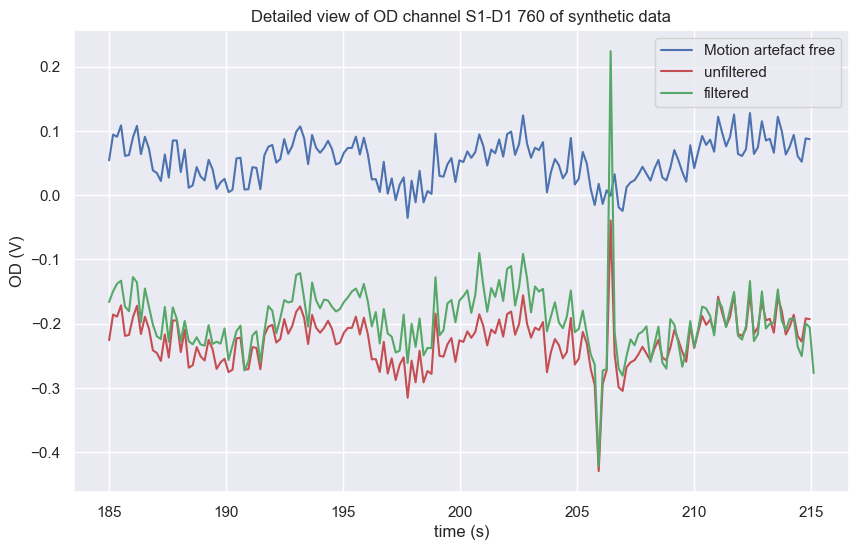

In [122]:
# PCA (r = 2)
# Zoom in on spike of first dataset (Look for good segment in full recording first)
%matplotlib inline
tmin, tmax = 185, 215
data_clean = raw_synth_od_cleans[0].copy().pick(0).crop(tmin,tmax).get_data()[0]
data_unfiltered = raw_synth_od_unfiltereds[0].copy().pick(0).crop(tmin,tmax).get_data()[0]
data_filtered = raw_synth_od_filtered_PCAs_2[0].copy().pick(0).crop(tmin - t_start_trials[0],tmax - t_start_trials[0]).get_data()[0]
t = np.arange(len(data_clean))/sfreq + tmin
t2 = np.arange(len(data_filtered))/sfreq + tmin
plt.plot(t, data_clean, label = 'Motion artefact free', color = 'b')
plt.plot(t, data_unfiltered, label = 'unfiltered', color = 'r')
plt.plot(t2, data_filtered, label = 'filtered', color = 'g')
plt.xlabel('time (s)')
plt.ylabel('OD (V)')
plt.title('Detailed view of OD channel S1-D1 760 of synthetic data')
plt.legend()
if export:
    plt.savefig('PCA/PCA_2_synth_detail.png')

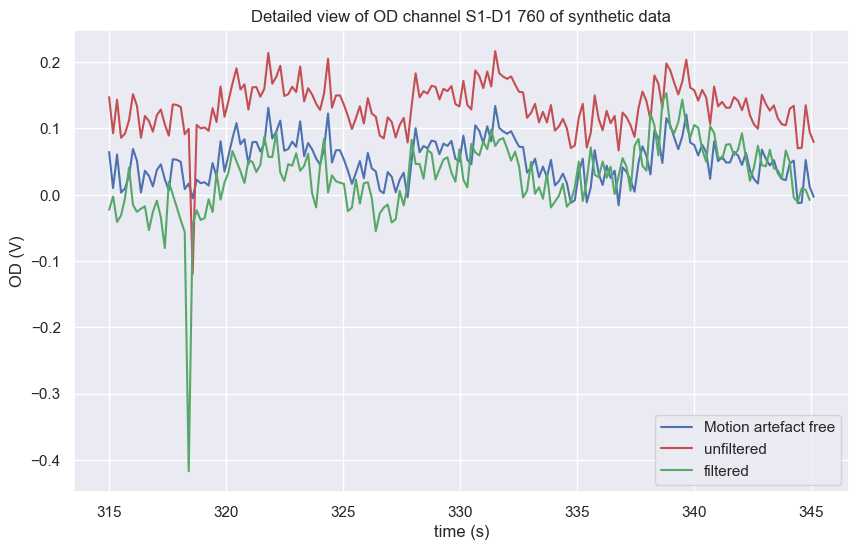

In [123]:
# Zoom in on baseline shift of first data
%matplotlib inline
tmin, tmax = 315, 345
data_clean = raw_synth_od_cleans[0].copy().pick(0).crop(tmin,tmax).get_data()[0]
data_unfiltered = raw_synth_od_unfiltereds[0].copy().pick(0).crop(tmin,tmax).get_data()[0]
data_filtered = raw_synth_od_filtered_PCAs_2[0].copy().pick(0).crop(tmin - t_start_trials[0],tmax - t_start_trials[0]).get_data()[0]
t = np.arange(len(data_clean))/sfreq + tmin 
t2 = np.arange(len(data_filtered))/sfreq + tmin
plt.plot(t, data_clean, label = 'Motion artefact free', color = 'b')
plt.plot(t, data_unfiltered, label = 'unfiltered', color = 'r')
plt.plot(t2, data_filtered, label = 'filtered', color = 'g')
plt.xlabel('time (s)')
plt.ylabel('OD (V)')
plt.title('Detailed view of OD channel S1-D1 760 of synthetic data')
plt.legend()
if export:
    plt.savefig('PCA/PCA_2_synth_detail2.png')

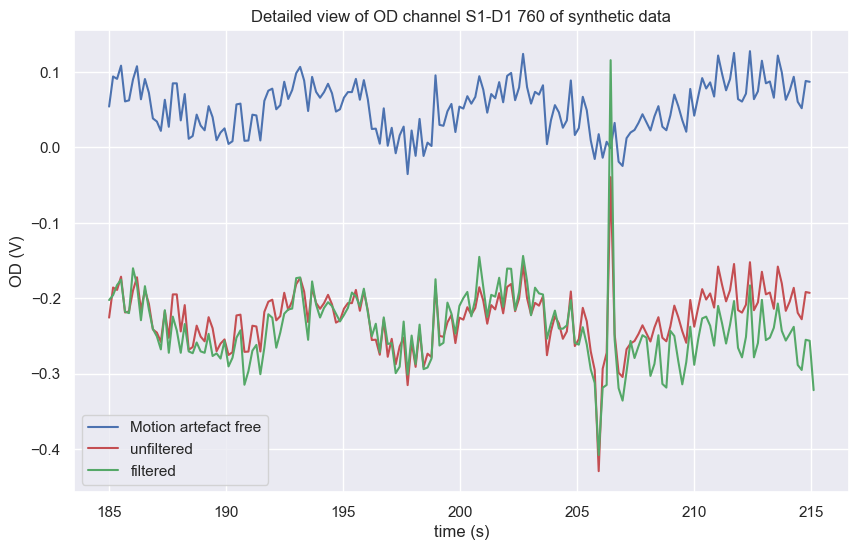

In [124]:
# PCA (r = 3)
# Zoom in on spike of first dataset (Look for good segment in full recording first)
%matplotlib inline
tmin, tmax = 185, 215
data_clean = raw_synth_od_cleans[0].copy().pick(0).crop(tmin,tmax).get_data()[0]
data_unfiltered = raw_synth_od_unfiltereds[0].copy().pick(0).crop(tmin,tmax).get_data()[0]
data_filtered = raw_synth_od_filtered_PCAs_3[0].copy().pick(0).crop(tmin - t_start_trials[0],tmax - t_start_trials[0]).get_data()[0]
t = np.arange(len(data_clean))/sfreq + tmin
t2 = np.arange(len(data_filtered))/sfreq + tmin
plt.plot(t, data_clean, label = 'Motion artefact free', color = 'b')
plt.plot(t, data_unfiltered, label = 'unfiltered', color = 'r')
plt.plot(t2, data_filtered, label = 'filtered', color = 'g')
plt.xlabel('time (s)')
plt.ylabel('OD (V)')
plt.title('Detailed view of OD channel S1-D1 760 of synthetic data')
plt.legend()
if export:
    plt.savefig('PCA/PCA_3_synth_detail.png')

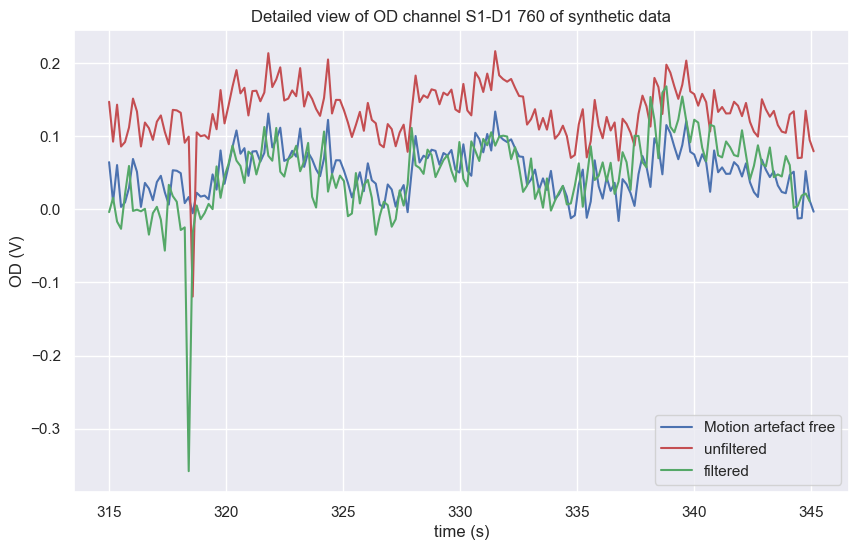

In [125]:
# Zoom in on baseline shift of first data
%matplotlib inline
tmin, tmax = 315, 345
data_clean = raw_synth_od_cleans[0].copy().pick(0).crop(tmin,tmax).get_data()[0]
data_unfiltered = raw_synth_od_unfiltereds[0].copy().pick(0).crop(tmin,tmax).get_data()[0]
data_filtered = raw_synth_od_filtered_PCAs_3[0].copy().pick(0).crop(tmin - t_start_trials[0],tmax - t_start_trials[0]).get_data()[0]
t = np.arange(len(data_clean))/sfreq + tmin 
t2 = np.arange(len(data_filtered))/sfreq + tmin
plt.plot(t, data_clean, label = 'Motion artefact free', color = 'b')
plt.plot(t, data_unfiltered, label = 'unfiltered', color = 'r')
plt.plot(t2, data_filtered, label = 'filtered', color = 'g')
plt.xlabel('time (s)')
plt.ylabel('OD (V)')
plt.title('Detailed view of OD channel S1-D1 760 of synthetic data')
plt.legend()
if export:
    plt.savefig('PCA/PCA_3_synth_detail2.png')

###### Examine PCA components

In [126]:
# # filtered
# X_filtered = raw_synth_haemo_filtered_PCA.get_data().T
# # removing the mean and scaling to unit variance
# x_scaled_filtered = StandardScaler().fit_transform(X_filtered)

# pca_filtered = PCA() 
 
# # Fit and transform data
# pca_features_filtered = pca_filtered.fit_transform(x_scaled_filtered)

# # Unfiltered
# X_unfiltered = raw_synth_haemo_unfiltered.get_data().T
# # removing the mean and scaling to unit variance
# x_scaled_unfiltered = StandardScaler().fit_transform(X_unfiltered)

# pca_unfiltered = PCA()

# # Fit and transform data
# pca_features_unfiltered = pca_unfiltered.fit_transform(x_scaled_unfiltered)

# # Scree Plots
# fig, axes = plt.subplots(1, 2, figsize=(11, 5))

# # Plot for filtered data
# axes[0].bar(range(1, len(pca_filtered.explained_variance_) + 1), pca_filtered.explained_variance_)
# axes[0].plot(range(1, len(pca_filtered.explained_variance_) + 1), np.cumsum(pca_filtered.explained_variance_), c='red', label='Cumulative Explained Variance')
# axes[0].legend(loc='upper left')
# axes[0].set_xlabel('Number of components')
# axes[0].set_ylabel('Explained variance (eigenvalues)')
# axes[0].set_title('Scree Plot - Filtered Data')

# # Plot for unfiltered data
# axes[1].bar(range(1, len(pca_unfiltered.explained_variance_) + 1), pca_unfiltered.explained_variance_)
# axes[1].plot(range(1, len(pca_unfiltered.explained_variance_) + 1), np.cumsum(pca_unfiltered.explained_variance_), c='red', label='Cumulative Explained Variance')
# axes[1].legend(loc='upper left')
# axes[1].set_xlabel('Number of components')
# axes[1].set_ylabel('Explained variance (eigenvalues)')
# axes[1].set_title('Scree Plot - Unfiltered Data')

# # Adjust layout
# plt.tight_layout()
# plt.show()

##### Evaluate filter method (Only stimulus segement)

In [127]:
# SNR (OD data)
DeltaSNR_synth_od_PCAs_2 = dict()
DeltaSNR_synth_od_PCAs_3 = dict()
for i in range(n_set):
    DeltaSNR_synth_od_PCAs_2[i] = get_DeltaSNR(raw_synth_od_cleans[i].copy().crop(t_start_trials[i], t_stop_trials[i]), raw_synth_od_filtered_PCAs_2[i], raw_synth_od_unfiltereds[i].copy().crop(t_start_trials[i], t_stop_trials[i]))
    DeltaSNR_synth_od_PCAs_3[i] = get_DeltaSNR(raw_synth_od_cleans[i].copy().crop(t_start_trials[i], t_stop_trials[i]), raw_synth_od_filtered_PCAs_3[i], raw_synth_od_unfiltereds[i].copy().crop(t_start_trials[i], t_stop_trials[i]))

In [128]:
# PRD (OD data)
PRD_synth_od_PCAs_2 = dict()
PRD_synth_od_PCAs_3 = dict()
for i in range(n_set):
    PRD_synth_od_PCAs_2[i] = get_PRD(raw_synth_od_cleans[i].copy().crop(t_start_trials[i], t_stop_trials[i]), raw_synth_od_filtered_PCAs_2[i], raw_synth_od_unfiltereds[i].copy().crop(t_start_trials[i], t_stop_trials[i]))
    PRD_synth_od_PCAs_3[i] = get_PRD(raw_synth_od_cleans[i].copy().crop(t_start_trials[i], t_stop_trials[i]), raw_synth_od_filtered_PCAs_3[i], raw_synth_od_unfiltereds[i].copy().crop(t_start_trials[i], t_stop_trials[i]))

In [129]:
# CC (OD data)
DeltaCC_synth_od_PCAs_2 = dict()
DeltaCC_synth_od_PCAs_3 = dict()
for i in range(n_set):
    DeltaCC_synth_od_PCAs_2[i] = get_DeltaCC(raw_synth_od_cleans[i].copy().crop(t_start_trials[i], t_stop_trials[i]), raw_synth_od_filtered_PCAs_2[i], raw_synth_od_unfiltereds[i].copy().crop(t_start_trials[i], t_stop_trials[i]))
    DeltaCC_synth_od_PCAs_3[i] = get_DeltaCC(raw_synth_od_cleans[i].copy().crop(t_start_trials[i], t_stop_trials[i]), raw_synth_od_filtered_PCAs_3[i], raw_synth_od_unfiltereds[i].copy().crop(t_start_trials[i], t_stop_trials[i]))

In [130]:
# CNR Cooper (haemo data)
CNR_cooper_synth_haemo_PCAs_2 = dict()
CNR_cooper_synth_haemo_PCAs_3 = dict()
for i in range(n_set):
    print(i)
    CNR_cooper_synth_haemo_PCAs_2[i] = get_CNR_Cooper(raw_synth_haemo_filtered_PCAs_2[i], raw_synth_haemo_unfiltereds[i].copy().crop(t_start_trials[i], t_stop_trials[i]), reject_criteria = reject_criteria, tmin = tmin_CNR, tmax = tmax_CNR, t_peak = t_peak, real_HRF = real_HRF)
    CNR_cooper_synth_haemo_PCAs_3[i] = get_CNR_Cooper(raw_synth_haemo_filtered_PCAs_3[i], raw_synth_haemo_unfiltereds[i].copy().crop(t_start_trials[i], t_stop_trials[i]), reject_criteria = reject_criteria, tmin = tmin_CNR, tmax = tmax_CNR, t_peak = t_peak, real_HRF = real_HRF)

0
Used Annotations descriptions: ['Shift', 'Spike', 'Task']
Not setting metadata
35 matching events found
Setting baseline interval to [-5.9523809523809526, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 35 events and 212 original time points ...
2 bad epochs dropped
Not setting metadata
35 matching events found
Setting baseline interval to [-5.9523809523809526, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 35 events and 212 original time points ...
2 bad epochs dropped
Used Annotations descriptions: ['Shift', 'Spike', 'Task']
Not setting metadata
35 matching events found
Setting baseline interval to [-5.9523809523809526, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 35 events and 212 original time points ...
2 bad epochs dropped
Not setting metadata
35 matching events found
Setting baseline 

In [131]:
# CNR Zhang (haemo data)
CNR_zhang_synth_haemo_PCAs_2 = dict()
CNR_zhang_synth_haemo_PCAs_3 = dict()
for i in range(n_set):
    CNR_zhang_synth_haemo_PCAs_2[i] = get_CNR_Zhang(raw_synth_haemo_filtered_PCAs_2[i], raw_synth_haemo_unfiltereds[i].copy().crop(t_start_trials[i], t_stop_trials[i]), reject_criteria = reject_criteria)
    CNR_zhang_synth_haemo_PCAs_3[i] = get_CNR_Zhang(raw_synth_haemo_filtered_PCAs_3[i], raw_synth_haemo_unfiltereds[i].copy().crop(t_start_trials[i], t_stop_trials[i]), reject_criteria = reject_criteria)

Used Annotations descriptions: ['Shift', 'Spike', 'Task']
Not setting metadata
35 matching events found
Setting baseline interval to [-14.965986394557824, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 35 events and 207 original time points ...
1 bad epochs dropped
Not setting metadata
35 matching events found
Setting baseline interval to [-14.965986394557824, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 35 events and 207 original time points ...
1 bad epochs dropped
Used Annotations descriptions: ['Shift', 'Spike', 'Task']
Not setting metadata
35 matching events found
Setting baseline interval to [-14.965986394557824, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 35 events and 207 original time points ...
1 bad epochs dropped
Not setting metadata
35 matching events found
Setting baseline in

In [132]:
#APA (OD data)
events_synth_PCAs, event_dict_synth_PCAs = dict(), dict()
APA_synth_od_PCAs_2 = dict()
APA_synth_od_PCAs_3 = dict()

for i in range(n_set):
    # Because length changed, event ids are not correct anymore
    events_synth_PCAs[i], event_dict_synth_PCAs[i] = mne.events_from_annotations(raw_synth_od_filtered_PCAs_2[i])
    
    ids = [event_dict_synth_PCAs[i]['Spike'], event_dict_synth_PCAs[i]['Shift']]
    start_ind = events_synth_PCAs[i][np.isin(events_synth_PCAs[i][:,2], ids)][:,0] - events_synth_PCAs[i][0,0] - int(5*sfreq) # 5 seconds before artefact
    start_ind = np.where(start_ind < 0, 0, start_ind)
    stop_ind = start_ind + int(10*sfreq) # 5 seconds after artefact
    
    Am_synth = zip(start_ind, stop_ind)
    
    APA_synth_od_PCAs_2[i] = get_APA(raw_synth_od_filtered_PCAs_2[i], raw_synth_od_unfiltereds[i].copy().crop(t_start_trials[i], t_stop_trials[i]), Am_synth, l_freq, l_trans_bandwidth = l_trans_bandwidth)
    APA_synth_od_PCAs_3[i] = get_APA(raw_synth_od_filtered_PCAs_3[i], raw_synth_od_unfiltereds[i].copy().crop(t_start_trials[i], t_stop_trials[i]), Am_synth, l_freq, l_trans_bandwidth = l_trans_bandwidth)

Used Annotations descriptions: ['Shift', 'Spike', 'Task']
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 1.35 Hz)
- Filter length: 65 samples (11.054 s)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 1.35 Hz)
- Filter length: 65 samples (11.054 s)

Filtering raw data in 1 contiguous segment

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 1.35 Hz)
- Filter length: 65 samples (11.054 s)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 1.35 Hz)
- Filter length: 65 samples (11.054 s)

Used Annotations descriptions: ['Shift', 'Spike', 'Task']
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter parameters
-------------------

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 1.35 Hz)
- Filter length: 65 samples (11.054 s)

Used Annotations descriptions: ['Shift', 'Spike', 'Task']
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 1.35 Hz)
- Filter length: 65 samples (11.054 s)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

##### Perform on motion artefact experiment data

In [133]:
raw_haemo_filtered_PCA_2, t_start_trials, t_stop_trials = PCA_Zhang(raw_haemo, ['test/Horizontal', 'test/Random', 'test/Vertical'], 3, r = 2, tmin = -5, tmax = 15, plot = plot, export = export, filename = '2_MA', xlim = None)
raw_haemo_filtered_PCA_3, t_start_trials, t_stop_trials = PCA_Zhang(raw_haemo, ['test/Horizontal', 'test/Random', 'test/Vertical'], 3, r = 3, tmin = -5, tmax = 15, plot = plot, export = export, filename = '3_MA', xlim = None)

Used Annotations descriptions: ['Baseline', 'practice/Horizontal', 'practice/Random', 'practice/Vertical', 'test/Horizontal', 'test/Random', 'test/Vertical']
Used Annotations descriptions: ['Baseline', 'practice/Horizontal', 'practice/Random', 'practice/Vertical', 'test/Horizontal', 'test/Random', 'test/Vertical']


In [134]:
# Convert to OD data
raw_od_filtered_PCA_2 = inverse_beer_lambert(raw_haemo_filtered_PCA_2, ppf = ppf)
raw_od_filtered_PCA_3 = inverse_beer_lambert(raw_haemo_filtered_PCA_3, ppf = ppf)

S2_D2 760


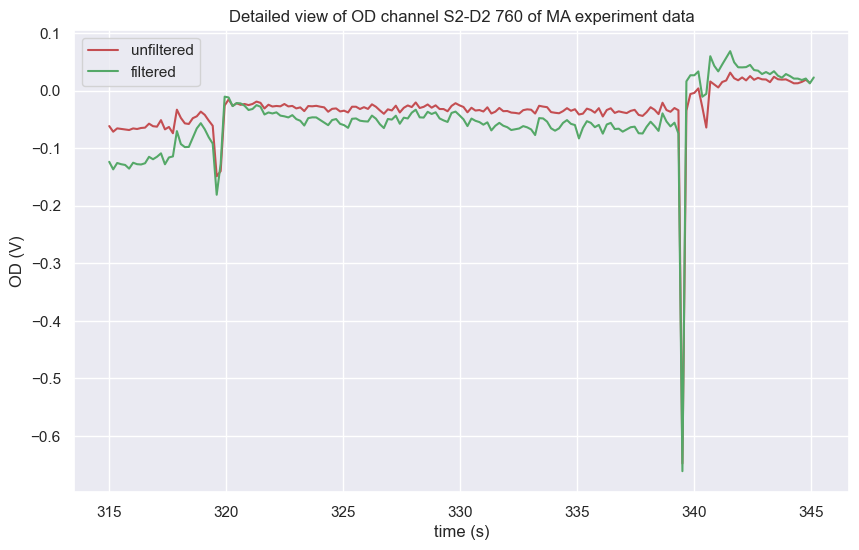

In [135]:
# PCA (r=2)
%matplotlib inline
chan = 2
print(raw_od.ch_names[chan])
tmin, tmax = 315, 345
data_unfiltered = raw_od.copy().pick(chan).crop(tmin,tmax).get_data()[0]
data_filtered = raw_od_filtered_PCA_2.copy().pick(chan).crop(tmin-t_start_trials,tmax-t_start_trials).get_data()[0]
t = np.arange(len(data_unfiltered))/sfreq + tmin
t2 = np.arange(len(data_filtered))/sfreq + tmin
plt.plot(t, data_unfiltered, label = 'unfiltered', color = 'r')
plt.plot(t2, data_filtered, label = 'filtered', color = 'g')
plt.xlabel('time (s)')
plt.ylabel('OD (V)')
plt.title('Detailed view of OD channel S2-D2 760 of MA experiment data')
plt.legend()
if export:
    plt.savefig('PCA/PCA_2_MA_detail.png')

S8_D4 760


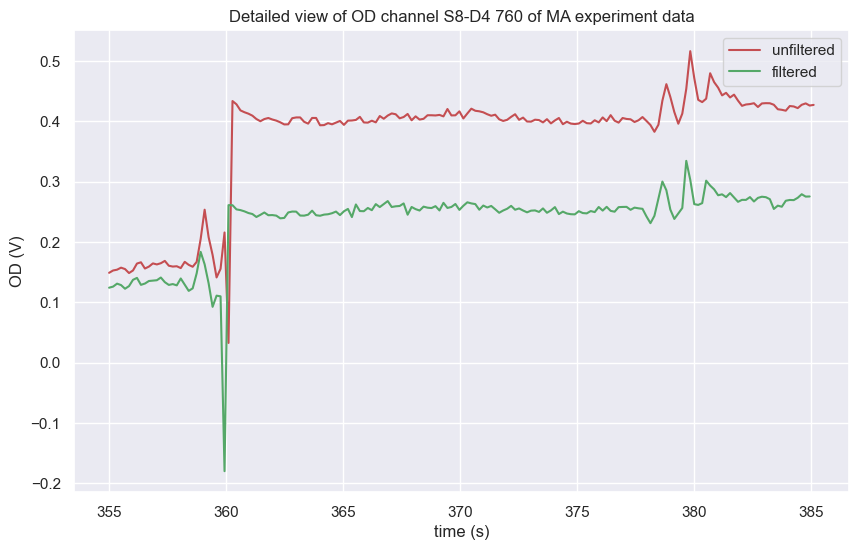

In [136]:
# PCA (r=2)
%matplotlib inline
chan = 22
print(raw_od.ch_names[chan])
tmin, tmax = 355, 385
data_unfiltered = raw_od.copy().pick(chan).crop(tmin,tmax).get_data()[0]
data_filtered = raw_od_filtered_PCA_2.copy().pick(chan).crop(tmin-t_start_trials,tmax-t_start_trials).get_data()[0]
t = np.arange(len(data_unfiltered))/sfreq + tmin
t2 = np.arange(len(data_filtered))/sfreq + tmin
plt.plot(t, data_unfiltered, label = 'unfiltered', color = 'r')
plt.plot(t2, data_filtered, label = 'filtered', color = 'g')
plt.xlabel('time (s)')
plt.ylabel('OD (V)')
plt.title('Detailed view of OD channel S8-D4 760 of MA experiment data')
plt.legend()
if export:
    plt.savefig('PCA/PCA_2_MA_detail2.png')

S2_D2 760


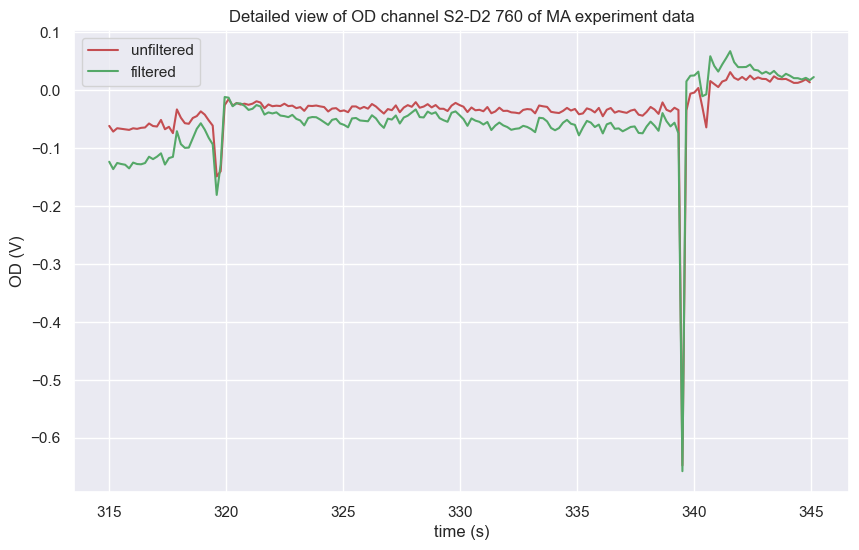

In [137]:
# PCA (r=3)
%matplotlib inline
chan = 2
print(raw_od.ch_names[chan])
tmin, tmax = 315, 345
data_unfiltered = raw_od.copy().pick(chan).crop(tmin,tmax).get_data()[0]
data_filtered = raw_od_filtered_PCA_3.copy().pick(chan).crop(tmin-t_start_trials,tmax-t_start_trials).get_data()[0]
t = np.arange(len(data_unfiltered))/sfreq + tmin
t2 = np.arange(len(data_filtered))/sfreq + tmin
plt.plot(t, data_unfiltered, label = 'unfiltered', color = 'r')
plt.plot(t2, data_filtered, label = 'filtered', color = 'g')
plt.xlabel('time (s)')
plt.ylabel('OD (V)')
plt.title('Detailed view of OD channel S2-D2 760 of MA experiment data')
plt.legend()
if export:
    plt.savefig('PCA/PCA_3_MA_detail.png')

S8_D4 760


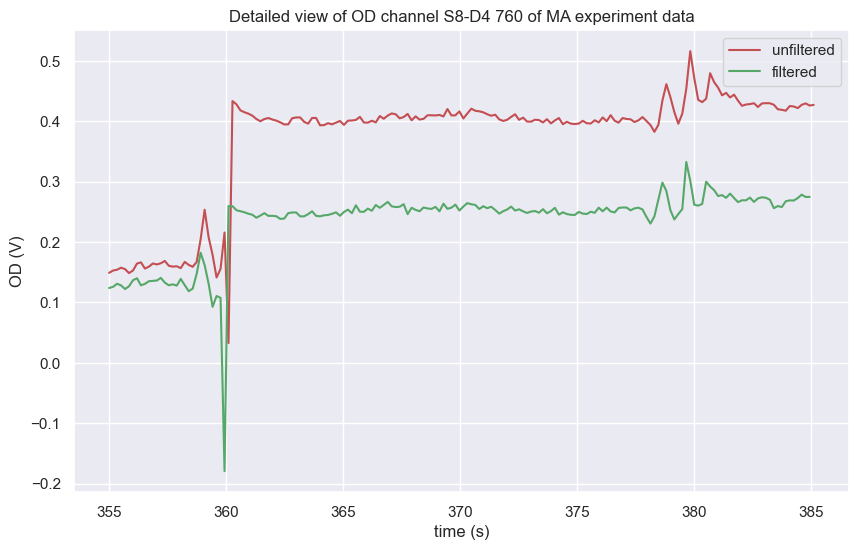

In [138]:
# PCA (r=3)
%matplotlib inline
chan = 22
print(raw_od.ch_names[chan])
tmin, tmax = 355, 385
data_unfiltered = raw_od.copy().pick(chan).crop(tmin,tmax).get_data()[0]
data_filtered = raw_od_filtered_PCA_3.copy().pick(chan).crop(tmin-t_start_trials,tmax-t_start_trials).get_data()[0]
t = np.arange(len(data_unfiltered))/sfreq + tmin
t2 = np.arange(len(data_filtered))/sfreq + tmin
plt.plot(t, data_unfiltered, label = 'unfiltered', color = 'r')
plt.plot(t2, data_filtered, label = 'filtered', color = 'g')
plt.xlabel('time (s)')
plt.ylabel('OD (V)')
plt.title('Detailed view of OD channel S8-D4 760 of MA experiment data')
plt.legend()
if export:
    plt.savefig('PCA/PCA_3_MA_detail2.png')

###### Evaluation filter method

In [139]:
#APA (OD data)

# Because length changed, event ids are not correct anymore
events_PCA, event_dict_PCA = mne.events_from_annotations(raw_haemo_filtered_PCA_2)

ids = [event_dict_PCA['test/Horizontal'], event_dict_PCA['test/Random'], event_dict_PCA['test/Vertical']]
start_ind = events_PCA[np.isin(events_PCA[:,2], ids)][:,0] - events_PCA[0,0] - int(5*sfreq) # 5 seconds before artefact
start_ind = np.where(start_ind < 0, 0, start_ind)
stop_ind = start_ind + int(15*sfreq) # 10 seconds after artefact

Am = zip(start_ind, stop_ind)

APA_od_PCA_2 = get_APA(raw_od_filtered_PCA_2, raw_od.copy().crop(t_start_trials, t_stop_trials), Am, l_freq, l_trans_bandwidth = l_trans_bandwidth)
APA_od_PCA_3 = get_APA(raw_od_filtered_PCA_3, raw_od.copy().crop(t_start_trials, t_stop_trials), Am, l_freq, l_trans_bandwidth = l_trans_bandwidth)

Used Annotations descriptions: ['test/Horizontal', 'test/Random', 'test/Vertical']
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 1.35 Hz)
- Filter length: 65 samples (11.050 s)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 1.35 Hz)
- Filter length: 65 samples (11.050 s)

Filtering raw dat

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

---
> *Remark:*
- For both methods, spikes are not well removed
- For both methods, baseline shifts are not well removed
- Introduction of baseline shifts where they were previously not present
---

#### Independent component analysis <a class="anchor" id="sub_section_1_6_5"></a>

ICA is a blind source separation technique utilized to decompose fNIRS data into multiple source components and their associated weights (Zhao et al., 2021). Prior to applying ICA, a prewhitening stage is executed using PCA to mitigate the risk of over-fitting and to reduce the computational cost. Subsequently, ICA disentangles the fNIRS signals into a weighted summation of multiple independent sources.

The prevalent ICA algorithms in fNIRS literature include FastICA and SOBI, leveraging high-order statistics (HOS) and sample dependence (SOS), respectively. Following this, the separated sources undergo manual selection based on spatial and temporal characteristics, aided by quantitative metrics such as the MSD, the coefficient of spatial uniformity (CSU) or the correlation with an external input (CEI). 

The CEI assesses sources by correlating their time courses with those recorded by external devices like accelerometers, physiological instruments or short channels, using Pearson’s correlation coefficient. Meanwhile, CSU quantifies the spatial map of sources, calculated by the ratio of the mean to the standard deviation of the spatial map of each source. 
$$CSU(i) = |\frac{\overline{c_i}}{\sigma ( c_i ) }|$$
In the final stage of the ICA process, noise sources are discarded to reconstruct the clean fNIRS signals, which are then susceptible to analysis using conventional techniques. 

ICA operates on the assumption that the source signals are statistically independent and can be applied to optical intensities, optical densities, and concentration changes. 


In [140]:
# Using ICA interface in MNE-Python (similar to the interface in scikit-learn)
def ICA_nirs(raw_input, n_components = 0.99, method = 'fastica', score_method = 'MSD', IMU_df = None, plot = False, xlim = None, export = False, filename = None):
    
    raw = raw_input.copy()
    fs = raw.info['sfreq']
    data = raw.get_data()
    
    # 'Before we run the ICA, an important step is filtering the data to remove low-frequency drifts'
    # --> Not feasable as important information is under 1 Hz

    # Scaling to unit variance and whitened using PCA 
    ica = ICA(n_components = n_components, method = method) 
    ica.fit(raw)
    print(ica)

    # # Plot ICA sources
    # if plot:
    #     %matplotlib qt
    #     ica.plot_sources(raw, show_scrollbars = True);

    # Get sources data for score calculation
    ica_sources = ica.get_sources(raw).get_data()
    
    if score_method == 'MSD':
        # Perform MSD
        # W = 2*k + 1 should be similar to the period of spikes that users aimed to identify. See Zhao et al. (2021)
        t_spike = 1
        samples_spike = t_spike*raw.info['sfreq']
        k = int(samples_spike//2)
        n = 3 # Threshold 3 std from the mean
        
        scores = []
        for i in range(ica_sources.shape[0]):
            s = MSD(ica_sources[i], k)
            T = np.nanmean(s) + n*np.nanstd(s)
            score = np.sum(np.where(s > T, 1, 0))
            scores.append(score)
        scores = np.array(scores)

    elif score_method == 'CEI':
        # Perform correlation with external input
        # Need IMU data  
        IMU = IMU_df.to_numpy().T
        scores = []
        for i in range(ica_sources.shape[0]):
            corr_xyz = []
            for j in range(6): # x, y and z acc + 3 gyro recorded
                corr = pearsonr(ica_sources[i], IMU[j])
                corr_xyz.append(corr)
            # Take mean?
            score = np.mean(np.array(corr_xyz))
            scores.append(score)

    else:
        raise ValueError('Please add scoring method')
        
    if plot: 
        # Plot scores
        %matplotlib inline
        fig = ica.plot_scores(scores)
        if export:
            if filename == None:
                raise ValueError('Filename must be given to export figures')
            fig.savefig('ICA/ICA_scores' + filename + '.png')
    
    # Remove source with highest score
    ica.exclude = [np.argmax(np.array(scores))]

    # Reconstruct to get clean fNIRS
    # ICA apply() does:
        # 1) Unmixes the data with the unmixing_matrix
        # 2) Includes ICA components based on ica.include and ica.exclude
        # 3) Re-mixes the data with mixing_matrix_
        # 4) Restores any data not passed to the ICA algorithm, i.e., the PCA components between n_components and n_pca_components
    reconst_raw = raw.copy()
    ica.apply(reconst_raw)
    data_new = reconst_raw.get_data()
    
    picks = np.sort(_validate_nirs_info(raw.info))
    datatype = raw.ch_names[0][-3:]
    
    for pick in picks:
        if plot:
            # Plot original and new values
            if datatype == 'hbo':
                type = ' hbo' if pick%2 == 0 else ' hbr'
                ylabel = 'HbO/HbR (M)'
            else:
                type = ' wavelength 760' if pick%2 == 0 else ' wavelength 850'
                ylabel = 'OD (V)'
            %matplotlib inline
            time = np.arange(data.shape[1])/fs
            plt.plot(time, data[pick], label = 'original')
            plt.plot(time, data_new[pick], label = 'filtered')
            plt.xlabel('time (s)')
            plt.ylabel(ylabel)
            plt.title('Channel: ' + str(pick//2+1) + type)
            plt.legend()
            if xlim != None:
                plt.xlim(xlim)
            if export:
                if filename == None:
                    raise ValueError('Filename must be given to export figures')
                plt.savefig('ICA/ICA_' + score_method + '_' + filename + '_channel_' + str(pick//2+1) + type + '.png')
            plt.show()

    return reconst_raw

##### Perform on synthetic data

In [141]:
raw_synth_od_filtered_ICAs = dict()
raw_synth_od_filtered_ICAs[0] = ICA_nirs(raw_synth_od_unfiltereds[0], n_components = 0.99, method = 'fastica', score_method = 'MSD', IMU_df = None, plot = plot, xlim = None, export = export, filename = 'synth')
for i in range(1, n_set):
    raw_synth_od_filtered_ICAs[i] = ICA_nirs(raw_synth_od_unfiltereds[i], n_components = 0.99, method = 'fastica', score_method = 'MSD')

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by explained variance: 4 components
Fitting ICA took 0.0s.
<ICA | raw data decomposition, method: fastica (fit in 14 iterations on 2940 samples), 4 ICA components (8 PCA components available), channel types: fnirs_od, no sources marked for exclusion>
Applying ICA to Raw instance
    Transforming to ICA space (4 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by explained variance: 4 components
Fitting ICA took 0.0s.


C:\Users\fabia\AppData\Local\Temp\ipykernel_27420\1915246416.py:13: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)
C:\Users\fabia\AppData\Local\Temp\ipykernel_27420\1915246416.py:13: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


<ICA | raw data decomposition, method: fastica (fit in 14 iterations on 2940 samples), 4 ICA components (8 PCA components available), channel types: fnirs_od, no sources marked for exclusion>
Applying ICA to Raw instance
    Transforming to ICA space (4 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by explained variance: 5 components
Fitting ICA took 0.0s.
<ICA | raw data decomposition, method: fastica (fit in 9 iterations on 2940 samples), 5 ICA components (8 PCA components available), channel types: fnirs_od, no sources marked for exclusion>
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by explained variance: 4 components
Fitting ICA took 0.0s.


C:\Users\fabia\AppData\Local\Temp\ipykernel_27420\1915246416.py:13: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)
C:\Users\fabia\AppData\Local\Temp\ipykernel_27420\1915246416.py:13: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


<ICA | raw data decomposition, method: fastica (fit in 49 iterations on 2940 samples), 4 ICA components (8 PCA components available), channel types: fnirs_od, no sources marked for exclusion>
Applying ICA to Raw instance
    Transforming to ICA space (4 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by explained variance: 4 components
Fitting ICA took 0.0s.
<ICA | raw data decomposition, method: fastica (fit in 14 iterations on 2940 samples), 4 ICA components (8 PCA components available), channel types: fnirs_od, no sources marked for exclusion>
Applying ICA to Raw instance
    Transforming to ICA space (4 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by explained variance: 4 components
Fitting ICA took 0.0s.
<ICA | raw data deco

C:\Users\fabia\AppData\Local\Temp\ipykernel_27420\1915246416.py:13: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)
C:\Users\fabia\AppData\Local\Temp\ipykernel_27420\1915246416.py:13: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Applying ICA to Raw instance
    Transforming to ICA space (4 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by explained variance: 5 components
Fitting ICA took 0.0s.
<ICA | raw data decomposition, method: fastica (fit in 15 iterations on 2940 samples), 5 ICA components (8 PCA components available), channel types: fnirs_od, no sources marked for exclusion>
Applying ICA to Raw instance


C:\Users\fabia\AppData\Local\Temp\ipykernel_27420\1915246416.py:13: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


    Transforming to ICA space (5 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by explained variance: 5 components
Fitting ICA took 0.0s.
<ICA | raw data decomposition, method: fastica (fit in 12 iterations on 2940 samples), 5 ICA components (8 PCA components available), channel types: fnirs_od, no sources marked for exclusion>
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Fitting ICA to data using 8 channels (please be patient, this may take a while)


C:\Users\fabia\AppData\Local\Temp\ipykernel_27420\1915246416.py:13: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)
C:\Users\fabia\AppData\Local\Temp\ipykernel_27420\1915246416.py:13: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Selecting by explained variance: 4 components
Fitting ICA took 0.0s.
<ICA | raw data decomposition, method: fastica (fit in 4 iterations on 2940 samples), 4 ICA components (8 PCA components available), channel types: fnirs_od, no sources marked for exclusion>
Applying ICA to Raw instance
    Transforming to ICA space (4 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by explained variance: 5 components
Fitting ICA took 0.0s.
<ICA | raw data decomposition, method: fastica (fit in 27 iterations on 2940 samples), 5 ICA components (8 PCA components available), channel types: fnirs_od, no sources marked for exclusion>
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components


C:\Users\fabia\AppData\Local\Temp\ipykernel_27420\1915246416.py:13: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


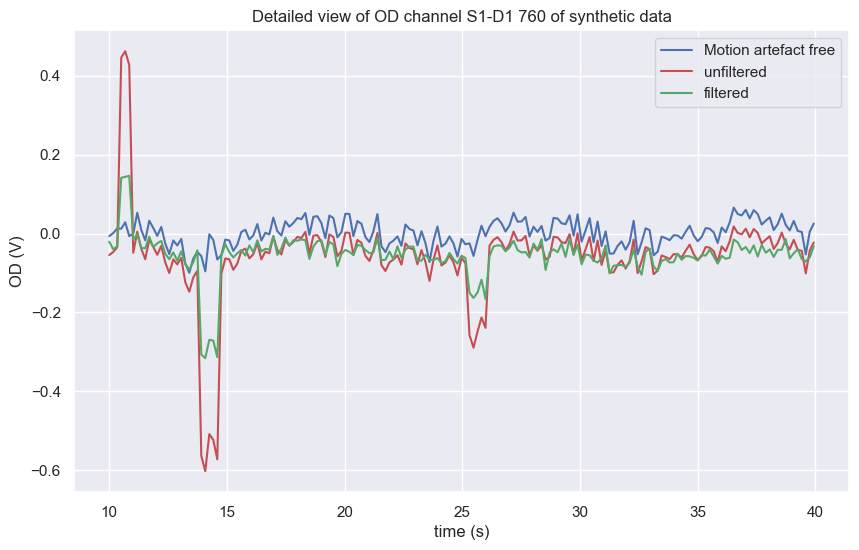

In [142]:
# Zoom in on spike of first dataset (Look for good segment in full recording first)
%matplotlib inline
tmin, tmax = 10, 40
data_clean = raw_synth_od_cleans[0].copy().pick(0).crop(tmin,tmax).get_data()[0]
data_unfiltered = raw_synth_od_unfiltereds[0].copy().pick(0).crop(tmin,tmax).get_data()[0]
data_filtered = raw_synth_od_filtered_ICAs[0].copy().pick(0).crop(tmin,tmax).get_data()[0]
t = np.arange(len(data_clean))/sfreq + tmin
plt.plot(t, data_clean, label = 'Motion artefact free', color = 'b')
plt.plot(t, data_unfiltered, label = 'unfiltered', color = 'r')
plt.plot(t, data_filtered, label = 'filtered', color = 'g')
plt.xlabel('time (s)')
plt.ylabel('OD (V)')
plt.title('Detailed view of OD channel S1-D1 760 of synthetic data')
plt.legend()
if export:
    plt.savefig('ICA/ICA_synth_detail.png')

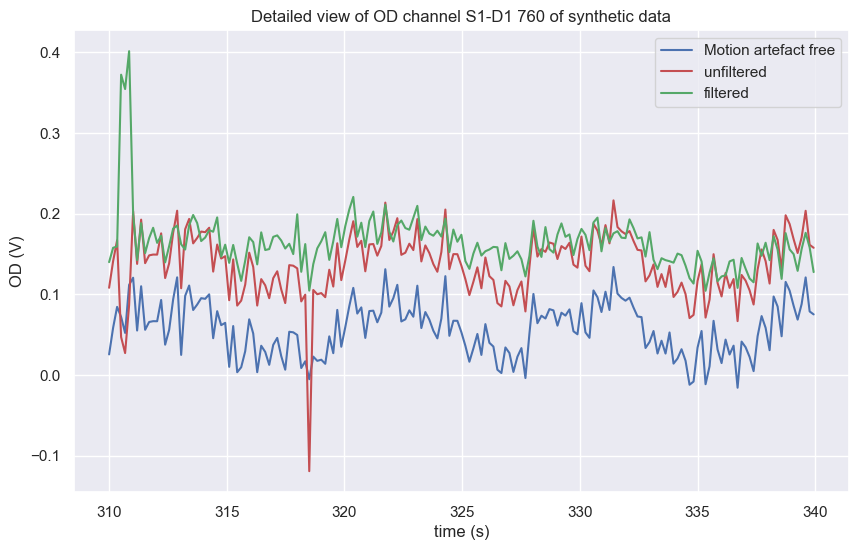

In [143]:
# Zoom in on baseline shift of first data
%matplotlib inline
tmin, tmax = 310, 340
data_clean = raw_synth_od_cleans[0].copy().pick(0).crop(tmin,tmax).get_data()[0]
data_unfiltered = raw_synth_od_unfiltereds[0].copy().pick(0).crop(tmin,tmax).get_data()[0]
data_filtered = raw_synth_od_filtered_ICAs[0].copy().pick(0).crop(tmin,tmax).get_data()[0]
t = np.arange(len(data_clean))/sfreq +tmin
plt.plot(t, data_clean, label = 'Motion artefact free', color = 'b')
plt.plot(t, data_unfiltered, label = 'unfiltered', color = 'r')
plt.plot(t, data_filtered, label = 'filtered', color = 'g')
plt.xlabel('time (s)')
plt.ylabel('OD (V)')
plt.title('Detailed view of OD channel S1-D1 760 of synthetic data')
plt.legend()
if export:
    plt.savefig('ICA/ICA_synth_detail2.png')

###### Evaluate filter method

In [144]:
# SNR (OD data)
DeltaSNR_synth_od_ICAs = dict()
for i in range(n_set):
    DeltaSNR_synth_od_ICAs[i] = get_DeltaSNR(raw_synth_od_cleans[i], raw_synth_od_filtered_ICAs[i], raw_synth_od_unfiltereds[i])

In [145]:
# PRD (OD data)
PRD_synth_od_ICAs = dict()
for i in range(n_set):
    PRD_synth_od_ICAs[i] = get_PRD(raw_synth_od_cleans[i], raw_synth_od_filtered_ICAs[i], raw_synth_od_unfiltereds[i])

In [146]:
# CC (OD data)
DeltaCC_synth_od_ICAs = dict()
for i in range(n_set):
    DeltaCC_synth_od_ICAs[i] = get_DeltaCC(raw_synth_od_cleans[i], raw_synth_od_filtered_ICAs[i], raw_synth_od_unfiltereds[i])

In [147]:
# CNR Cooper (haemo data)
raw_synth_haemo_filtered_ICAs = dict()
CNR_cooper_synth_haemo_ICAs = dict()
for i in range(n_set):
    raw_synth_haemo_filtered_ICAs[i] = beer_lambert_law(raw_synth_od_filtered_ICAs[i], ppf = ppf)
    CNR_cooper_synth_haemo_ICAs[i] = get_CNR_Cooper(raw_synth_haemo_filtered_ICAs[i], raw_synth_haemo_unfiltereds[i], reject_criteria = reject_criteria, tmin = tmin_CNR, tmax = tmax_CNR, t_peak = t_peak, real_HRF = real_HRF)

Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Not setting metadata
53 matching events found
Setting baseline interval to [-5.9523809523809526, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 53 events and 212 original time points ...
5 bad epochs dropped
Not setting metadata
53 matching events found
Setting baseline interval to [-5.9523809523809526, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 53 events and 212 original time points ...
5 bad epochs dropped
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Not setting metadata
53 matching events found
Setting baseline interval to [-5.9523809523809526, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 53 events and 212 original time points ...
5 bad epochs dropped
Not setting metadata
53 matching events f

In [148]:
# CNR Zhang (haemo data)
CNR_zhang_synth_haemo_ICAs = dict()
for i in range(n_set):
    CNR_zhang_synth_haemo_ICAs[i] = get_CNR_Zhang(raw_synth_haemo_filtered_ICAs[i], raw_synth_haemo_unfiltereds[i], reject_criteria = reject_criteria)

Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Not setting metadata
53 matching events found
Setting baseline interval to [-14.965986394557824, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 53 events and 207 original time points ...
7 bad epochs dropped
Not setting metadata
53 matching events found
Setting baseline interval to [-14.965986394557824, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 53 events and 207 original time points ...
7 bad epochs dropped
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Not setting metadata
53 matching events found
Setting baseline interval to [-14.965986394557824, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 53 events and 207 original time points ...
4 bad epochs dropped
Not setting metadata
53 matching events f

In [149]:
#APA (OD data)
APA_synth_od_ICAs = dict()
for i in range(n_set):
    ids = [event_dict_synths[i]['Spike'], event_dict_synths[i]['Shift']]
    
    start_ind = events_synths[i][np.isin(events_synths[i][:,2], ids)][:,0] - int(5*sfreq) # 5 seconds before artefact
    start_ind = np.where(start_ind < 0, 0, start_ind)
    stop_ind = start_ind + int(10*sfreq) # 5 seconds after artefact
    Am_synth = zip(start_ind, stop_ind)
    
    APA_synth_od_ICAs[i] = get_APA(raw_synth_od_filtered_ICAs[i], raw_synth_od_unfiltereds[i], Am_synth, l_freq, l_trans_bandwidth = l_trans_bandwidth)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 1.35 Hz)
- Filter length: 65 samples (11.054 s)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 1.35 Hz)
- Filter length: 65 samples (11.054 s)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter paramet

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

- Lower passband edge: 1.50
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 1.35 Hz)
- Filter length: 65 samples (11.054 s)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 1.35 Hz)
- Filter length: 65 samples (11.054 s)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 1.35 Hz)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

##### Perform on motion artefact experiment data

In [150]:
# MSD
raw_od_filtered_ICA_MSD = ICA_nirs(raw_od, n_components = 0.99, method = 'fastica', score_method = 'MSD', IMU_df = None, plot = plot, xlim = None, export = export, filename = 'MA')

Fitting ICA to data using 52 channels (please be patient, this may take a while)
Selecting by explained variance: 5 components
Fitting ICA took 0.0s.
<ICA | raw data decomposition, method: fastica (fit in 15 iterations on 5163 samples), 5 ICA components (52 PCA components available), channel types: fnirs_od, no sources marked for exclusion>


C:\Users\fabia\AppData\Local\Temp\ipykernel_27420\1915246416.py:13: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 1 ICA component
    Projecting back using 52 PCA components


In [151]:
# CEI
raw_od_filtered_ICA_CEI = ICA_nirs(raw_od, n_components = 0.99, method = 'fastica', score_method = 'CEI', IMU_df = IMU_data, plot = plot, xlim = None, export = export, filename = 'MA')

Fitting ICA to data using 52 channels (please be patient, this may take a while)
Selecting by explained variance: 5 components
Fitting ICA took 0.1s.
<ICA | raw data decomposition, method: fastica (fit in 13 iterations on 5163 samples), 5 ICA components (52 PCA components available), channel types: fnirs_od, no sources marked for exclusion>
Applying ICA to Raw instance
    Transforming to ICA space (5 components)
    Zeroing out 1 ICA component
    Projecting back using 52 PCA components


C:\Users\fabia\AppData\Local\Temp\ipykernel_27420\1915246416.py:13: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


S2_D2 760


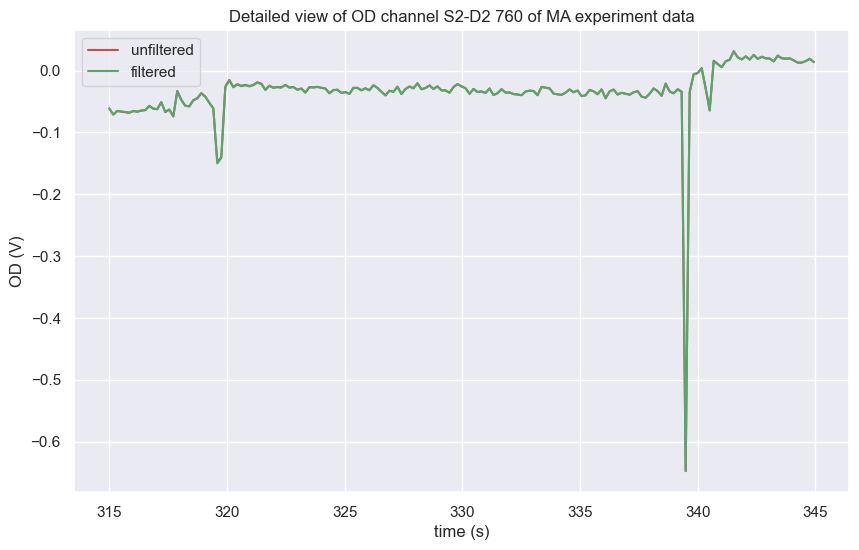

In [152]:
# MSD
%matplotlib inline
chan = 2
print(raw_od.ch_names[chan])
tmin, tmax = 315, 345
data_unfiltered = raw_od.copy().pick(chan).crop(tmin,tmax).get_data()[0]
data_filtered = raw_od_filtered_ICA_MSD.copy().pick(chan).crop(tmin,tmax).get_data()[0]
t = np.arange(len(data_unfiltered))/sfreq + tmin
plt.plot(t, data_unfiltered, label = 'unfiltered', color = 'r')
plt.plot(t, data_filtered, label = 'filtered', color = 'g')
plt.xlabel('time (s)')
plt.ylabel('OD (V)')
plt.title('Detailed view of OD channel S2-D2 760 of MA experiment data')
plt.legend()
if export:
    plt.savefig('ICA/ICA_MSD_MA_detail.png')

S2_D2 760


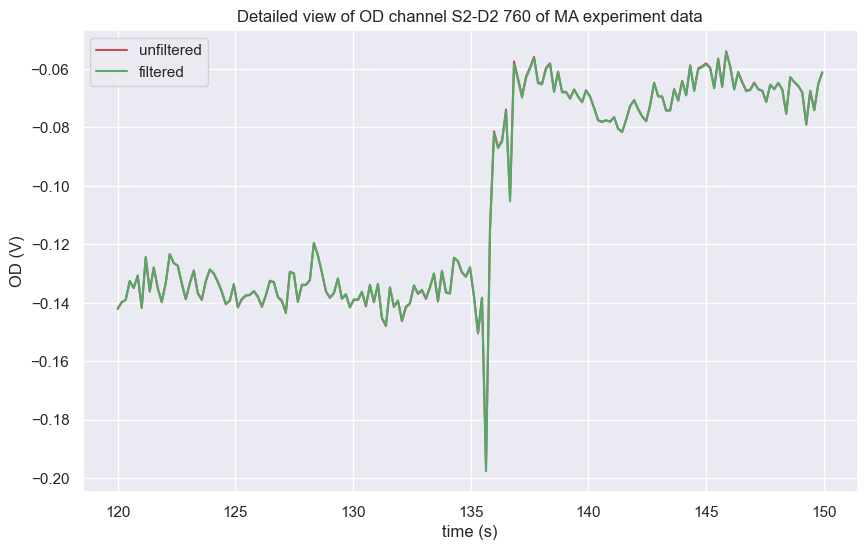

In [153]:
# MSD
%matplotlib inline
chan = 2
print(raw_od.ch_names[chan])
tmin, tmax = 120, 150
data_unfiltered = raw_od.copy().pick(chan).crop(tmin,tmax).get_data()[0]
data_filtered = raw_od_filtered_ICA_MSD.copy().pick(chan).crop(tmin,tmax).get_data()[0]
t = np.arange(len(data_unfiltered))/sfreq + tmin
plt.plot(t, data_unfiltered, label = 'unfiltered', color = 'r')
plt.plot(t, data_filtered, label = 'filtered', color = 'g')
plt.xlabel('time (s)')
plt.ylabel('OD (V)')
plt.title('Detailed view of OD channel S2-D2 760 of MA experiment data')
plt.legend()
if export:
    plt.savefig('ICA/ICA_MSD_MA_detail2.png')

S2_D2 760


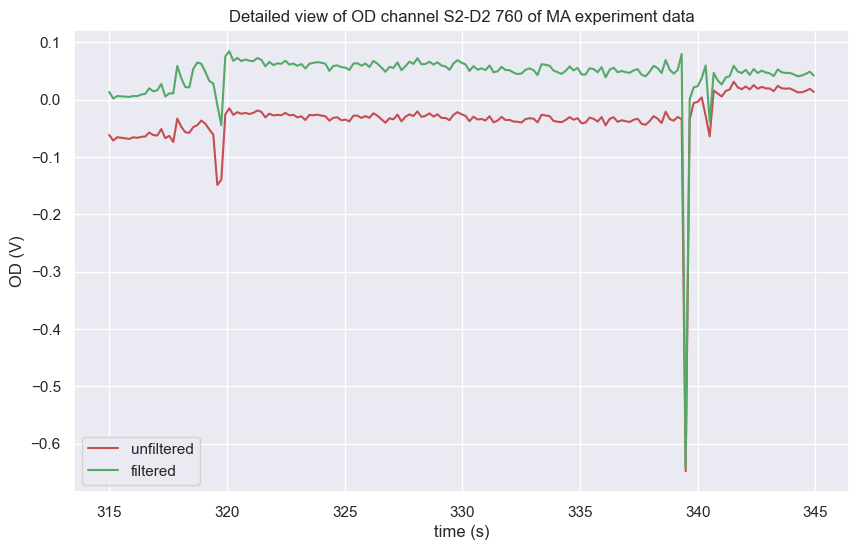

In [154]:
# CEI
%matplotlib inline
chan = 2
print(raw_od.ch_names[chan])
tmin, tmax = 315, 345
data_unfiltered = raw_od.copy().pick(chan).crop(tmin,tmax).get_data()[0]
data_filtered = raw_od_filtered_ICA_CEI.copy().pick(chan).crop(tmin,tmax).get_data()[0]
t = np.arange(len(data_unfiltered))/sfreq + tmin
plt.plot(t, data_unfiltered, label = 'unfiltered', color = 'r')
plt.plot(t, data_filtered, label = 'filtered', color = 'g')
plt.xlabel('time (s)')
plt.ylabel('OD (V)')
plt.title('Detailed view of OD channel S2-D2 760 of MA experiment data')
plt.legend()
if export:
    plt.savefig('ICA/ICA_CEI_MA_detail.png')

S2_D2 760


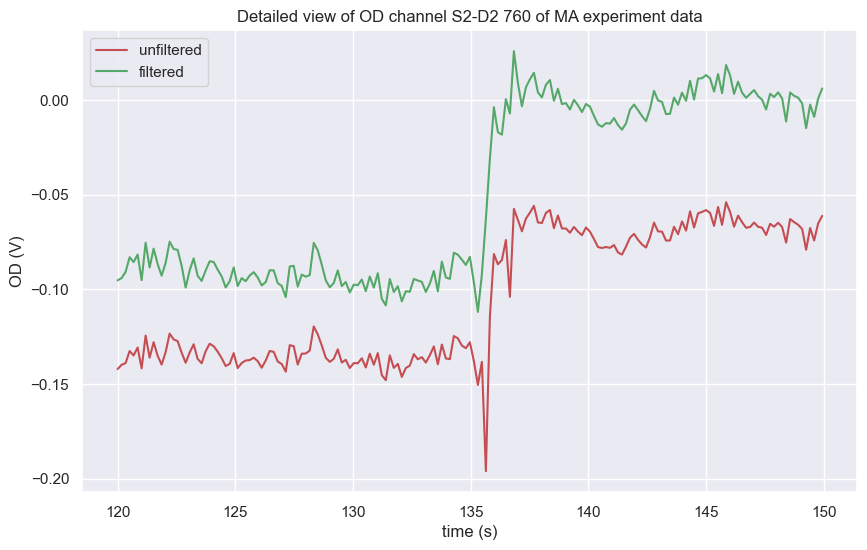

In [155]:
# CEI
%matplotlib inline
chan = 2
print(raw_od.ch_names[chan])
tmin, tmax = 120, 150
data_unfiltered = raw_od.copy().pick(chan).crop(tmin,tmax).get_data()[0]
data_filtered = raw_od_filtered_ICA_CEI.copy().pick(chan).crop(tmin,tmax).get_data()[0]
t = np.arange(len(data_unfiltered))/sfreq + tmin
plt.plot(t, data_unfiltered, label = 'unfiltered', color = 'r')
plt.plot(t, data_filtered, label = 'filtered', color = 'g')
plt.xlabel('time (s)')
plt.ylabel('OD (V)')
plt.title('Detailed view of OD channel S2-D2 760 of MA experiment data')
plt.legend()
if export:
    plt.savefig('ICA/ICA_CEI_MA_detail2.png')

###### Evaluate filter method

In [156]:
# MSD
# APA (OD data)
ids = [event_dict['test/Horizontal'], event_dict['test/Random'], event_dict['test/Vertical']]
start_ind = events[np.isin(events[:,2], ids)][:,0] - int(5*sfreq) # 5 seconds before artefact
start_ind = np.where(start_ind < 0, 0, start_ind)
stop_ind = start_ind + int(15*sfreq) # 10 seconds after artefact
Am = zip(start_ind, stop_ind)

APA_od_ICA_MSD = get_APA(raw_od_filtered_ICA_MSD, raw_od, Am, l_freq, l_trans_bandwidth = l_trans_bandwidth)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 1.35 Hz)
- Filter length: 65 samples (11.050 s)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 1.35 Hz)
- Filter length: 65 samples (11.050 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    0.0s finished


In [157]:
# CEI
# APA (OD data)
ids = [event_dict['test/Horizontal'], event_dict['test/Random'], event_dict['test/Vertical']]
start_ind = events[np.isin(events[:,2], ids)][:,0] - int(5*sfreq) # 5 seconds before artefact
start_ind = np.where(start_ind < 0, 0, start_ind)
stop_ind = start_ind + int(15*sfreq) # 10 seconds after artefact
Am = zip(start_ind, stop_ind)

APA_od_ICA_CEI = get_APA(raw_od_filtered_ICA_CEI, raw_od, Am, l_freq, l_trans_bandwidth = l_trans_bandwidth)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 1.35 Hz)
- Filter length: 65 samples (11.050 s)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 1.35 Hz)
- Filter length: 65 samples (11.050 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    0.0s finished


---
> *Remark:*
- For both methods and both dataset types, only a few spikes are removed effectively
- Additionally baseline shifts remain present
---

#### Temporal derivative distribution repair <a class="anchor" id="sub_section_1_6_6">

The TDDR method was introduced by Fishburn et al. in 2019. It offers both online and offline filtering approaches based on the temporal derivative of fNIRS signals, requiring no user-defined parameters. Moreover, it is applicable to concentration changes, optical intensities, and optical densities (Huang et al., 2022).

This method operates under specific assumptions: (1) non-motion-related fluctuations follow a normal distribution, (2) the majority of fluctuations are unrelated to motion artifacts, and (3) MA derivatives dominate in the derivatives of fNIRS signals during their presence.

The algorithm comprises five distinct steps. For an in-depth description of each step, please consult Fishburn et al. (2019).

##### Perform on synthetic data

In [158]:
# This approach corrects baseline shift and spike artifacts without the need for any user-supplied parameters (Fishburn Et Al., 2019)
# doi:10.1016/j.neuroimage.2018.09.025
raw_synth_od_filtered_tddrs = dict()
for i in range(n_set):
    raw_synth_od_filtered_tddrs[i] = temporal_derivative_distribution_repair(raw_synth_od_unfiltereds[i])

In [159]:
# Should have made a function for this instead of pasting it in each method
data_new = raw_synth_od_filtered_tddrs[0].get_data()
data = raw_synth_od_unfiltereds[0].get_data()
picks = np.sort(_validate_nirs_info(raw_synth_od_filtered_tddrs[0].info))
filename = 'synth'
for pick in picks:
    if plot:
        type = ' wavelength 760' if pick%2 == 0 else ' wavelength 850'
        ylabel = 'OD (V)'
        %matplotlib inline
        time = np.arange(data.shape[1])/sfreq
        plt.plot(time, data[pick], label = 'original')
        plt.plot(time, data_new[pick], label = 'filtered')
        plt.xlabel('time (s)')
        plt.ylabel(ylabel)
        plt.title('Channel: ' + str(pick//2+1) + type)
        plt.legend()
        if export:
            if filename == None:
                raise ValueError('Filename must be given to export figures')
            plt.savefig('tddr/tddr_' + filename + '_channel_' + str(pick//2+1) + type + '.png')
        plt.show()

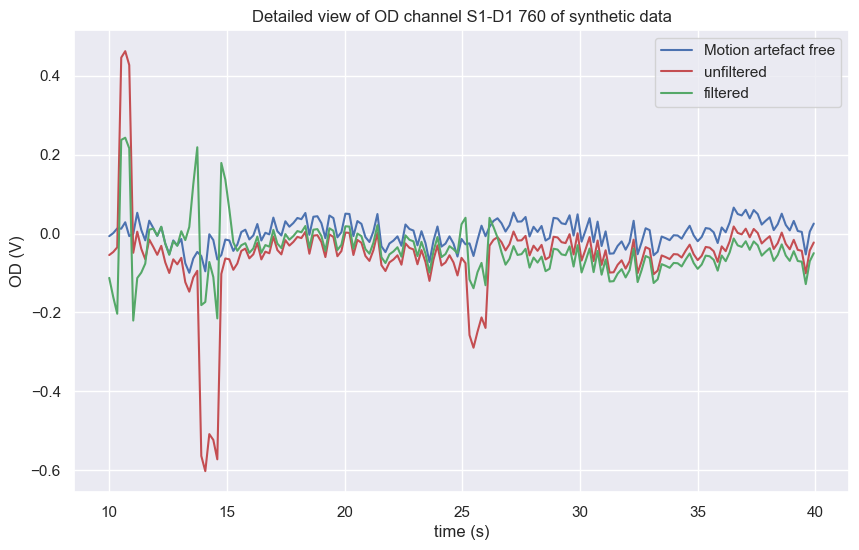

In [160]:
# Zoom in on spike of first dataset (Look for good segment in full recording first)
%matplotlib inline
tmin, tmax = 10, 40
data_clean = raw_synth_od_cleans[0].copy().pick(0).crop(tmin,tmax).get_data()[0]
data_unfiltered = raw_synth_od_unfiltereds[0].copy().pick(0).crop(tmin,tmax).get_data()[0]
data_filtered = raw_synth_od_filtered_tddrs[0].copy().pick(0).crop(tmin,tmax).get_data()[0]
t = np.arange(len(data_clean))/sfreq + tmin
plt.plot(t, data_clean, label = 'Motion artefact free', color = 'b')
plt.plot(t, data_unfiltered, label = 'unfiltered', color = 'r')
plt.plot(t, data_filtered, label = 'filtered', color = 'g')
plt.xlabel('time (s)')
plt.ylabel('OD (V)')
plt.title('Detailed view of OD channel S1-D1 760 of synthetic data')
plt.legend()
if export:
    plt.savefig('tddr/tddr_synth_detail.png')

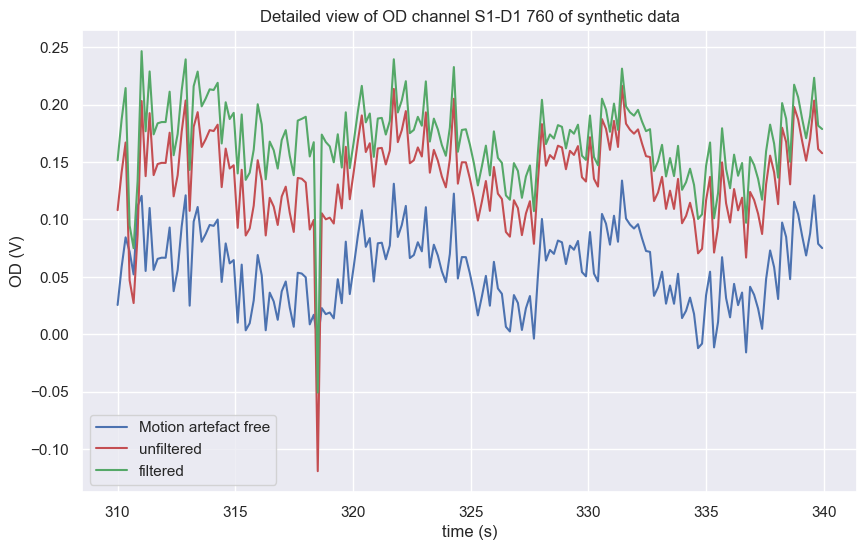

In [161]:
# Zoom in on baseline shift of first data
%matplotlib inline
tmin, tmax = 310, 340
data_clean = raw_synth_od_cleans[0].copy().pick(0).crop(tmin,tmax).get_data()[0]
data_unfiltered = raw_synth_od_unfiltereds[0].copy().pick(0).crop(tmin,tmax).get_data()[0]
data_filtered = raw_synth_od_filtered_tddrs[0].copy().pick(0).crop(tmin,tmax).get_data()[0]
t = np.arange(len(data_clean))/sfreq +tmin
plt.plot(t, data_clean, label = 'Motion artefact free', color = 'b')
plt.plot(t, data_unfiltered, label = 'unfiltered', color = 'r')
plt.plot(t, data_filtered, label = 'filtered', color = 'g')
plt.xlabel('time (s)')
plt.ylabel('OD (V)')
plt.title('Detailed view of OD channel S1-D1 760 of synthetic data')
plt.legend()
if export:
    plt.savefig('tddr/tddr_synth_detail2.png')

###### Evaluate filter method

In [162]:
# SNR (OD data)
DeltaSNR_synth_od_tddrs = dict()
for i in range(n_set):
    DeltaSNR_synth_od_tddrs[i] = get_DeltaSNR(raw_synth_od_cleans[i], raw_synth_od_filtered_tddrs[i], raw_synth_od_unfiltereds[i])

In [163]:
# PRD (OD data)
PRD_synth_od_tddrs = dict()
for i in range(n_set):
    PRD_synth_od_tddrs[i] = get_PRD(raw_synth_od_cleans[i], raw_synth_od_filtered_tddrs[i], raw_synth_od_unfiltereds[i])

In [164]:
# CC (OD data)
DeltaCC_synth_od_tddrs = dict()
for i in range(n_set):
    DeltaCC_synth_od_tddrs[i] = get_DeltaCC(raw_synth_od_cleans[i], raw_synth_od_filtered_tddrs[i], raw_synth_od_unfiltereds[i])

In [165]:
# CNR Cooper (haemo data)
raw_synth_haemo_filtered_tddrs = dict()
CNR_cooper_synth_haemo_tddrs = dict()
for i in range(n_set):
    raw_synth_haemo_filtered_tddrs[i] = beer_lambert_law(raw_synth_od_filtered_tddrs[i], ppf=ppf)
    CNR_cooper_synth_haemo_tddrs[i] = get_CNR_Cooper(raw_synth_haemo_filtered_tddrs[i], raw_synth_haemo_unfiltereds[i], reject_criteria = reject_criteria, tmin = tmin_CNR, tmax = tmax_CNR, t_peak = t_peak, real_HRF = real_HRF)

Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Not setting metadata
53 matching events found
Setting baseline interval to [-5.9523809523809526, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 53 events and 212 original time points ...
5 bad epochs dropped
Not setting metadata
53 matching events found
Setting baseline interval to [-5.9523809523809526, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 53 events and 212 original time points ...
5 bad epochs dropped
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Not setting metadata
53 matching events found
Setting baseline interval to [-5.9523809523809526, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 53 events and 212 original time points ...
5 bad epochs dropped
Not setting metadata
53 matching events f

In [166]:
# CNR Zhang (OD data)
CNR_zhang_synth_haemo_tddrs = dict()
for i in range(n_set):
    CNR_zhang_synth_haemo_tddrs[i] = get_CNR_Zhang(raw_synth_haemo_filtered_tddrs[i], raw_synth_haemo_unfiltereds[i], reject_criteria = reject_criteria)

Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Not setting metadata
53 matching events found
Setting baseline interval to [-14.965986394557824, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 53 events and 207 original time points ...
7 bad epochs dropped
Not setting metadata
53 matching events found
Setting baseline interval to [-14.965986394557824, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 53 events and 207 original time points ...
7 bad epochs dropped
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Not setting metadata
53 matching events found
Setting baseline interval to [-14.965986394557824, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 53 events and 207 original time points ...
4 bad epochs dropped
Not setting metadata
53 matching events f

In [167]:
#APA (OD data)
APA_synth_od_tddrs = dict()
for i in range(n_set):
    ids = [event_dict_synths[i]['Spike'], event_dict_synths[i]['Shift']]
    
    start_ind = events_synths[i][np.isin(events_synths[i][:,2], ids)][:,0] - int(5*sfreq) # 5 seconds before artefact
    start_ind = np.where(start_ind < 0, 0, start_ind)
    stop_ind = start_ind + int(10*sfreq) # 5 seconds after artefact
    Am_synth = zip(start_ind, stop_ind)
    
    APA_synth_od_tddrs[i] = get_APA(raw_synth_od_filtered_tddrs[i], raw_synth_od_unfiltereds[i], Am_synth, l_freq, l_trans_bandwidth = l_trans_bandwidth)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 1.35 Hz)
- Filter length: 65 samples (11.054 s)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 1.35 Hz)
- Filter length: 65 samples (11.054 s)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter paramet

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 1.35 Hz)
- Filter length: 65 samples (11.054 s)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 1.35 Hz)
- Filter length: 65 samples (11.054 s)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass f

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

##### Perform on motion artefact experiment data

In [168]:
raw_od_filtered_tddr =  temporal_derivative_distribution_repair(raw_od)

In [169]:
data_new = raw_od_filtered_tddr.get_data()
data = raw_od.get_data()
picks = np.sort(_validate_nirs_info(raw_od.info))
filename = 'MA'
for pick in picks:
    if plot:
        type = ' wavelength 760' if pick%2 == 0 else ' wavelength 850'
        ylabel = 'OD (V)'
        %matplotlib inline
        time = np.arange(data.shape[1])/sfreq
        plt.plot(time, data[pick], label = 'original')
        plt.plot(time, data_new[pick], label = 'filtered')
        plt.xlabel('time (s)')
        plt.ylabel(ylabel)
        plt.title('Channel: ' + str(pick//2+1) + type)
        plt.legend()
        if export:
            if filename == None:
                raise ValueError('Filename must be given to export figures')
            plt.savefig('tddr/tddr_' + filename + '_channel_' + str(pick//2+1) + type + '.png')
        plt.show()

S2_D2 760


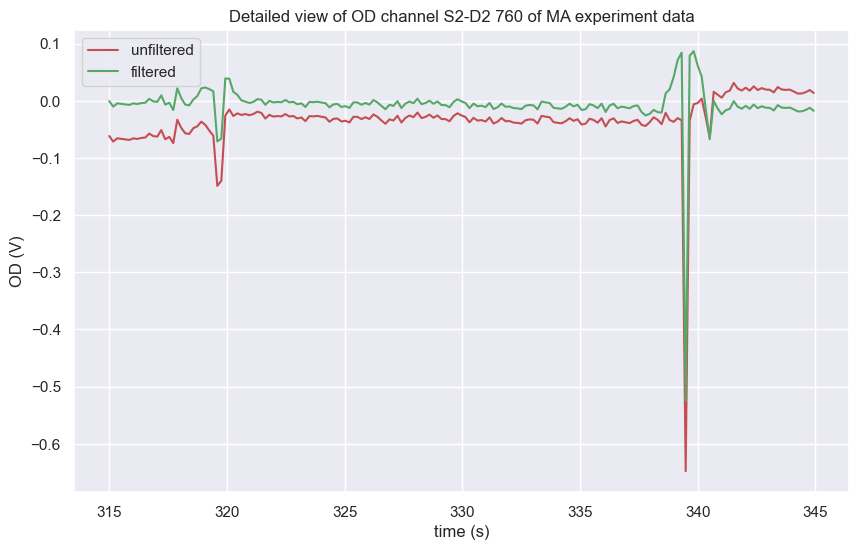

In [227]:
%matplotlib inline
chan = 2
print(raw_od.ch_names[chan])
tmin, tmax = 315, 345
data_unfiltered = raw_od.copy().pick(chan).crop(tmin,tmax).get_data()[0]
data_filtered = raw_od_filtered_tddr.copy().pick(chan).crop(tmin,tmax).get_data()[0]
t = np.arange(len(data_unfiltered))/sfreq + tmin
plt.plot(t, data_unfiltered, label = 'unfiltered', color = 'r')
plt.plot(t, data_filtered, label = 'filtered', color = 'g')
plt.xlabel('time (s)')
plt.ylabel('OD (V)')
plt.title('Detailed view of OD channel S2-D2 760 of MA experiment data')
plt.legend()
if export:
    plt.savefig('tddr/tddr_MA_detail.png')

S2_D2 760


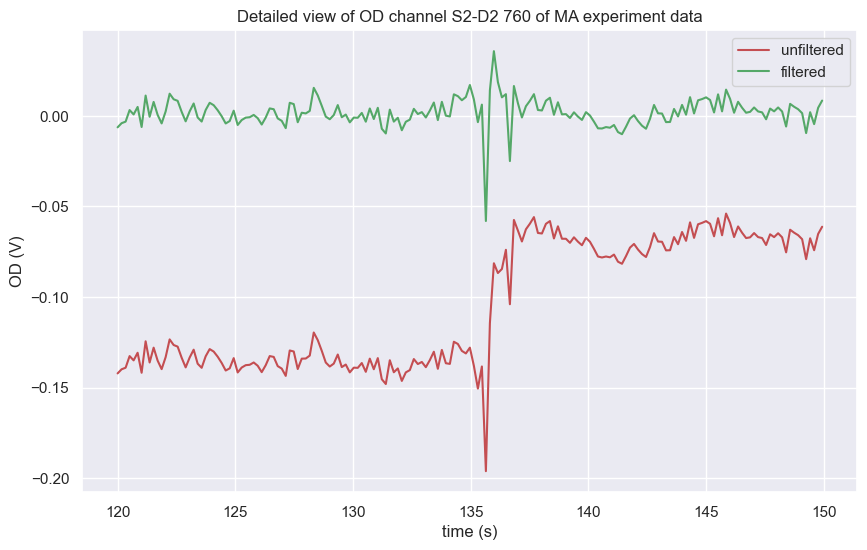

In [228]:
%matplotlib inline
chan = 2
print(raw_od.ch_names[chan])
tmin, tmax = 120, 150
data_unfiltered = raw_od.copy().pick(chan).crop(tmin,tmax).get_data()[0]
data_filtered = raw_od_filtered_tddr.copy().pick(chan).crop(tmin,tmax).get_data()[0]
t = np.arange(len(data_unfiltered))/sfreq + tmin
plt.plot(t, data_unfiltered, label = 'unfiltered', color = 'r')
plt.plot(t, data_filtered, label = 'filtered', color = 'g')
plt.xlabel('time (s)')
plt.ylabel('OD (V)')
plt.title('Detailed view of OD channel S2-D2 760 of MA experiment data')
plt.legend()
if export:
    plt.savefig('tddr/tddr_MA_detail2.png')

###### Evaluate filter method

In [170]:
# APA (OD data)
ids = [event_dict['test/Horizontal'], event_dict['test/Random'], event_dict['test/Vertical']]
start_ind = events[np.isin(events[:,2], ids)][:,0] - int(5*sfreq) # 5 seconds before artefact
start_ind = np.where(start_ind < 0, 0, start_ind)
stop_ind = start_ind + int(15*sfreq) # 10 seconds after artefact
Am = zip(start_ind, stop_ind)

APA_od_tddr = get_APA(raw_od_filtered_tddr, raw_od, Am, l_freq, l_trans_bandwidth = l_trans_bandwidth)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 1.35 Hz)
- Filter length: 65 samples (11.050 s)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 1.35 Hz)
- Filter length: 65 samples (11.050 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    0.0s finished


---
> *Remark:*
- Effective removal of baseline shifts without causing baseline drifts
- Spikes are still present but with often lower amplitudes
---

#### Correlation-based signal improvement <a class="anchor" id="sub_section_1_6_7"></a>

The CBSI method, introduced by Cui et al. (2010), operates on a channel-by-channel basis. It operates under the assumption that under normal conditions, changes in HbO and HbR levels exhibit a negative correlation during functional activation. However, in the presence of motion artifacts, this correlation tends to become more positive. The measured signals for HbO and HbR, denoted as $\mathbf{x}$ and $\mathbf{y}$ respectively, consist of the true HbO and HbR signals to be estimated ($\mathbf{x_0}$ and $\mathbf{y_0}$), along with the motion artifact $\mathbf{F}$, which affects both chromophores equally (with a constant weighting $\alpha$), and high-frequency white noise. 
$$
    \begin{cases}
      \mathbf{x} = \mathbf{x_0} + \alpha \mathbf{F} + \mathbf{Noise} \\
      \mathbf{y} = \mathbf{y_0} + \mathbf{F} + \mathbf{Noise}
    \end{cases}       
$$
Assuming that (1) the correlation between $\mathbf{x_0}$ and $\mathbf{y_0}$ is approximately -1, (2) the correlation between the artifact $\mathbf{F}$ and the true signal $\mathbf{x_0}$ is close to 0, (3) the ratio between HbO and HbR remains consistent regardless of artifact presence and (4) the high-frequency noise can be removed with a low-pass filter, the true HbO and HbR signals can be derived using the following equation:
$$
    \begin{cases}
      \mathbf{x_0} = \frac{\mathbf{x} - \alpha \mathbf{y}}{2} \\
      \mathbf{y_0} = \frac{-\mathbf{x}}{\alpha}
    \end{cases}  
$$
with $\alpha = \frac{std(\mathbf{x})}{std(\mathbf{y})} $ and $std(\cdot)$ the standard deviation operator. \par
As this method is based on the relation between HbO and HbR, the MA correction needs to be employed after the optical densities are converted to haemoglobin concentrations with the MBLL. 

##### Perform on synthetic data

In [171]:
raw_synth_haemo_filtered_cbsis = dict()
for i in range(n_set):
    raw_synth_haemo_filtered_cbsis[i] = enhance_negative_correlation(raw_synth_haemo_unfiltereds[i])

In [172]:
raw_synth_od_filtered_cbsis = dict()
for i in range(n_set):
    raw_synth_od_filtered_cbsis[i] = inverse_beer_lambert(raw_synth_haemo_filtered_cbsis[i], ppf = ppf)

In [173]:
# Should have made a function for this instead of pasting it in each method
data_new = raw_synth_od_filtered_cbsis[0].get_data()
data = raw_synth_od_unfiltereds[0].get_data()
picks = np.sort(_validate_nirs_info(raw_synth_od_filtered_cbsis[0].info))
filename = 'synth'
for pick in picks:
    if plot:
        type = ' wavelength 760' if pick%2 == 0 else ' wavelength 850'
        ylabel = 'OD (V)'
        %matplotlib inline
        time = np.arange(data.shape[1])/sfreq
        plt.plot(time, data[pick], label = 'original')
        plt.plot(time, data_new[pick], label = 'filtered')
        plt.xlabel('time (s)')
        plt.ylabel(ylabel)
        plt.title('Channel: ' + str(pick//2+1) + type)
        plt.legend()
        if export:
            if filename == None:
                raise ValueError('Filename must be given to export figures')
            plt.savefig('cbsi/cbsi_' + filename + '_channel_' + str(pick//2+1) + type + '.png')
        plt.show()

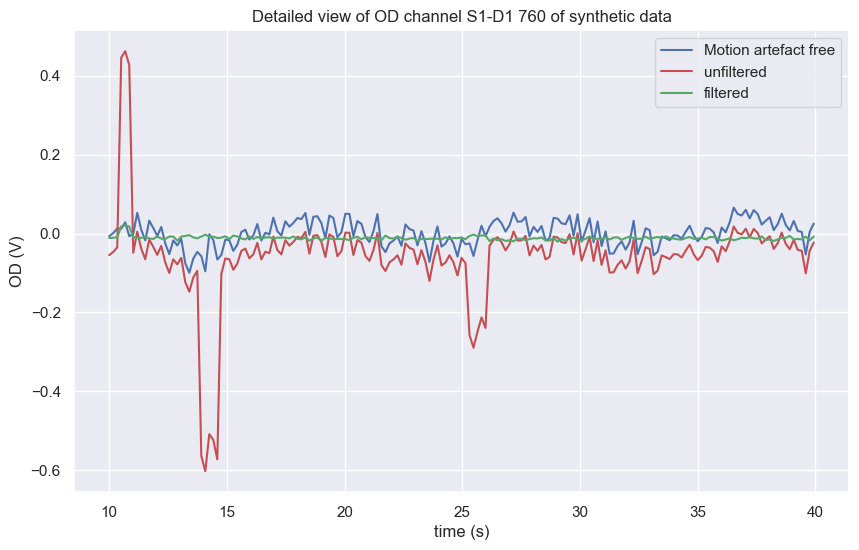

In [174]:
# Zoom in on spike of first dataset (Look for good segment in full recording first)
%matplotlib inline
tmin, tmax = 10, 40
data_clean = raw_synth_od_cleans[0].copy().pick(0).crop(tmin,tmax).get_data()[0]
data_unfiltered = raw_synth_od_unfiltereds[0].copy().pick(0).crop(tmin,tmax).get_data()[0]
data_filtered = raw_synth_od_filtered_cbsis[0].copy().pick(0).crop(tmin,tmax).get_data()[0]
t = np.arange(len(data_clean))/sfreq + tmin
plt.plot(t, data_clean, label = 'Motion artefact free', color = 'b')
plt.plot(t, data_unfiltered, label = 'unfiltered', color = 'r')
plt.plot(t, data_filtered, label = 'filtered', color = 'g')
plt.xlabel('time (s)')
plt.ylabel('OD (V)')
plt.title('Detailed view of OD channel S1-D1 760 of synthetic data')
plt.legend()
if export:
    plt.savefig('cbsi/cbsi_synth_detail.png')

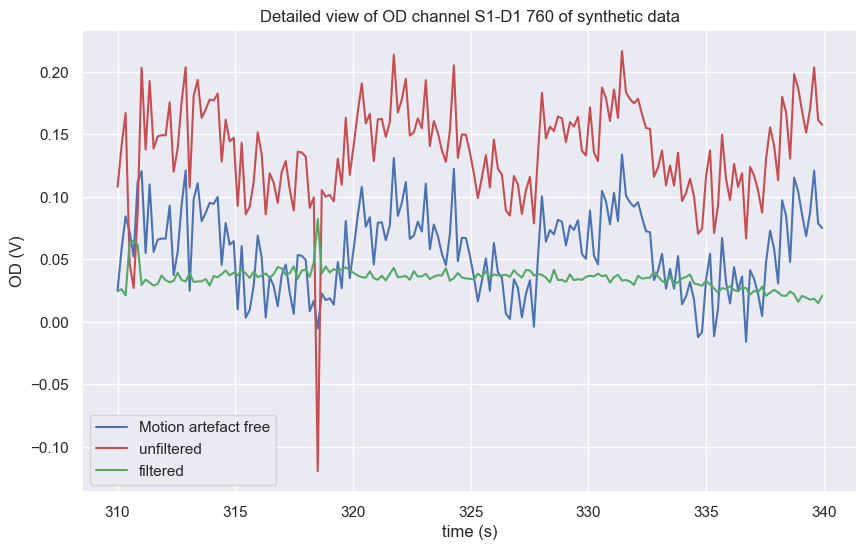

In [175]:
# Zoom in on baseline shift of first data
%matplotlib inline
tmin, tmax = 310, 340
data_clean = raw_synth_od_cleans[0].copy().pick(0).crop(tmin,tmax).get_data()[0]
data_unfiltered = raw_synth_od_unfiltereds[0].copy().pick(0).crop(tmin,tmax).get_data()[0]
data_filtered = raw_synth_od_filtered_cbsis[0].copy().pick(0).crop(tmin,tmax).get_data()[0]
t = np.arange(len(data_clean))/sfreq +tmin
plt.plot(t, data_clean, label = 'Motion artefact free', color = 'b')
plt.plot(t, data_unfiltered, label = 'unfiltered', color = 'r')
plt.plot(t, data_filtered, label = 'filtered', color = 'g')
plt.xlabel('time (s)')
plt.ylabel('OD (V)')
plt.title('Detailed view of OD channel S1-D1 760 of synthetic data')
plt.legend()
if export:
    plt.savefig('cbsi/cbsi_synth_detail2.png')

###### Evaluate filter method

In [176]:
# SNR (OD data)
DeltaSNR_synth_od_cbsis = dict()
for i in range(n_set):
    DeltaSNR_synth_od_cbsis[i] = get_DeltaSNR(raw_synth_od_cleans[i], raw_synth_od_filtered_cbsis[i], raw_synth_od_unfiltereds[i])

In [177]:
# PRD (OD data)
PRD_synth_od_cbsis = dict()
for i in range(n_set):
    PRD_synth_od_cbsis[i] = get_PRD(raw_synth_od_cleans[i], raw_synth_od_filtered_cbsis[i], raw_synth_od_unfiltereds[i])

In [178]:
# CC (OD data)
DeltaCC_synth_od_cbsis = dict()
for i in range(n_set):
    DeltaCC_synth_od_cbsis[i] = get_DeltaCC(raw_synth_od_cleans[i], raw_synth_od_filtered_cbsis[i], raw_synth_od_unfiltereds[i])

In [179]:
# CNR Cooper(haemo data)
CNR_cooper_synth_haemo_cbsis = dict()
for i in range(n_set):
    CNR_cooper_synth_haemo_cbsis[i] = get_CNR_Cooper(raw_synth_haemo_filtered_cbsis[i], raw_synth_haemo_unfiltereds[i], reject_criteria = reject_criteria, tmin = tmin_CNR, tmax = tmax_CNR, t_peak = t_peak, real_HRF = real_HRF)

Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Not setting metadata
53 matching events found
Setting baseline interval to [-5.9523809523809526, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 53 events and 212 original time points ...
5 bad epochs dropped
Not setting metadata
53 matching events found
Setting baseline interval to [-5.9523809523809526, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 53 events and 212 original time points ...
5 bad epochs dropped
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Not setting metadata
53 matching events found
Setting baseline interval to [-5.9523809523809526, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 53 events and 212 original time points ...
5 bad epochs dropped
Not setting metadata
53 matching events f

In [180]:
# CNR Zhang (haemo data)
CNR_zhang_synth_haemo_cbsis = dict()
for i in range(n_set):
    CNR_zhang_synth_haemo_cbsis[i] = get_CNR_Zhang(raw_synth_haemo_filtered_cbsis[i], raw_synth_haemo_unfiltereds[i], reject_criteria = reject_criteria)

Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Not setting metadata
53 matching events found
Setting baseline interval to [-14.965986394557824, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 53 events and 207 original time points ...
7 bad epochs dropped
Not setting metadata
53 matching events found
Setting baseline interval to [-14.965986394557824, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 53 events and 207 original time points ...
7 bad epochs dropped
Used Annotations descriptions: ['Baseline', 'Shift', 'Spike', 'Task']
Not setting metadata
53 matching events found
Setting baseline interval to [-14.965986394557824, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 53 events and 207 original time points ...
4 bad epochs dropped
Not setting metadata
53 matching events f

In [181]:
# APA (OD data)
APA_synth_od_cbsis = dict()
for i in range(n_set):
    ids = [event_dict_synths[i]['Spike'], event_dict_synths[i]['Shift']]
    start_ind = events_synths[i][np.isin(events_synths[i][:,2], ids)][:,0] - int(5*sfreq) # 5 seconds before artefact
    start_ind = np.where(start_ind < 0, 0, start_ind)
    stop_ind = start_ind + int(10*sfreq) # 5 seconds after artefact
    Am_synth = zip(start_ind, stop_ind)
    
    APA_synth_od_cbsis[i] = get_APA(raw_synth_od_filtered_cbsis[i], raw_synth_od_unfiltereds[i], Am_synth, l_freq, l_trans_bandwidth = l_trans_bandwidth)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 1.35 Hz)
- Filter length: 65 samples (11.054 s)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 1.35 Hz)
- Filter length: 65 samples (11.054 s)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter paramet

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 1.35 Hz)
- Filter length: 65 samples (11.054 s)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 1.35 Hz)
- Filter length: 65 samples (11.054 s)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass f

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with

##### Perform on motion artefact experiment data

In [182]:
raw_haemo_filtered_cbsi =  enhance_negative_correlation(raw_haemo)

In [183]:
raw_od_filtered_cbsi = inverse_beer_lambert(raw_haemo_filtered_cbsi, ppf = ppf)

In [184]:
# Should have made a function for this instead of pasting it in each method
data_new = raw_od_filtered_cbsi.get_data()
data = raw_od.get_data()
picks = np.sort(_validate_nirs_info(raw_od.info))
filename = 'MA'
for pick in picks:
    if plot:
        type = ' wavelength 760' if pick%2 == 0 else ' wavelength 850'
        ylabel = 'OD (V)'
        %matplotlib inline
        time = np.arange(data.shape[1])/sfreq
        plt.plot(time, data[pick], label = 'original')
        plt.plot(time, data_new[pick], label = 'filtered')
        plt.xlabel('time (s)')
        plt.ylabel(ylabel)
        plt.title('Channel: ' + str(pick//2+1) + type)
        plt.legend()
        if export:
            if filename == None:
                raise ValueError('Filename must be given to export figures')
            plt.savefig('cbsi/cbsi_' + filename + '_channel_' + str(pick//2+1) + type + '.png')
        plt.show()

S2_D2 760


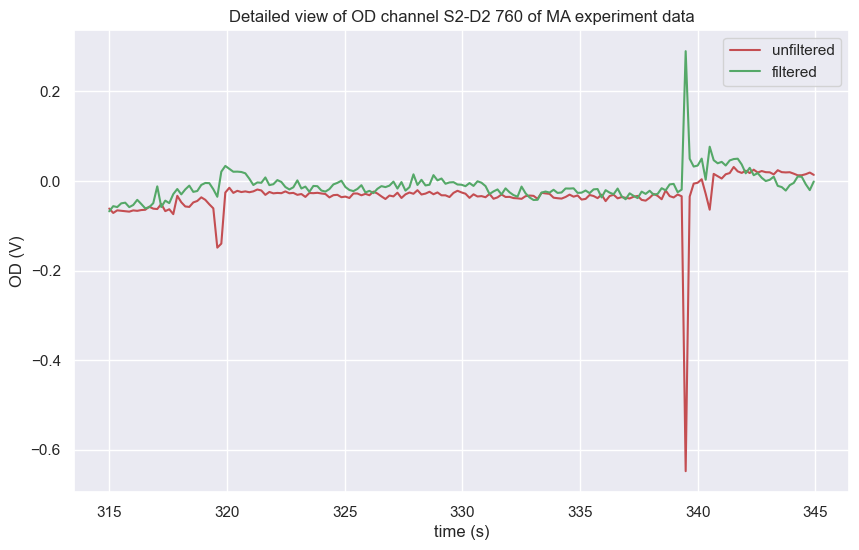

In [229]:
%matplotlib inline
chan = 2
print(raw_od.ch_names[chan])
tmin, tmax = 315, 345
data_unfiltered = raw_od.copy().pick(chan).crop(tmin,tmax).get_data()[0]
data_filtered = raw_od_filtered_cbsi.copy().pick(chan).crop(tmin,tmax).get_data()[0]
t = np.arange(len(data_unfiltered))/sfreq + tmin
plt.plot(t, data_unfiltered, label = 'unfiltered', color = 'r')
plt.plot(t, data_filtered, label = 'filtered', color = 'g')
plt.xlabel('time (s)')
plt.ylabel('OD (V)')
plt.title('Detailed view of OD channel S2-D2 760 of MA experiment data')
plt.legend()
if export:
    plt.savefig('cbsi/cbsi_MA_detail.png')

S2_D2 760


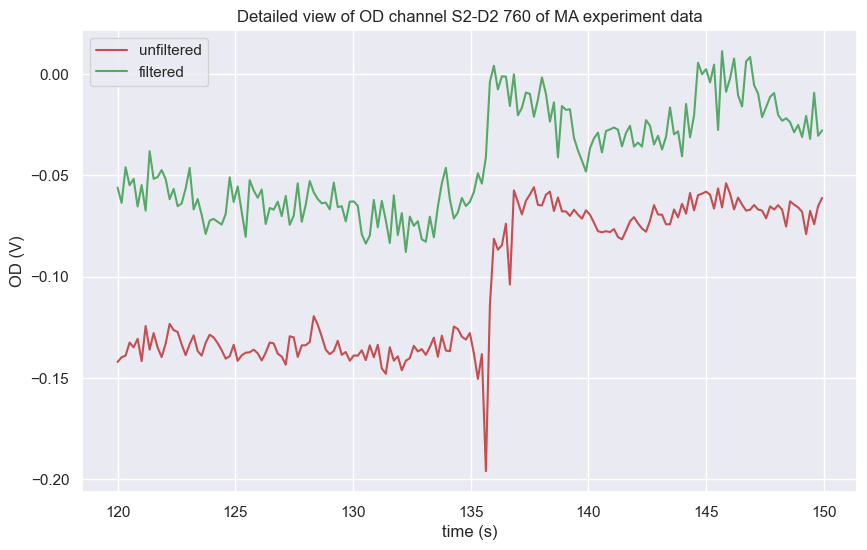

In [230]:
%matplotlib inline
chan = 2
print(raw_od.ch_names[chan])
tmin, tmax = 120, 150
data_unfiltered = raw_od.copy().pick(chan).crop(tmin,tmax).get_data()[0]
data_filtered = raw_od_filtered_cbsi.copy().pick(chan).crop(tmin,tmax).get_data()[0]
t = np.arange(len(data_unfiltered))/sfreq + tmin
plt.plot(t, data_unfiltered, label = 'unfiltered', color = 'r')
plt.plot(t, data_filtered, label = 'filtered', color = 'g')
plt.xlabel('time (s)')
plt.ylabel('OD (V)')
plt.title('Detailed view of OD channel S2-D2 760 of MA experiment data')
plt.legend()
if export:
    plt.savefig('cbsi/cbsi_MA_detail2.png')

###### Evaluate filter method

In [185]:
# APA (OD data)
ids = [event_dict['test/Horizontal'], event_dict['test/Random'], event_dict['test/Vertical']]
start_ind = events[np.isin(events[:,2], ids)][:,0] - int(5*sfreq) # 5 seconds before artefact
start_ind = np.where(start_ind < 0, 0, start_ind)
stop_ind = start_ind + int(15*sfreq) # 10 seconds after artefact
Am = zip(start_ind, stop_ind)

APA_od_cbsi = get_APA(raw_od_filtered_cbsi, raw_od, Am, l_freq, l_trans_bandwidth = l_trans_bandwidth)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 1.35 Hz)
- Filter length: 65 samples (11.050 s)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.50
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 1.35 Hz)
- Filter length: 65 samples (11.050 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    0.0s finished


---
> *Remark:*
- Changes in amplitude of signals
- Inversion of spikes
- Moderate removal of spikes and baseline shifts
---

### Compare motion artefact techniques <a class="anchor" id="section_1_7"></a>

#### Synthetic datasets <a class="anchor" id="sub_section_1_7_1"></a>

In [232]:
metrics = ['DeltaSNR', 'PRD', 'DeltaCC', 'CNR_C', 'CNR_Z', 'APA']
methods = ['WF', 'kbWF', 'PCA_2', 'PCA_3', 'ICA', 'tddr', 'cbsi']
channels = raw_synth_od_cleans[0].ch_names

##### SNR

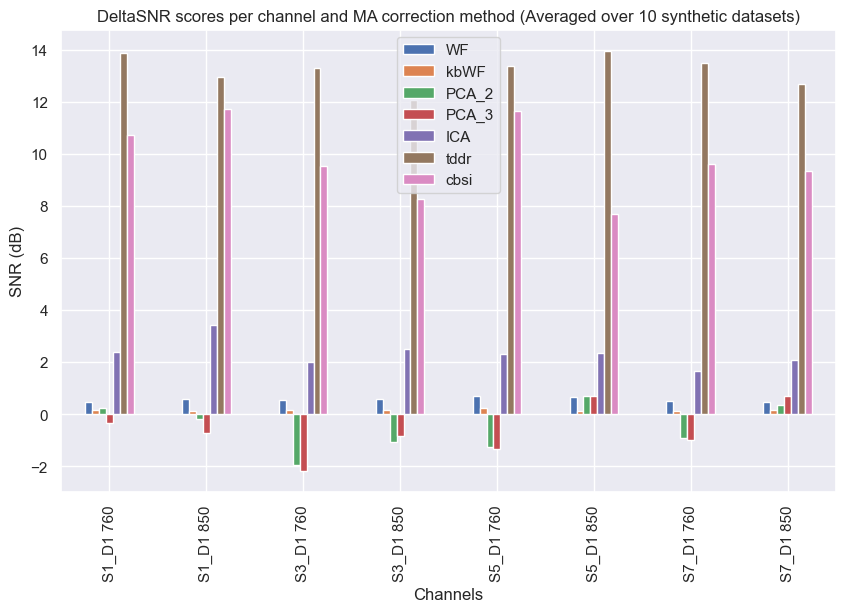

In [233]:
DeltaSNR_synth_od_WF = pd.DataFrame(DeltaSNR_synth_od_WFs.values(), columns = channels).mean(axis = 0)
DeltaSNR_synth_od_kWF = pd.DataFrame(DeltaSNR_synth_od_kWFs.values(), columns = channels).mean(axis = 0)
DeltaSNR_synth_od_PCA_2 = pd.DataFrame(DeltaSNR_synth_od_PCAs_2.values(), columns = channels).mean(axis = 0)
DeltaSNR_synth_od_PCA_3 = pd.DataFrame(DeltaSNR_synth_od_PCAs_3.values(), columns = channels).mean(axis = 0)
DeltaSNR_synth_od_ICA = pd.DataFrame(DeltaSNR_synth_od_ICAs.values(), columns = channels).mean(axis = 0)
DeltaSNR_synth_od_tddr = pd.DataFrame(DeltaSNR_synth_od_tddrs.values(), columns = channels).mean(axis = 0)
DeltaSNR_synth_od_cbsi = pd.DataFrame(DeltaSNR_synth_od_cbsis.values(), columns = channels).mean(axis = 0)
DeltaSNR = pd.concat([DeltaSNR_synth_od_WF, DeltaSNR_synth_od_kWF, DeltaSNR_synth_od_PCA_2, DeltaSNR_synth_od_PCA_3, DeltaSNR_synth_od_ICA, DeltaSNR_synth_od_tddr, DeltaSNR_synth_od_cbsi], axis = 1)
DeltaSNR.columns = methods
DeltaSNR.plot.bar(title = 'DeltaSNR scores per channel and MA correction method (Averaged over 10 synthetic datasets)', ylabel = 'SNR (dB)', xlabel = 'Channels').get_figure().savefig('DeltaSNR.png', bbox_inches = 'tight')

In [234]:
# Mean score over all channels
scores_SNR = DeltaSNR.mean(axis = 0).sort_values(ascending = False)
scores_SNR

tddr     13.221125
cbsi      9.825616
ICA       2.338464
WF        0.563602
kbWF      0.150940
PCA_2    -0.518436
PCA_3    -0.628567
dtype: float64

In [235]:
print('The best MA correction technique based on SNR value is: ' + DeltaSNR.mean(axis = 0).idxmax() + ' (value = ' + str(DeltaSNR.mean(axis = 0).max()) + ')')

The best MA correction technique based on SNR value is: tddr (value = 13.221124711155124)


---
> *Remark:*
- Best method according to SNR is TDDR
---

##### PRD

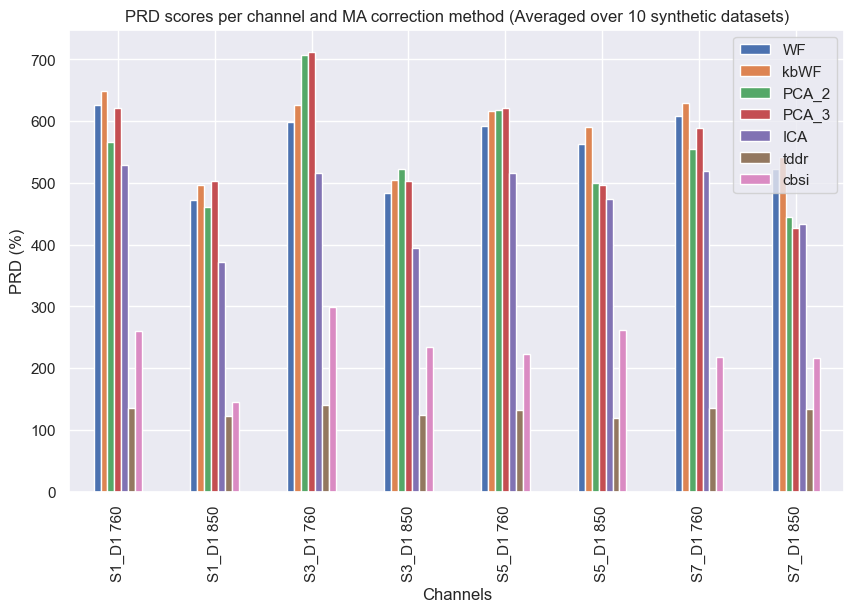

In [236]:
PRD_synth_od_WF = pd.DataFrame(PRD_synth_od_WFs.values(), columns = channels).mean(axis = 0)
PRD_synth_od_kWF = pd.DataFrame(PRD_synth_od_kWFs.values(), columns = channels).mean(axis = 0)
PRD_synth_od_PCA_2 = pd.DataFrame(PRD_synth_od_PCAs_2.values(), columns = channels).mean(axis = 0)
PRD_synth_od_PCA_3 = pd.DataFrame(PRD_synth_od_PCAs_3.values(), columns = channels).mean(axis = 0)
PRD_synth_od_ICA = pd.DataFrame(PRD_synth_od_ICAs.values(), columns = channels).mean(axis = 0)
PRD_synth_od_tddr = pd.DataFrame(PRD_synth_od_tddrs.values(), columns = channels).mean(axis = 0)
PRD_synth_od_cbsi = pd.DataFrame(PRD_synth_od_cbsis.values(), columns = channels).mean(axis = 0)
PRD = pd.concat([PRD_synth_od_WF, PRD_synth_od_kWF, PRD_synth_od_PCA_2, PRD_synth_od_PCA_3, PRD_synth_od_ICA, PRD_synth_od_tddr, PRD_synth_od_cbsi], axis = 1)
PRD.columns = methods
PRD.plot.bar(title = 'PRD scores per channel and MA correction method (Averaged over 10 synthetic datasets)', ylabel = 'PRD (%)', xlabel = 'Channels').get_figure().savefig('PRD.png', bbox_inches = 'tight')

In [237]:
# Mean score over all channels
scores_PRD = PRD.mean(axis = 0).sort_values(ascending = True)
scores_PRD

tddr     130.299395
cbsi     232.016332
ICA      469.287641
PCA_2    546.488128
WF       558.269498
PCA_3    559.125089
kbWF     581.318637
dtype: float64

In [238]:
print('The best MA correction technique based on PRD value is: ' + PRD.mean(axis = 0).idxmin() + ' (value = ' + str(PRD.mean(axis = 0).min()) + ')')

The best MA correction technique based on PRD value is: tddr (value = 130.29939450409103)


---
> *Remark:*
- Best method according to PRD is TDDR
---

##### DeltaCC

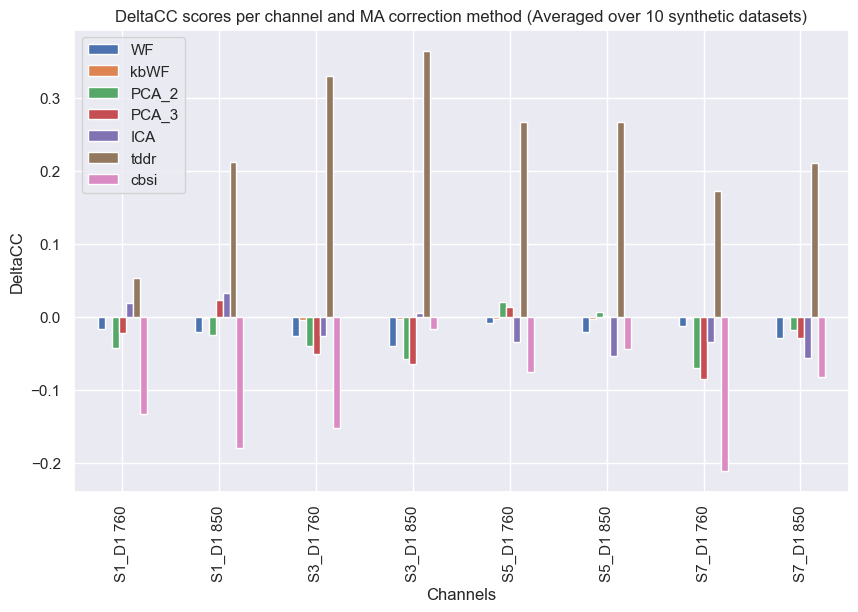

In [239]:
DeltaCC_synth_od_WF = pd.DataFrame(DeltaCC_synth_od_WFs.values(), columns = channels).mean(axis = 0)
DeltaCC_synth_od_kWF = pd.DataFrame(DeltaCC_synth_od_kWFs.values(), columns = channels).mean(axis = 0)
DeltaCC_synth_od_PCA_2 = pd.DataFrame(DeltaCC_synth_od_PCAs_2.values(), columns = channels).mean(axis = 0)
DeltaCC_synth_od_PCA_3 = pd.DataFrame(DeltaCC_synth_od_PCAs_3.values(), columns = channels).mean(axis = 0)
DeltaCC_synth_od_ICA = pd.DataFrame(DeltaCC_synth_od_ICAs.values(), columns = channels).mean(axis = 0)
DeltaCC_synth_od_tddr = pd.DataFrame(DeltaCC_synth_od_tddrs.values(), columns = channels).mean(axis = 0)
DeltaCC_synth_od_cbsi = pd.DataFrame(DeltaCC_synth_od_cbsis.values(), columns = channels).mean(axis = 0)
DeltaCC = pd.concat([DeltaCC_synth_od_WF, DeltaCC_synth_od_kWF, DeltaCC_synth_od_PCA_2, DeltaCC_synth_od_PCA_3, DeltaCC_synth_od_ICA, DeltaCC_synth_od_tddr, DeltaCC_synth_od_cbsi], axis = 1)
DeltaCC.columns = methods

DeltaCC.plot.bar(title = 'DeltaCC scores per channel and MA correction method (Averaged over 10 synthetic datasets)', ylabel = 'DeltaCC', xlabel = 'Channels').get_figure().savefig('DeltaCC.png', bbox_inches = 'tight')

In [240]:
# Mean score over all channels
scores_CC = DeltaCC.mean(axis = 0).sort_values(ascending = False)
scores_CC

tddr     0.234819
kbWF    -0.002694
ICA     -0.018741
WF      -0.022181
PCA_3   -0.026964
PCA_2   -0.028572
cbsi    -0.112033
dtype: float64

In [241]:
print('The best MA correction technique based on DeltaCC value is: ' + DeltaCC.mean(axis = 0).idxmax() + ' (value = ' + str(DeltaCC.mean(axis = 0).max()) + ')')

The best MA correction technique based on DeltaCC value is: tddr (value = 0.23481939405765365)


---
> *Remark:*
- Best method according to PRD is TDDR
---

##### CNR (COOPER)

In [242]:
channels = []
for chan in raw_synth_od_cleans[0].ch_names[::2]:
    channels.append(chan[:-3])
channels

['S1_D1 ', 'S3_D1 ', 'S5_D1 ', 'S7_D1 ']

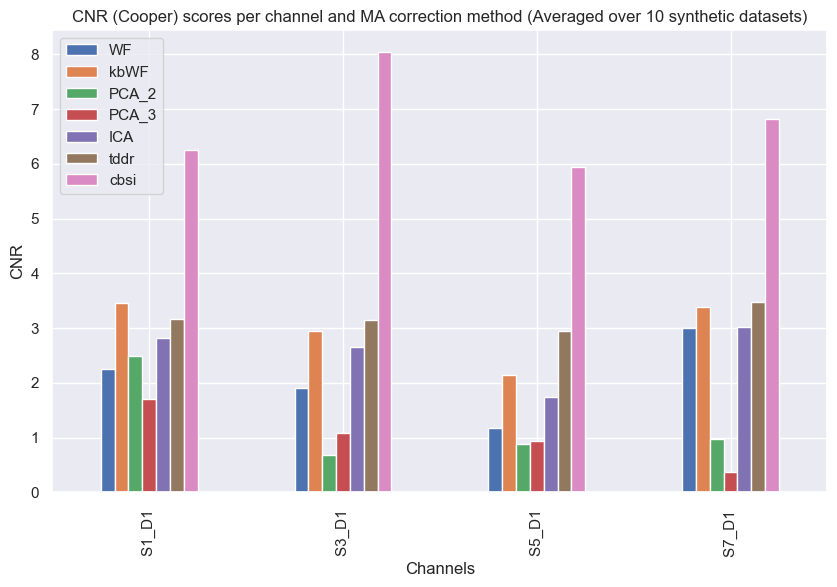

In [243]:
CNR_C_synth_haemo_WF = pd.DataFrame(CNR_cooper_synth_haemo_WFs.values(), columns = channels).mean(axis = 0)
CNR_C_synth_haemo_kWF = pd.DataFrame(CNR_cooper_synth_haemo_kWFs.values(), columns = channels).mean(axis = 0)
CNR_C_synth_haemo_PCA_2 = pd.DataFrame(CNR_cooper_synth_haemo_PCAs_2.values(), columns = channels).mean(axis = 0)
CNR_C_synth_haemo_PCA_3 = pd.DataFrame(CNR_cooper_synth_haemo_PCAs_3.values(), columns = channels).mean(axis = 0)
CNR_C_synth_haemo_ICA = pd.DataFrame(CNR_cooper_synth_haemo_ICAs.values(), columns = channels).mean(axis = 0)
CNR_C_synth_haemo_tddr = pd.DataFrame(CNR_cooper_synth_haemo_tddrs.values(), columns = channels).mean(axis = 0)
CNR_C_synth_haemo_cbsi = pd.DataFrame(CNR_cooper_synth_haemo_cbsis.values(), columns = channels).mean(axis = 0)
CNR_C = pd.concat([CNR_C_synth_haemo_WF, CNR_C_synth_haemo_kWF, CNR_C_synth_haemo_PCA_2, CNR_C_synth_haemo_PCA_3, CNR_C_synth_haemo_ICA, CNR_C_synth_haemo_tddr, CNR_C_synth_haemo_cbsi], axis = 1)
CNR_C.columns = methods

CNR_C.plot.bar(title = 'CNR (Cooper) scores per channel and MA correction method (Averaged over 10 synthetic datasets)', ylabel = 'CNR', xlabel = 'Channels').get_figure().savefig('CNR_C.png', bbox_inches = 'tight')

In [244]:
# Mean score over all channels
scores_CNR_C = CNR_C.mean(axis = 0).sort_values(ascending = False)
scores_CNR_C

cbsi     6.763453
tddr     3.182997
kbWF     2.986129
ICA      2.555772
WF       2.081156
PCA_2    1.256083
PCA_3    1.023772
dtype: float64

In [245]:
print('The best MA correction technique based on CNR (Cooper) value is: ' + CNR_C.mean(axis = 0).idxmax() + ' (value = ' + str(CNR_C.mean(axis = 0).max()) + ')')

The best MA correction technique based on CNR (Cooper) value is: cbsi (value = 6.763452832605174)


---
> *Remark:*
- Best method according to CNR (Cooper) is CBSI
---

##### CNR (Zhang)

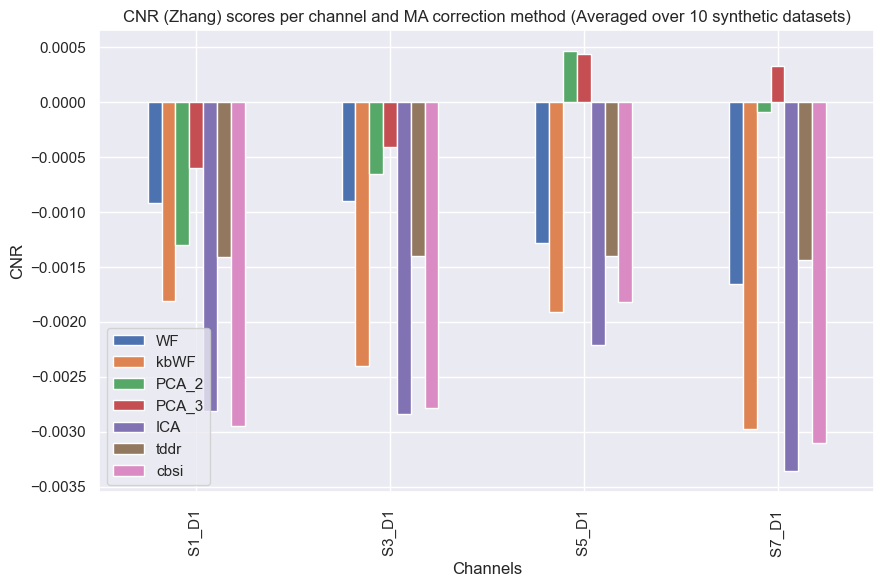

In [246]:
CNR_Z_synth_haemo_WF = pd.DataFrame(CNR_zhang_synth_haemo_WFs.values(), columns = channels).mean(axis = 0)
CNR_Z_synth_haemo_kWF = pd.DataFrame(CNR_zhang_synth_haemo_kWFs.values(), columns = channels).mean(axis = 0)
CNR_Z_synth_haemo_PCA_2 = pd.DataFrame(CNR_zhang_synth_haemo_PCAs_2.values(), columns = channels).mean(axis = 0)
CNR_Z_synth_haemo_PCA_3 = pd.DataFrame(CNR_zhang_synth_haemo_PCAs_3.values(), columns = channels).mean(axis = 0)
CNR_Z_synth_haemo_ICA = pd.DataFrame(CNR_zhang_synth_haemo_ICAs.values(), columns = channels).mean(axis = 0)
CNR_Z_synth_haemo_tddr = pd.DataFrame(CNR_zhang_synth_haemo_tddrs.values(), columns = channels).mean(axis = 0)
CNR_Z_synth_haemo_cbsi = pd.DataFrame(CNR_zhang_synth_haemo_cbsis.values(), columns = channels).mean(axis = 0)
CNR_Z = pd.concat([CNR_Z_synth_haemo_WF, CNR_Z_synth_haemo_kWF, CNR_Z_synth_haemo_PCA_2, CNR_Z_synth_haemo_PCA_3, CNR_Z_synth_haemo_ICA, CNR_Z_synth_haemo_tddr, CNR_Z_synth_haemo_cbsi], axis = 1)
CNR_Z.columns = methods

CNR_Z.plot.bar(title = 'CNR (Zhang) scores per channel and MA correction method (Averaged over 10 synthetic datasets)', ylabel = 'CNR', xlabel = 'Channels').get_figure().savefig('CNR_Z.png', bbox_inches = 'tight')

In [247]:
# Mean score over all channels
scores_CNR_Z = CNR_Z.mean(axis = 0).sort_values(ascending = False)
scores_CNR_Z

PCA_3   -0.000059
PCA_2   -0.000394
WF      -0.001190
tddr    -0.001410
kbWF    -0.002275
cbsi    -0.002664
ICA     -0.002807
dtype: float64

In [248]:
print('The best MA correction technique based on CNR (Zhang) value is: ' + CNR_Z.mean(axis = 0).idxmax() + ' (value = ' + str(CNR_Z.mean(axis = 0).max()) + ')')

The best MA correction technique based on CNR (Zhang) value is: PCA_3 (value = -5.942612919346502e-05)


---
> *Remark:*
- Best method according to CNR (Zhang) is PCA (3 components)
---

##### APA

In [249]:
channels = raw_synth_od_cleans[0].ch_names

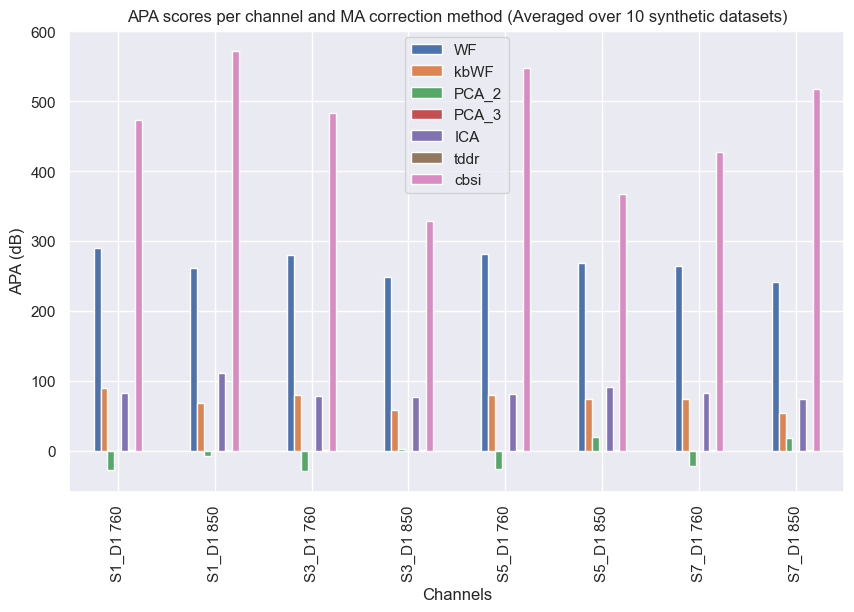

In [250]:
APA_synth_od_WF = pd.DataFrame(APA_synth_od_WFs.values(), columns = channels).mean(axis = 0)
APA_synth_od_kWF = pd.DataFrame(APA_synth_od_kWFs.values(), columns = channels).mean(axis = 0)
APA_synth_od_PCA_2 = pd.DataFrame(APA_synth_od_PCAs_2.values(), columns = channels).mean(axis = 0)
APA_synth_od_PCA_3 = pd.DataFrame(APA_synth_od_PCAs_3.values(), columns = channels).mean(axis = 0)
APA_synth_od_ICA = pd.DataFrame(APA_synth_od_ICAs.values(), columns = channels).mean(axis = 0)
APA_synth_od_tddr = pd.DataFrame(APA_synth_od_tddrs.values(), columns = channels).mean(axis = 0)
APA_synth_od_cbsi = pd.DataFrame(APA_synth_od_cbsis.values(), columns = channels).mean(axis = 0)
APA = pd.concat([APA_synth_od_WF, APA_synth_od_kWF, APA_synth_od_PCA_2, APA_synth_od_PCA_3, APA_synth_od_ICA, APA_synth_od_tddr, APA_synth_od_cbsi], axis = 1)
APA.columns = methods

APA.plot.bar(title = 'APA scores per channel and MA correction method (Averaged over 10 synthetic datasets)', ylabel = 'APA (dB)', xlabel = 'Channels').get_figure().savefig('APA.png', bbox_inches = 'tight')

In [251]:
# Mean score over all channels
scores_APA_synth = APA.mean(axis = 0).sort_values(ascending = False)
scores_APA_synth

cbsi     464.455302
WF       266.916086
ICA       84.763916
kbWF      72.277848
tddr       0.553336
PCA_3      0.000000
PCA_2     -8.758862
dtype: float64

In [252]:
print('The best MA correction technique based on APA value is: ' + APA.mean(axis = 0).idxmax() + ' (value = ' + str(APA.mean(axis = 0).max()) + ')')

The best MA correction technique based on APA value is: cbsi (value = 464.45530181815116)


---
> *Remark:*
- Best method according to APA is CBSI
---

#### Motion artefact experiment dataset <a class="anchor" id="sub_section_1_7_2"></a>

##### APA

In [253]:
channels = raw_od.ch_names

In [254]:
APA2 = pd.DataFrame()
APA2['WF'] = APA_od_WF
APA2['kbWF'] = APA_od_kWF
APA2['PCA_2'] = APA_od_PCA_2
APA2['PCA_3'] = APA_od_PCA_3
APA2['ICA'] = APA_od_ICA_MSD
APA2['ICA_CEI'] = APA_od_ICA_CEI
APA2['tddr'] = APA_od_tddr
APA2['cbsi'] = APA_od_cbsi
APA2.index = channels

%matplotlib qt
APA2.plot.bar(width = 1.5, title = 'APA scores per channel and MA correction method (Averaged over 10 synthetic datasets)', ylabel = 'APA (dB)', xlabel = 'Channels', figsize = (30,5)).get_figure().savefig('APA2.png', bbox_inches = 'tight')

In [255]:
# Mean score over all channels
scores_APA = APA2.mean(axis = 0).sort_values(ascending = False)
scores_APA

cbsi       186.927048
WF         152.948228
kbWF        50.150134
ICA         15.346208
tddr         0.018830
PCA_3        0.000000
PCA_2      -16.766857
ICA_CEI    -21.527875
dtype: float64

In [256]:
print('The best MA correction technique based on APA value is: ' + APA2.mean(axis = 0).idxmax() + ' (value = ' + str(APA2.mean(axis = 0).max()) + ')')

The best MA correction technique based on APA value is: cbsi (value = 186.92704761292265)


---
> *Remark:*
- Best method according to APA is CBSI
- ICA with the CEI scoring method has the lowest performance
---

#### Determine best motion artefact correction technique <a class="anchor" id="sub_section_1_7_3"></a>

In [257]:
results = {
    'SNR': scores_SNR,
    'PRD': scores_PRD,
    'CC' : scores_CC,
    'CNR_Cooper' : scores_CNR_C,
    'CNR_Zhang' : scores_CNR_Z,
    'APA_synth' : scores_APA_synth,
    'APA' : scores_APA.drop('ICA_CEI')
}
ranking = pd.DataFrame()
# Calculate ranks for each metric
for metric_name, metric_scores in results.items():
    # Rank the scores; ascending or descending depending on the metric's nature
    if metric_name == 'PRD':  
        ranking[f'{metric_name}_rank'] = metric_scores.rank(ascending=False, method='min').astype(int)
    else:  
        ranking[f'{metric_name}_rank'] = metric_scores.rank(ascending=True, method='min').astype(int)

# Display the final DataFrame
ranking

SNR_rank  PRD_rank  CC_rank  CNR_Cooper_rank  CNR_Zhang_rank  \
tddr          7         7        7                6               4   
cbsi          6         6        1                7               2   
ICA           5         5        5                4               1   
WF            4         3        4                3               5   
kbWF          3         1        6                5               3   
PCA_2         2         4        2                2               6   
PCA_3         1         2        3                1               7   

       APA_synth_rank  APA_rank  
tddr                3         3  
cbsi                7         7  
ICA                 5         4  
WF                  6         6  
kbWF                4         5  
PCA_2               1         1  
PCA_3               2         2

In [260]:
if export:
    dfi.export(ranking,"ranking_MA_methods_table.png")

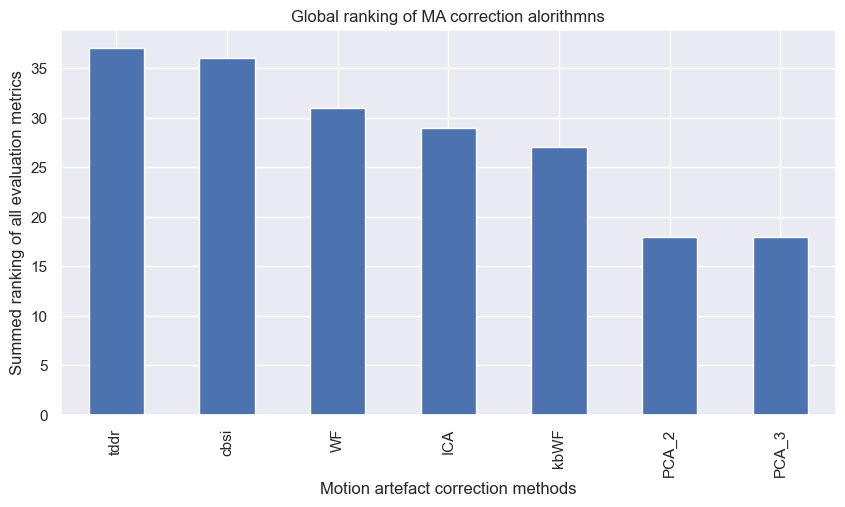

In [258]:
%matplotlib inline
# Sum rankings
final_ranking = ranking.sum(axis = 1).sort_values(ascending = False)
final_ranking.plot.bar(title = 'Global ranking of MA correction alorithmns', ylabel = 'Summed ranking of all evaluation metrics', xlabel = 'Motion artefact correction methods', figsize = (10,5)).get_figure().savefig('ranking_methods.png', bbox_inches = 'tight')